# **1. Librerías**

In [ ]:
# Para poder acceder a un archivo en Google Drive
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive

!pip install SimpleITK
!pip install timm
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv

Mounted at /content/drive/
/content/drive/My Drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing install

In [ ]:
import os
import json
import random
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv, global_mean_pool, global_add_pool, global_max_pool, Set2Set

import SimpleITK as sitk
from skimage.measure import label, regionprops

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from collections import defaultdict

import timm
import networkx as nx

# **2. Importación del dataset de grafos**

⚠️ <font color='magenta'>Modificar por su ruta personal para: **IA2_DatasetGrafos_PICAI_Consolidado**</font>

In [ ]:
ruta_dataset = '/content/drive/MyDrive/Proyecto_IA2/Dataset/IA2_DatasetGrafos_PICAI_Consolidado'
dataset_grafos = torch.load(ruta_dataset, weights_only=False)

print(f"Dataset cargado con {len(dataset_grafos)} grafos")

Dataset cargado con 1083 grafos


# **3. Coincidencia IDs del dataset de grafos con el 5kfold**

⚠️ <font color='magenta'>Modificar por su ruta personal para: **IA2_picai_patches_splits_5kf.json**</font>

In [ ]:
kfold_path = "/content/drive/My Drive/Proyecto_IA2/DatasetIA2_picai_patches_splits_5kf.json"

In [ ]:
with open(kfold_path, 'r') as file:
    kfold_data = json.load(file)

In [ ]:
# Verificar que todos lod IDs estén en el 5k-fold
id_fold_map = defaultdict(lambda: {'val': None, 'train': []})

for fold_name, ids in kfold_data.items():
    fold_num = int(fold_name.split('_')[-1])
    fold_type = 'val' if fold_name.startswith('val') else 'train'

    for id_ in ids:
        if fold_type == 'val':
            if id_fold_map[id_]['val'] is not None:
                print(f"⚠️ ID {id_} aparece en más de un val_fold.")
            id_fold_map[id_]['val'] = fold_num
        else:
            id_fold_map[id_]['train'].append(fold_num)

for data in dataset_grafos:
    lesion_id = data.lesion_id
    folds_info = id_fold_map.get(lesion_id, None)

    if not folds_info:
        print(f"❌ ID {lesion_id} no está presente en el archivo JSON.")
        continue

    val_fold = folds_info['val']
    train_folds = folds_info['train']

    if val_fold is None:
        print(f"❌ ID {lesion_id} no aparece en ningún val_fold.")
    elif len(train_folds) != 4:
        print(f"❌ ID {lesion_id} aparece {len(train_folds)} veces en train_folds, esperado: 4.")
    elif val_fold in train_folds:
        print(f"❌ ID {lesion_id} aparece en train_fold y val_fold del mismo fold {val_fold}.")
    else:
        print(f"✅ ID {lesion_id} está bien.")
        pass

✅ ID 10297_1000303_000 está bien.
✅ ID 10118_1000118_000 está bien.
✅ ID 10707_1000723_000 está bien.
✅ ID 11065_1001087_000 está bien.
✅ ID 10370_1000376_000 está bien.
✅ ID 10941_1000960_000 está bien.
✅ ID 11309_1001332_000 está bien.
✅ ID 10642_1000658_000 está bien.
✅ ID 11119_1001142_000 está bien.
✅ ID 10071_1000071_000 está bien.
✅ ID 11412_1001436_000 está bien.
✅ ID 11234_1001257_000 está bien.
✅ ID 10475_1000483_000 está bien.
✅ ID 10502_1000511_000 está bien.
✅ ID 10469_1000477_000 está bien.
✅ ID 11199_1001222_000 está bien.
✅ ID 11224_1001247_000 está bien.
✅ ID 10339_1000345_000 está bien.
✅ ID 10168_1000171_000 está bien.
✅ ID 11402_1001426_000 está bien.
✅ ID 11298_1001321_000 está bien.
✅ ID 10880_1000896_000 está bien.
✅ ID 10061_1000061_000 está bien.
✅ ID 10793_1000809_000 está bien.
✅ ID 10493_1000502_000 está bien.
✅ ID 10211_1000215_000 está bien.
✅ ID 10196_1000200_000 está bien.
✅ ID 10580_1000593_000 está bien.
✅ ID 10345_1000351_000 está bien.
✅ ID 11307_100

In [ ]:
# Contar cuantos IDs hay en cada fold
fold_splits = {i: {'train': [], 'val': []} for i in range(5)}

id_fold_map = defaultdict(lambda: {'val': None, 'train': []})

for fold_name, ids in kfold_data.items():
    fold_num = int(fold_name.split('_')[-1])
    fold_type = 'val' if fold_name.startswith('val') else 'train'

    for id_ in ids:
        if fold_type == 'val':
            id_fold_map[id_]['val'] = fold_num
        else:
            id_fold_map[id_]['train'].append(fold_num)

for lesion_id, info in id_fold_map.items():
    val_fold = info['val']
    train_folds = info['train']

    fold_splits[val_fold]['val'].append(lesion_id)
    for fold in train_folds:
        fold_splits[fold]['train'].append(lesion_id)

In [ ]:
print("Tamaño de cada fold:")
for fold, ids in fold_splits.items():
    print(f"Fold {fold}: {len(ids['train'])} train, {len(ids['val'])} val, {len(ids['train']) + len(ids['val'])} total")

Tamaño de cada fold:
Fold 0: 873 train, 210 val, 1083 total
Fold 1: 858 train, 225 val, 1083 total
Fold 2: 868 train, 215 val, 1083 total
Fold 3: 860 train, 223 val, 1083 total
Fold 4: 873 train, 210 val, 1083 total


In [ ]:
# Se crea un índice rápido
id_to_data = {data.lesion_id: data for data in dataset_grafos}

# **4. Exp1 (GCN - 2 capas)**

In [ ]:
# Configuraciones
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30
num_classes = 2
num_features = dataset_grafos[0].x.shape[1]

# Resultados acumulados por fold
all_val_accs = []
all_val_aucs = []
all_val_precisions = []
all_val_recalls = []

In [ ]:
class GCN(nn.Module):
  def __init__(self, num_features, num_classes):
    super(GCN, self).__init__()
    self.conv1 = GCNConv(num_features, 128)
    self.conv2 = GCNConv(128, 64)
    self.lin = nn.Linear(64, num_classes)

  def forward(self, x, edge_index, batch):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = global_mean_pool(x, batch)
    x = self.lin(x)
    return x


====== Fold 0 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6546, Acc: 0.6747, AUC: 0.5220, Prec: 0.1988, Rec: 0.1711 | Val Loss: 0.5744, Acc: 0.7667, AUC: 0.8604, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4993, Acc: 0.7858, AUC: 0.6524, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4751, Acc: 0.7667, AUC: 0.8556, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.4311, Acc: 0.7789, AUC: 0.8523, Prec: 0.3500, Rec: 0.0374 | Val Loss: 0.4157, Acc: 0.7905, AUC: 0.8616, Prec: 0.6667, Rec: 0.2041
Epoch 04: Train Loss: 0.3765, Acc: 0.8167, AUC: 0.8669, Prec: 0.7015, Rec: 0.2513 | Val Loss: 0.3833, Acc: 0.8048, AUC: 0.8759, Prec: 0.7222, Rec: 0.2653
Epoch 05: Train Loss: 0.3448, Acc: 0.8396, AUC: 0.8832, Prec: 0.7156, Rec: 0.4171 | Val Loss: 0.3527, Acc: 0.8571, AUC: 0.8862, Prec: 0.7714, Rec: 0.5510
Epoch 06: Train Loss: 0.3208, Acc: 0.8603, AUC: 0.8941, Prec: 0.7241, Rec: 0.5615 | Val Loss: 0.3380, Acc: 0.8667, AUC: 0.8944, Prec: 0.8000, Rec: 0.5714
Epoch 07: Train Loss: 0.3138, Acc: 0.8706, AUC: 0.9021, Prec: 0.7403, Rec: 0.6096 | Val Loss: 0.3230, Acc: 0.8714, AUC: 0.9024, Prec: 0.7750, Rec: 0.6327
Epoch 08: Train Loss: 0.2884, Acc: 0.8763, AUC: 0.9133, Prec: 0.7548, Rec: 0

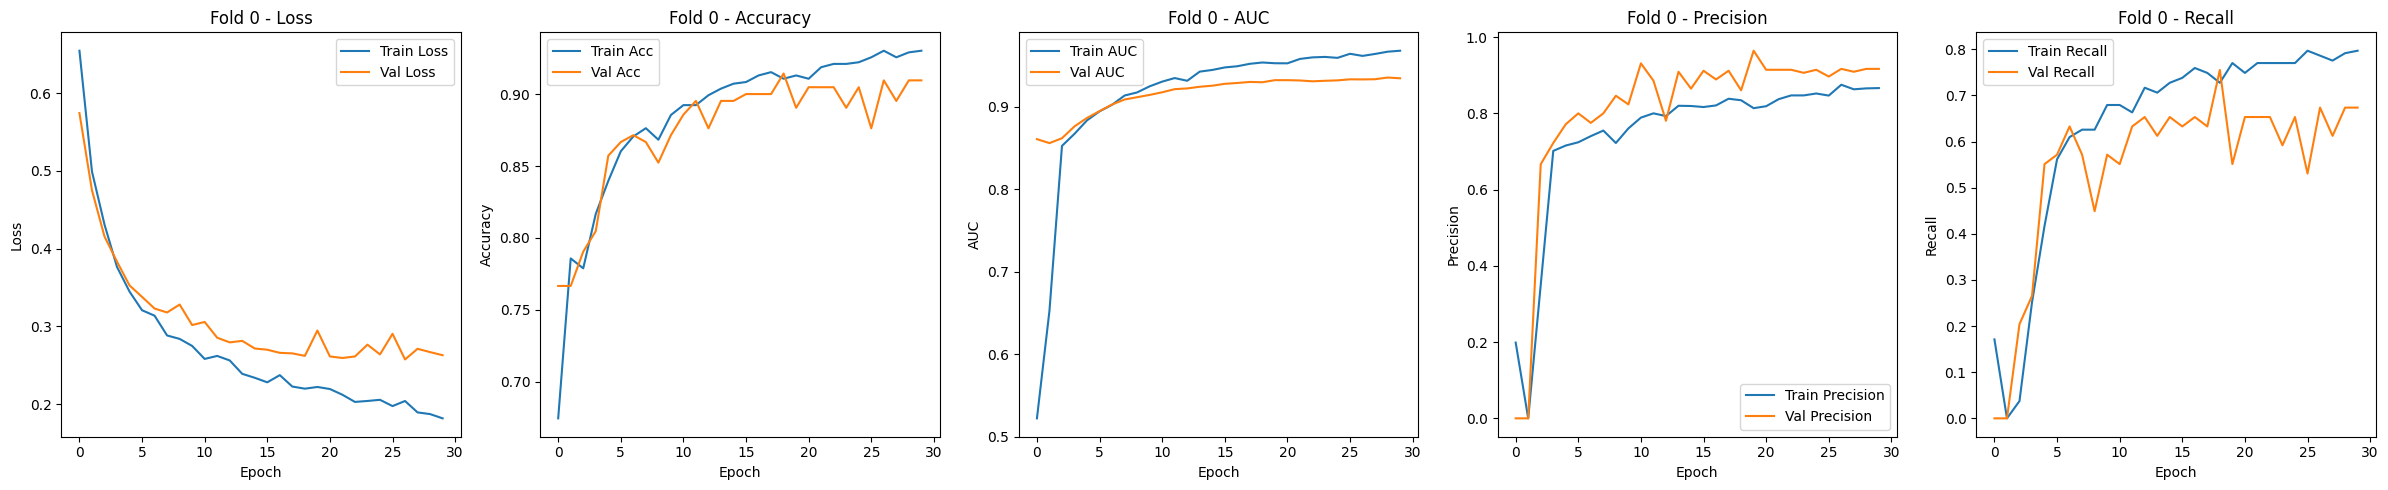

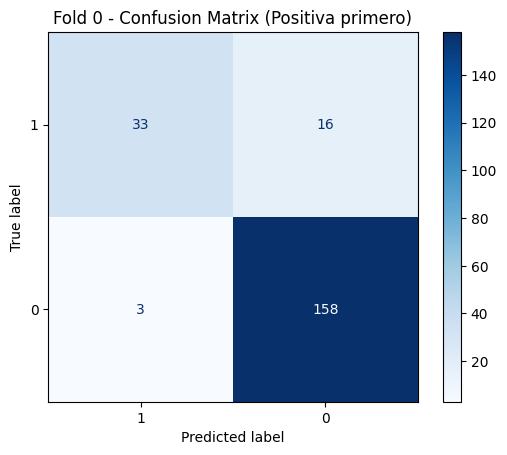


====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6685, Acc: 0.5711, AUC: 0.4974, Prec: 0.2201, Rec: 0.3684 | Val Loss: 0.5442, Acc: 0.7956, AUC: 0.8447, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4987, Acc: 0.7786, AUC: 0.6917, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.3989, Acc: 0.7956, AUC: 0.8739, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.4397, Acc: 0.7821, AUC: 0.8288, Prec: 0.5652, Rec: 0.0684 | Val Loss: 0.3583, Acc: 0.8089, AUC: 0.8852, Prec: 0.5652, Rec: 0.2826
Epoch 04: Train Loss: 0.3956, Acc: 0.8159, AUC: 0.8566, Prec: 0.7105, Rec: 0.2842 | Val Loss: 0.3049, Acc: 0.8400, AUC: 0.8970, Prec: 0.6562, Rec: 0.4565
Epoch 05: Train Loss: 0.3604, Acc: 0.8462, AUC: 0.8748, Prec: 0.7302, Rec: 0.4842 | Val Loss: 0.2814, Acc: 0.8622, AUC: 0.9098, Prec: 0.6923, Rec: 0.5870
Epoch 06: Train Loss: 0.3434, Acc: 0.8543, AUC: 0.8838, Prec: 0.7372, Rec: 0.5316 | Val Loss: 0.2705, Acc: 0.8711, AUC: 0.9209, Prec: 0.6977, Rec: 0.6522
Epoch 07: Train Loss: 0.3275, Acc: 0.8613, AUC: 0.8953, Prec: 0.7205, Rec: 0.6105 | Val Loss: 0.2575, Acc: 0.8800, AUC: 0.9330, Prec: 0.7111, Rec: 0.6957
Epoch 08: Train Loss: 0.3090, Acc: 0.8706, AUC: 0.9078, Prec: 0.7651, Rec: 0

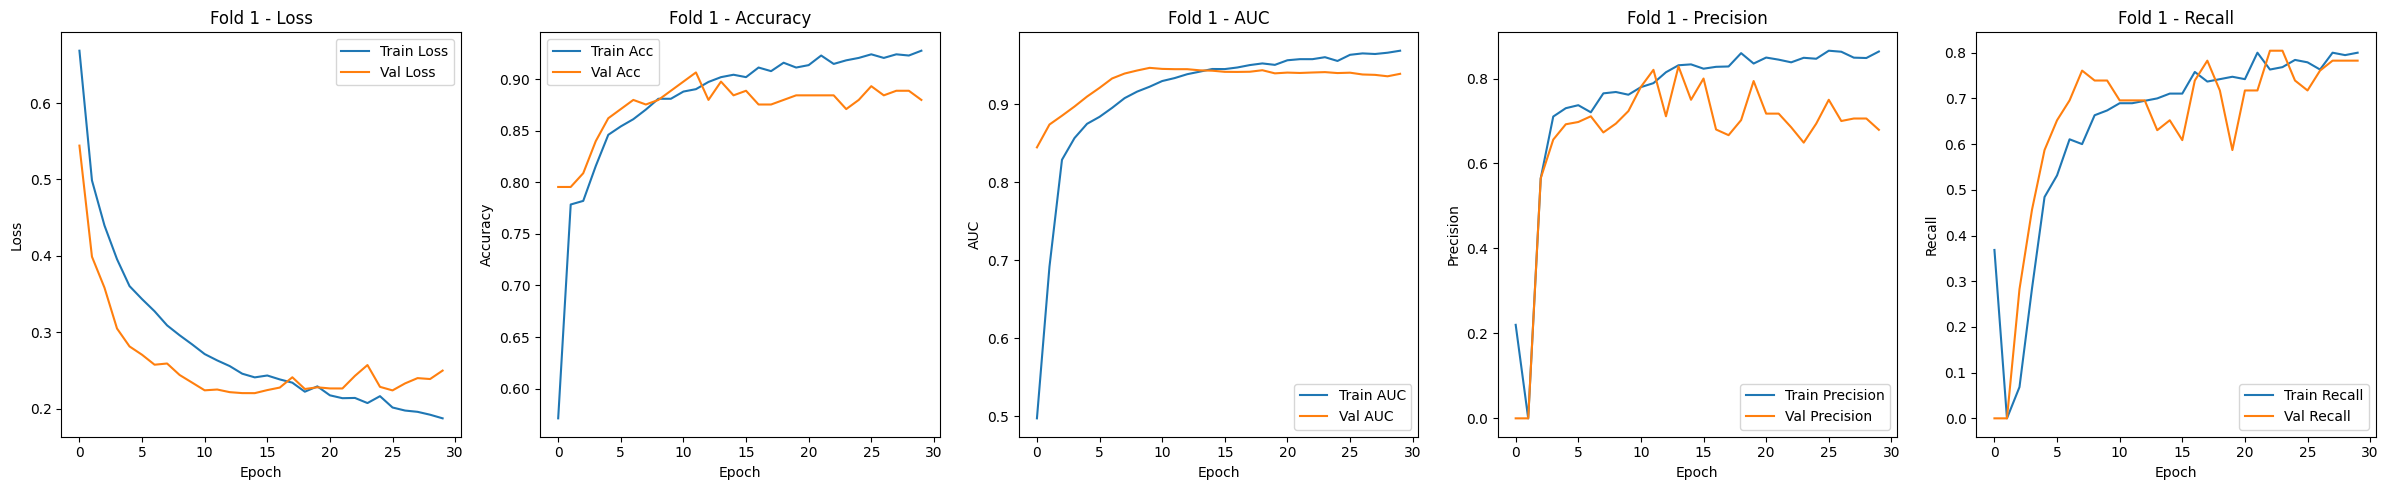

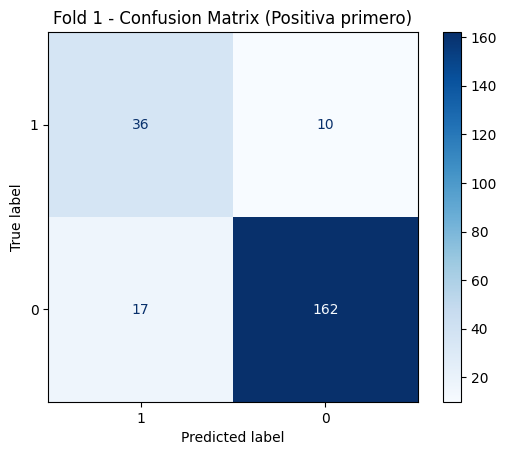


====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6608, Acc: 0.6544, AUC: 0.5457, Prec: 0.2535, Rec: 0.2850 | Val Loss: 0.5862, Acc: 0.8000, AUC: 0.8325, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.5083, Acc: 0.7776, AUC: 0.6435, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4506, Acc: 0.8000, AUC: 0.8536, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.4575, Acc: 0.7765, AUC: 0.8404, Prec: 0.4000, Rec: 0.0104 | Val Loss: 0.4039, Acc: 0.7907, AUC: 0.8637, Prec: 0.3333, Rec: 0.0465
Epoch 04: Train Loss: 0.4206, Acc: 0.7949, AUC: 0.8645, Prec: 0.6471, Rec: 0.1710 | Val Loss: 0.3619, Acc: 0.8605, AUC: 0.8725, Prec: 0.7826, Rec: 0.4186
Epoch 05: Train Loss: 0.3621, Acc: 0.8318, AUC: 0.8811, Prec: 0.7423, Rec: 0.3731 | Val Loss: 0.3429, Acc: 0.8465, AUC: 0.8851, Prec: 0.6389, Rec: 0.5349
Epoch 06: Train Loss: 0.3330, Acc: 0.8629, AUC: 0.8893, Prec: 0.7721, Rec: 0.5440 | Val Loss: 0.3210, Acc: 0.8558, AUC: 0.8939, Prec: 0.6875, Rec: 0.5116
Epoch 07: Train Loss: 0.3267, Acc: 0.8733, AUC: 0.8974, Prec: 0.7643, Rec: 0.6218 | Val Loss: 0.3094, Acc: 0.8605, AUC: 0.9016, Prec: 0.6857, Rec: 0.5581
Epoch 08: Train Loss: 0.3116, Acc: 0.8721, AUC: 0.9059, Prec: 0.7808, Rec: 0

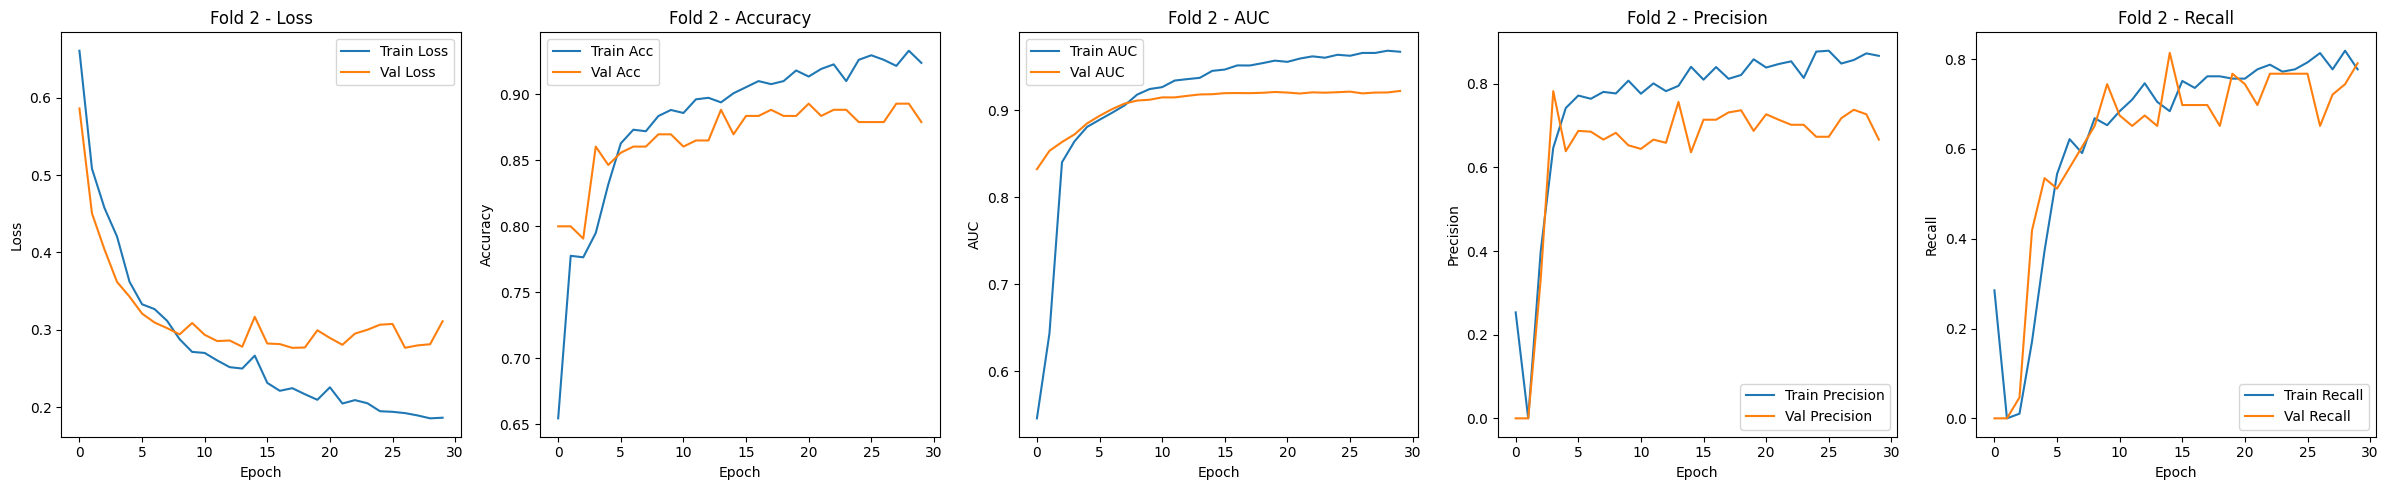

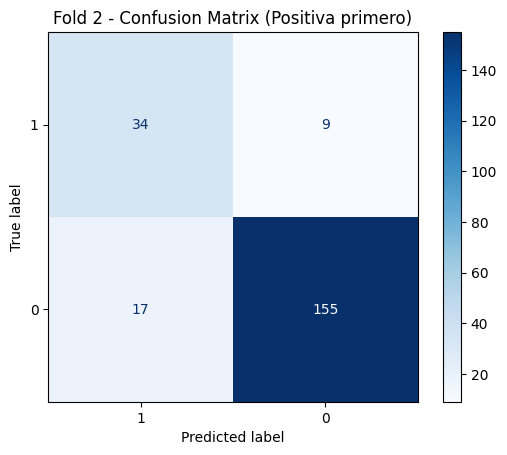


====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6873, Acc: 0.4849, AUC: 0.4898, Prec: 0.2005, Rec: 0.4497 | Val Loss: 0.6109, Acc: 0.7892, AUC: 0.8737, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.5437, Acc: 0.7802, AUC: 0.5510, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4738, Acc: 0.7892, AUC: 0.8816, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 03: Train Loss: 0.4660, Acc: 0.7802, AUC: 0.8696, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4343, Acc: 0.7892, AUC: 0.8801, Prec: 0.0000, Rec: 0.0000
Epoch 04: Train Loss: 0.4199, Acc: 0.7872, AUC: 0.8700, Prec: 0.7143, Rec: 0.0529 | Val Loss: 0.3913, Acc: 0.8072, AUC: 0.8829, Prec: 0.6429, Rec: 0.1915
Epoch 05: Train Loss: 0.3772, Acc: 0.8291, AUC: 0.8823, Prec: 0.7561, Rec: 0.3280 | Val Loss: 0.3524, Acc: 0.8565, AUC: 0.8837, Prec: 0.7273, Rec: 0.5106
Epoch 06: Train Loss: 0.3444, Acc: 0.8535, AUC: 0.8913, Prec: 0.7561, Rec: 0.4921 | Val Loss: 0.3340, Acc: 0.8700, AUC: 0.8870, Prec: 0.6957, Rec: 0.6809
Epoch 07: Train Loss: 0.3196, Acc: 0.8663, AUC: 0.9050, Prec: 0.7569, Rec: 0.5767 | Val Loss: 0.3181, Acc: 0.8744, AUC: 0.8879, Prec: 0.7568, Rec: 0.5957
Epoch 08: Train Loss: 0.3025, Acc: 0.8767, AUC: 0.9131, Prec: 0.7862, Rec: 0.6032 | Val Loss: 0.3099, Acc: 0.8789, AUC: 0.8914, Prec: 0.7381, Rec: 0.6596
Epoch 09: Train Loss: 0.2934, Acc: 0.8767, AUC: 0.9170, Prec: 0.7943, Rec: 0

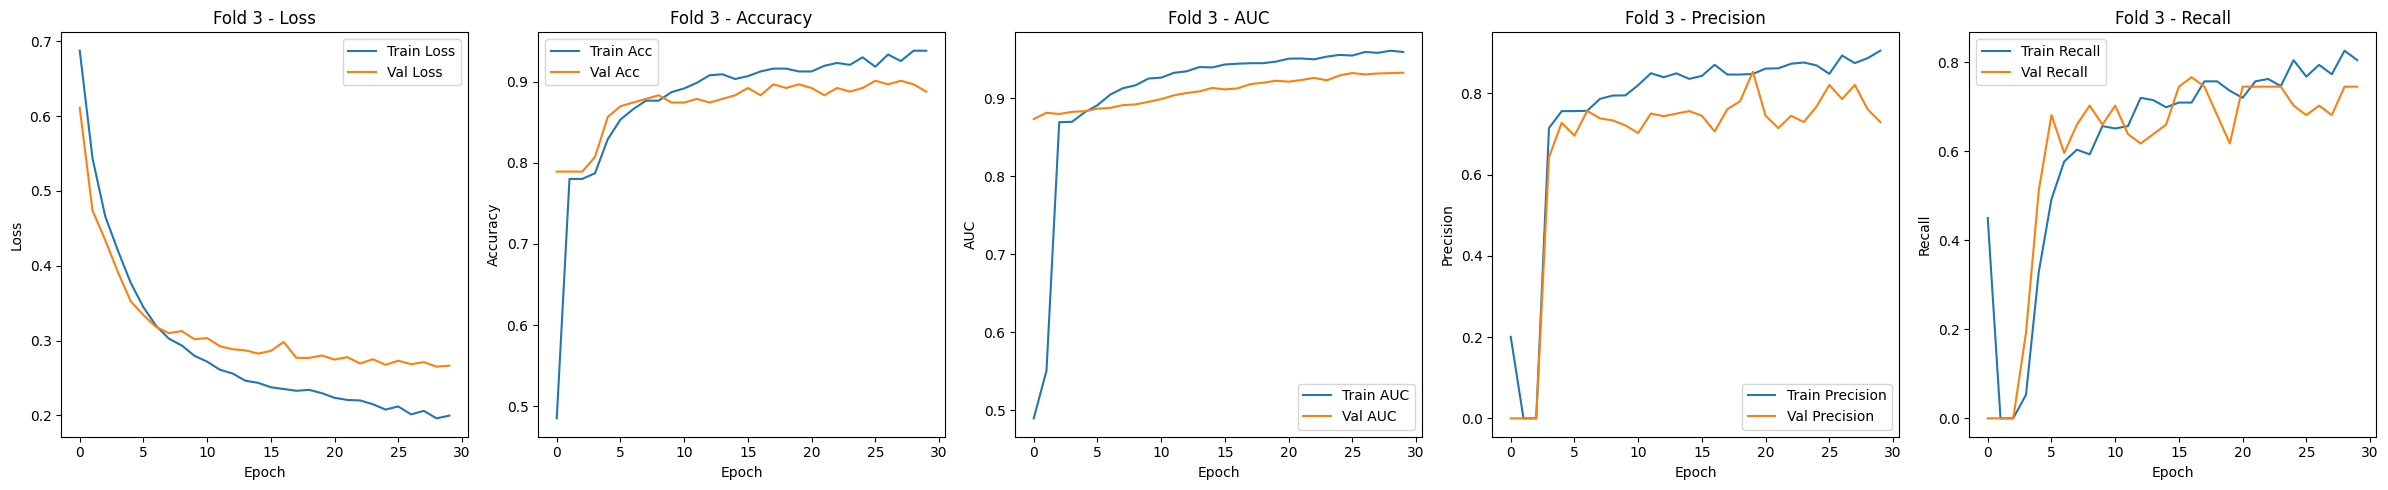

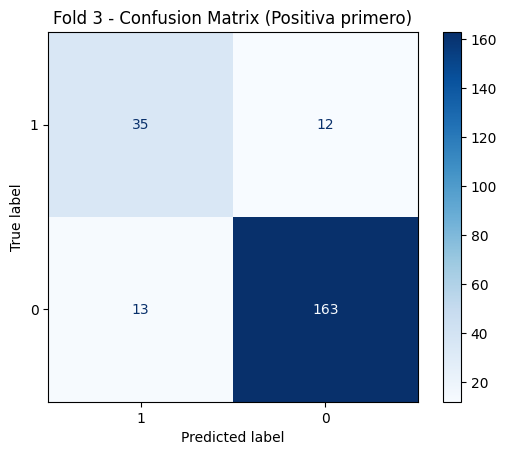


====== Fold 4 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6560, Acc: 0.6564, AUC: 0.6227, Prec: 0.2982, Rec: 0.4595 | Val Loss: 0.5779, Acc: 0.7571, AUC: 0.8084, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4883, Acc: 0.7881, AUC: 0.6662, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.5037, Acc: 0.7571, AUC: 0.8253, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.4152, Acc: 0.7915, AUC: 0.8646, Prec: 0.5714, Rec: 0.0649 | Val Loss: 0.4509, Acc: 0.7714, AUC: 0.8368, Prec: 1.0000, Rec: 0.0588
Epoch 04: Train Loss: 0.3670, Acc: 0.8156, AUC: 0.8736, Prec: 0.6500, Rec: 0.2811 | Val Loss: 0.4132, Acc: 0.8095, AUC: 0.8503, Prec: 0.8667, Rec: 0.2549
Epoch 05: Train Loss: 0.3507, Acc: 0.8522, AUC: 0.8830, Prec: 0.6944, Rec: 0.5405 | Val Loss: 0.4232, Acc: 0.8143, AUC: 0.8631, Prec: 0.8750, Rec: 0.2745
Epoch 06: Train Loss: 0.3245, Acc: 0.8625, AUC: 0.8955, Prec: 0.7372, Rec: 0.5459 | Val Loss: 0.3574, Acc: 0.8667, AUC: 0.8738, Prec: 0.8485, Rec: 0.5490
Epoch 07: Train Loss: 0.3108, Acc: 0.8603, AUC: 0.9008, Prec: 0.6957, Rec: 0.6054 | Val Loss: 0.3486, Acc: 0.8571, AUC: 0.8862, Prec: 0.8387, Rec: 0.5098
Epoch 08: Train Loss: 0.3029, Acc: 0.8660, AUC: 0.9096, Prec: 0.7073, Rec: 0

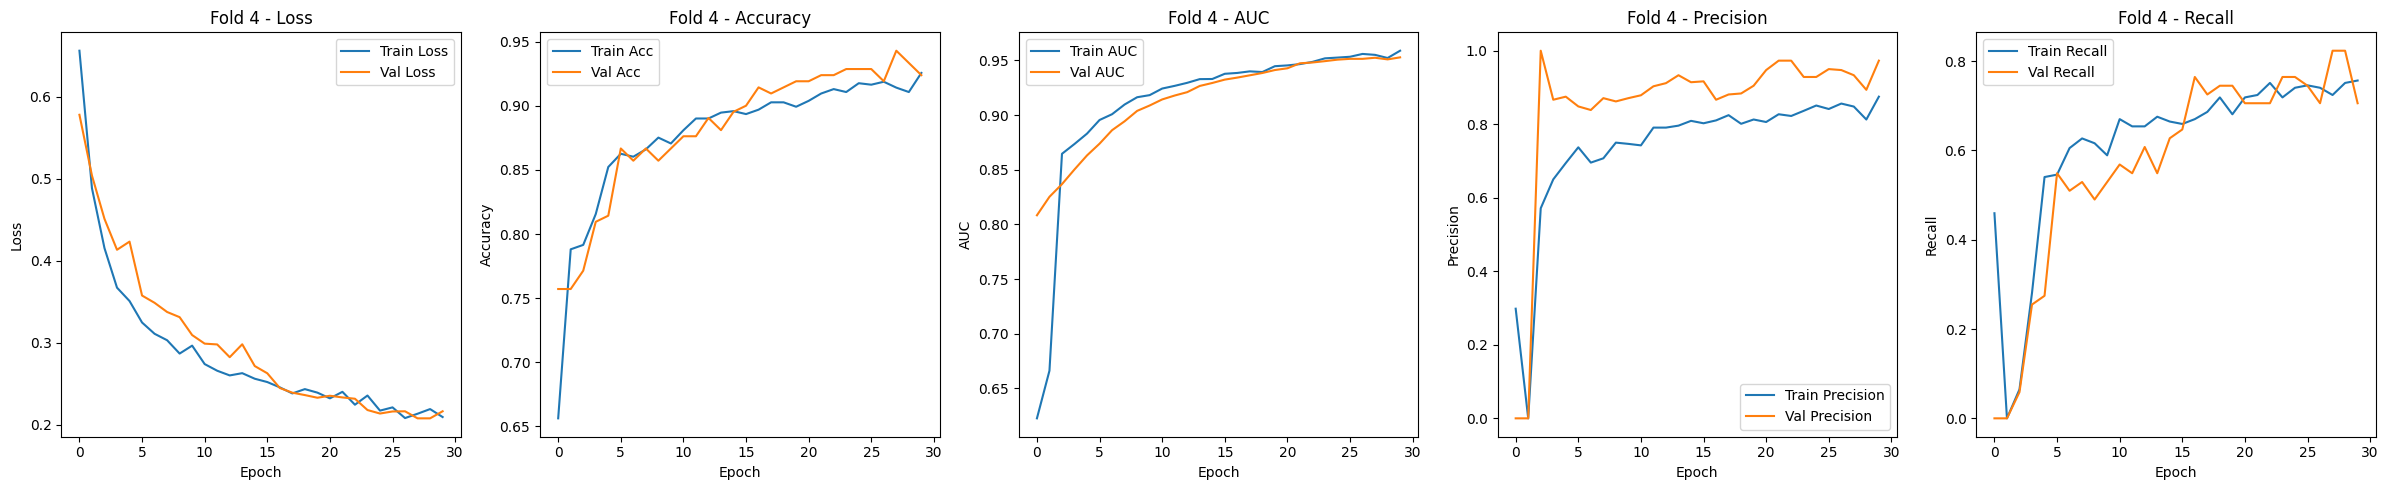

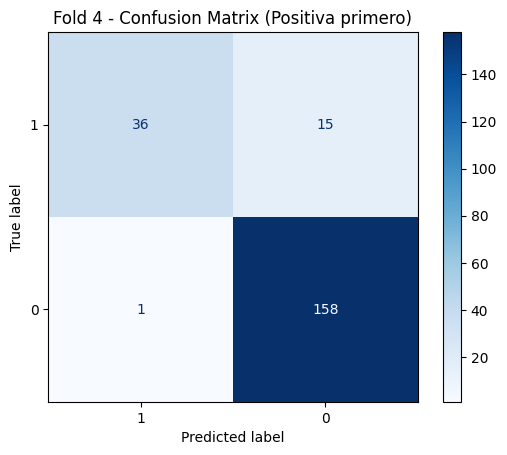


===== Resultados Finales por Fold =====
Fold 0 - Val Acc: 0.9095, AUC: 0.9342, Precision: 0.9167, Recall: 0.6735
Fold 1 - Val Acc: 0.8800, AUC: 0.9389, Precision: 0.6792, Recall: 0.7826
Fold 2 - Val Acc: 0.8791, AUC: 0.9225, Precision: 0.6667, Recall: 0.7907
Fold 3 - Val Acc: 0.8879, AUC: 0.9330, Precision: 0.7292, Recall: 0.7447
Fold 4 - Val Acc: 0.9238, AUC: 0.9528, Precision: 0.9730, Recall: 0.7059

===== Promedios Finales con Desviación Estándar =====
Val Accuracy: 0.8961 ± 0.0177
Val AUC: 0.9363 ± 0.0098
Val Precision: 0.7929 ± 0.1270
Val Recall: 0.7395 ± 0.0447


In [ ]:
for fold in range(5):
  print(f"\n====== Fold {fold} ======")

  # Preparar datos
  train_ids = kfold_data[f"train_fold_{fold}"]
  val_ids = kfold_data[f"val_fold_{fold}"]

  train_dataset = [id_to_data[i] for i in train_ids]
  val_dataset = [id_to_data[i] for i in val_ids]

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  # Inicializar modelo
  model = GCN(num_features, num_classes).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []
  train_aucs, val_aucs = [], []
  train_precisions, val_precisions = [], []
  train_recalls, val_recalls = [], []

  for epoch in range(1, num_epochs + 1):
    # ---- ENTRENAMIENTO ----
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    y_train_true = []
    y_train_prob = []
    y_train_pred = []

    for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      out = model(data.x, data.edge_index, data.batch)
      loss = criterion(out, data.y)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      pred = out.argmax(dim=1)
      correct += (pred == data.y).sum().item()
      total += data.y.size(0)

      y_train_true.append(data.y.cpu())
      y_train_prob.append(F.softmax(out, dim=1)[:, 1].detach().cpu())
      y_train_pred.append(pred.cpu())

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    y_train_true = torch.cat(y_train_true)
    y_train_prob = torch.cat(y_train_prob)
    y_train_pred = torch.cat(y_train_pred)
    train_auc = roc_auc_score(y_train_true, y_train_prob)
    train_precision = precision_score(y_train_true, y_train_pred)
    train_recall = recall_score(y_train_true, y_train_pred)

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    train_aucs.append(train_auc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)

    # ---- VALIDACIÓN ----
    model.eval()
    val_loss = 0
    correct = 0
    y_true = []
    y_prob = []
    y_pred = []

    with torch.no_grad():
      for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        val_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        y_true.append(data.y.cpu())
        y_prob.append(F.softmax(out, dim=1)[:, 1].cpu())
        y_pred.append(pred.cpu())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / len(val_loader.dataset)
    y_true = torch.cat(y_true)
    y_prob = torch.cat(y_prob)
    y_pred = torch.cat(y_pred)
    val_auc = roc_auc_score(y_true, y_prob)
    val_precision = precision_score(y_true, y_pred)
    val_recall = recall_score(y_true, y_pred)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    val_aucs.append(val_auc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, AUC: {train_auc:.4f}, "
          f"Prec: {train_precision:.4f}, Rec: {train_recall:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, AUC: {val_auc:.4f}, "
          f"Prec: {val_precision:.4f}, Rec: {val_recall:.4f}")

  # Guardar AUC y Accuracy final del fold
  all_val_accs.append(val_accuracies[-1])
  all_val_aucs.append(val_aucs[-1])
  all_val_precisions.append(val_precisions[-1])
  all_val_recalls.append(val_recalls[-1])

  # Graficar métricas por fold
  plt.figure(figsize=(24, 5))

  plt.subplot(1, 5, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.title(f'Fold {fold} - Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 5, 2)
  plt.plot(train_accuracies, label='Train Acc')
  plt.plot(val_accuracies, label='Val Acc')
  plt.title(f'Fold {fold} - Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 5, 3)
  plt.plot(train_aucs, label='Train AUC')
  plt.plot(val_aucs, label='Val AUC')
  plt.title(f'Fold {fold} - AUC')
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.legend()

  plt.subplot(1, 5, 4)
  plt.plot(train_precisions, label='Train Precision')
  plt.plot(val_precisions, label='Val Precision')
  plt.title(f'Fold {fold} - Precision')
  plt.xlabel('Epoch')
  plt.ylabel('Precision')
  plt.legend()

  plt.subplot(1, 5, 5)
  plt.plot(train_recalls, label='Train Recall')
  plt.plot(val_recalls, label='Val Recall')
  plt.title(f'Fold {fold} - Recall')
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Matriz de confusión
  cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
  disp.plot(cmap='Blues')
  plt.title(f'Fold {fold} - Confusion Matrix (Positiva primero)')
  plt.show()

# Resultados globales
print("\n===== Resultados Finales por Fold =====")
for i in range(len(all_val_accs)):
  print(f"Fold {i} - Val Acc: {all_val_accs[i]:.4f}, AUC: {all_val_aucs[i]:.4f}, "
        f"Precision: {all_val_precisions[i]:.4f}, Recall: {all_val_recalls[i]:.4f}")

# Promedios finales con desviación estándar
print("\n===== Promedios Finales con Desviación Estándar =====")
print(f"Val Accuracy: {np.mean(all_val_accs):.4f} ± {np.std(all_val_accs):.4f}")
print(f"Val AUC: {np.mean(all_val_aucs):.4f} ± {np.std(all_val_aucs):.4f}")
print(f"Val Precision: {np.mean(all_val_precisions):.4f} ± {np.std(all_val_precisions):.4f}")
print(f"Val Recall: {np.mean(all_val_recalls):.4f} ± {np.std(all_val_recalls):.4f}")

# **5. Exp2 (GCN - 3 capas)**

In [ ]:
# Configuraciones
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30
num_classes = 2
num_features = dataset_grafos[0].x.shape[1]

# Resultados acumulados por fold
all_val_accs = []
all_val_aucs = []
all_val_precisions = []
all_val_recalls = []

In [ ]:
class GCN(nn.Module):
  def __init__(self, num_features, num_classes):
    super(GCN, self).__init__()
    self.conv1 = GCNConv(num_features, 128)
    self.conv2 = GCNConv(128, 64)
    self.conv3 = GCNConv(64, 32)
    self.dropout = nn.Dropout(p=0.5)
    self.lin = nn.Linear(32, num_classes)

  def forward(self, x, edge_index, batch):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.conv3(x, edge_index)
    x = F.relu(x)
    x = global_mean_pool(x, batch)
    x = self.lin(x)
    return x


====== Fold 0 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6296, Acc: 0.7858, AUC: 0.5235, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.5815, Acc: 0.7667, AUC: 0.8369, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.5077, Acc: 0.7858, AUC: 0.6097, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4945, Acc: 0.7667, AUC: 0.8540, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 03: Train Loss: 0.4362, Acc: 0.7858, AUC: 0.8238, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4147, Acc: 0.7619, AUC: 0.8701, Prec: 0.4286, Rec: 0.0612
Epoch 04: Train Loss: 0.3850, Acc: 0.8099, AUC: 0.8611, Prec: 0.6667, Rec: 0.2246 | Val Loss: 0.3584, Acc: 0.8619, AUC: 0.8822, Prec: 0.7632, Rec: 0.5918
Epoch 05: Train Loss: 0.3434, Acc: 0.8488, AUC: 0.8778, Prec: 0.6923, Rec: 0.5294 | Val Loss: 0.3272, Acc: 0.8714, AUC: 0.8953, Prec: 0.7619, Rec: 0.6531
Epoch 06: Train Loss: 0.3228, Acc: 0.8751, AUC: 0.8962, Prec: 0.7407, Rec: 0.6417 | Val Loss: 0.3066, Acc: 0.8857, AUC: 0.9109, Prec: 0.7660, Rec: 0.7347
Epoch 07: Train Loss: 0.3014, Acc: 0.8751, AUC: 0.9078, Prec: 0.7407, Rec: 0.6417 | Val Loss: 0.3029, Acc: 0.8714, AUC: 0.9196, Prec: 0.8056, Rec: 0.5918
Epoch 08: Train Loss: 0.2720, Acc: 0.8900, AUC: 0.9217, Prec: 0.7542, Rec: 0.7219 | Val Loss: 0.2872, Acc: 0.8857, AUC: 0.9234, Prec: 0.8049, Rec: 0.6735
Epoch 09: Train Loss: 0.2754, Acc: 0.8935, AUC: 0.9209, Prec: 0.7798, Rec: 0

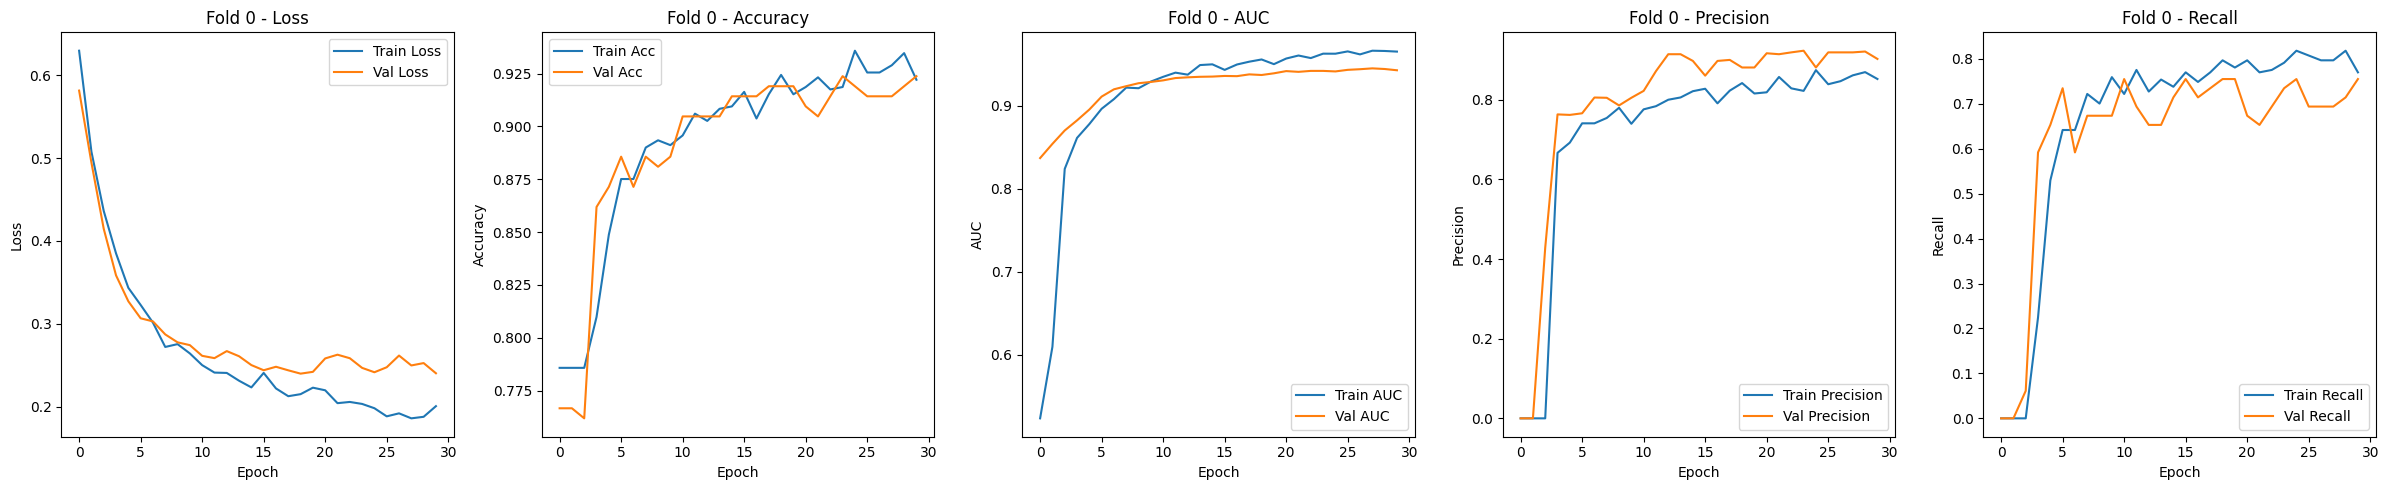

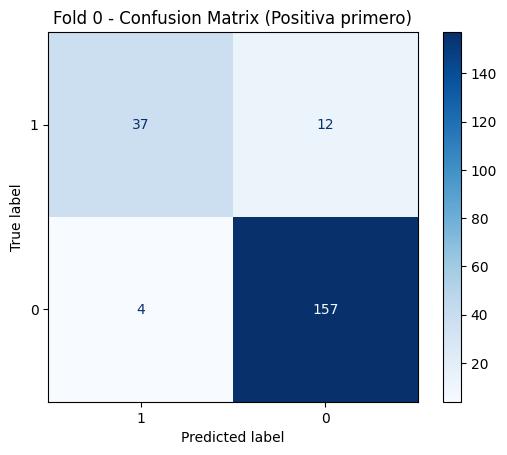


====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6396, Acc: 0.7226, AUC: 0.5087, Prec: 0.2447, Rec: 0.1211 | Val Loss: 0.5066, Acc: 0.7956, AUC: 0.8782, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4940, Acc: 0.7786, AUC: 0.7131, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.3919, Acc: 0.7956, AUC: 0.8976, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.4263, Acc: 0.7809, AUC: 0.8420, Prec: 0.6000, Rec: 0.0316 | Val Loss: 0.3208, Acc: 0.8311, AUC: 0.9043, Prec: 0.6333, Rec: 0.4130
Epoch 04: Train Loss: 0.3764, Acc: 0.8193, AUC: 0.8701, Prec: 0.7465, Rec: 0.2789 | Val Loss: 0.2879, Acc: 0.8711, AUC: 0.9117, Prec: 0.6889, Rec: 0.6739
Epoch 05: Train Loss: 0.3482, Acc: 0.8566, AUC: 0.8850, Prec: 0.7279, Rec: 0.5632 | Val Loss: 0.2553, Acc: 0.8711, AUC: 0.9179, Prec: 0.6977, Rec: 0.6522
Epoch 06: Train Loss: 0.3260, Acc: 0.8671, AUC: 0.8953, Prec: 0.7405, Rec: 0.6158 | Val Loss: 0.2471, Acc: 0.9022, AUC: 0.9305, Prec: 0.7143, Rec: 0.8696
Epoch 07: Train Loss: 0.3009, Acc: 0.8800, AUC: 0.9115, Prec: 0.7403, Rec: 0.7053 | Val Loss: 0.2511, Acc: 0.8933, AUC: 0.9355, Prec: 0.6833, Rec: 0.8913
Epoch 08: Train Loss: 0.2960, Acc: 0.8765, AUC: 0.9137, Prec: 0.7308, Rec: 0

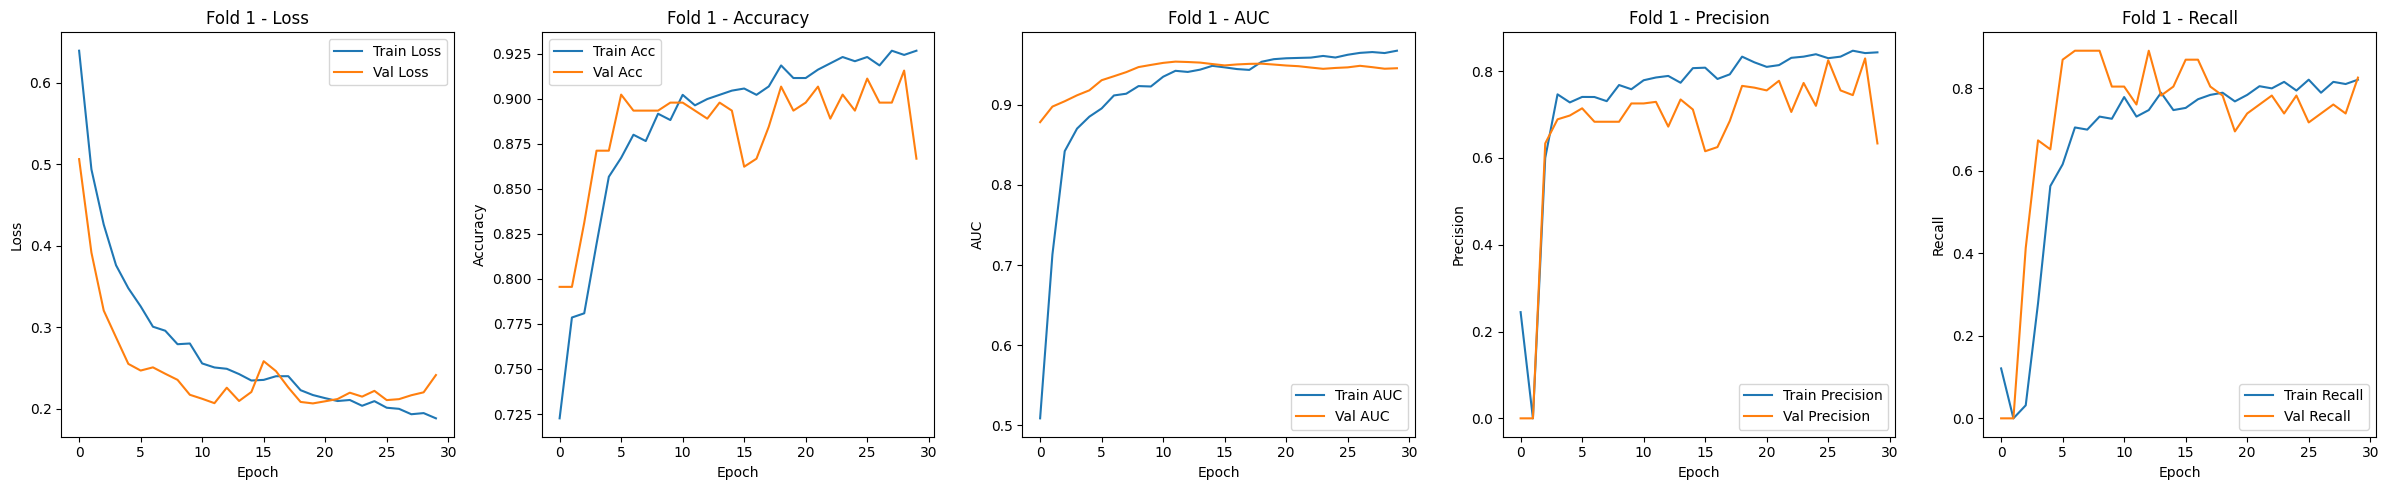

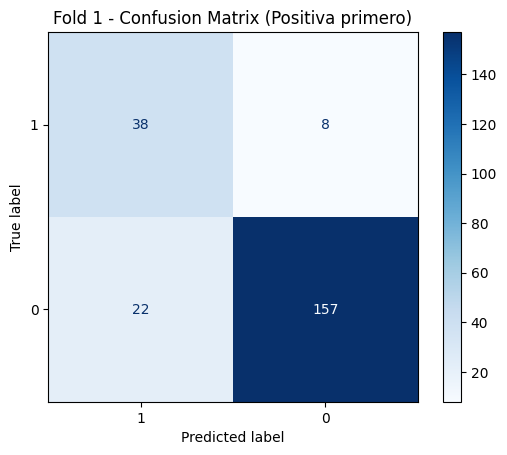


====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.5942, Acc: 0.7776, AUC: 0.6314, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.5300, Acc: 0.8000, AUC: 0.8302, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4866, Acc: 0.7776, AUC: 0.7319, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4161, Acc: 0.8000, AUC: 0.8505, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.4092, Acc: 0.7984, AUC: 0.8363, Prec: 0.6957, Rec: 0.1658 | Val Loss: 0.3604, Acc: 0.8326, AUC: 0.8660, Prec: 0.6522, Rec: 0.3488
Epoch 04: Train Loss: 0.3858, Acc: 0.8295, AUC: 0.8588, Prec: 0.6957, Rec: 0.4145 | Val Loss: 0.3311, Acc: 0.8512, AUC: 0.8826, Prec: 0.6410, Rec: 0.5814
Epoch 05: Train Loss: 0.3263, Acc: 0.8641, AUC: 0.8922, Prec: 0.7551, Rec: 0.5751 | Val Loss: 0.3193, Acc: 0.8465, AUC: 0.8967, Prec: 0.6250, Rec: 0.5814
Epoch 06: Train Loss: 0.3240, Acc: 0.8790, AUC: 0.9027, Prec: 0.7558, Rec: 0.6736 | Val Loss: 0.3142, Acc: 0.8651, AUC: 0.9079, Prec: 0.6458, Rec: 0.7209
Epoch 07: Train Loss: 0.2897, Acc: 0.8859, AUC: 0.9147, Prec: 0.7582, Rec: 0.7150 | Val Loss: 0.2944, Acc: 0.8651, AUC: 0.9137, Prec: 0.6750, Rec: 0.6279
Epoch 08: Train Loss: 0.2753, Acc: 0.8836, AUC: 0.9258, Prec: 0.7738, Rec: 0

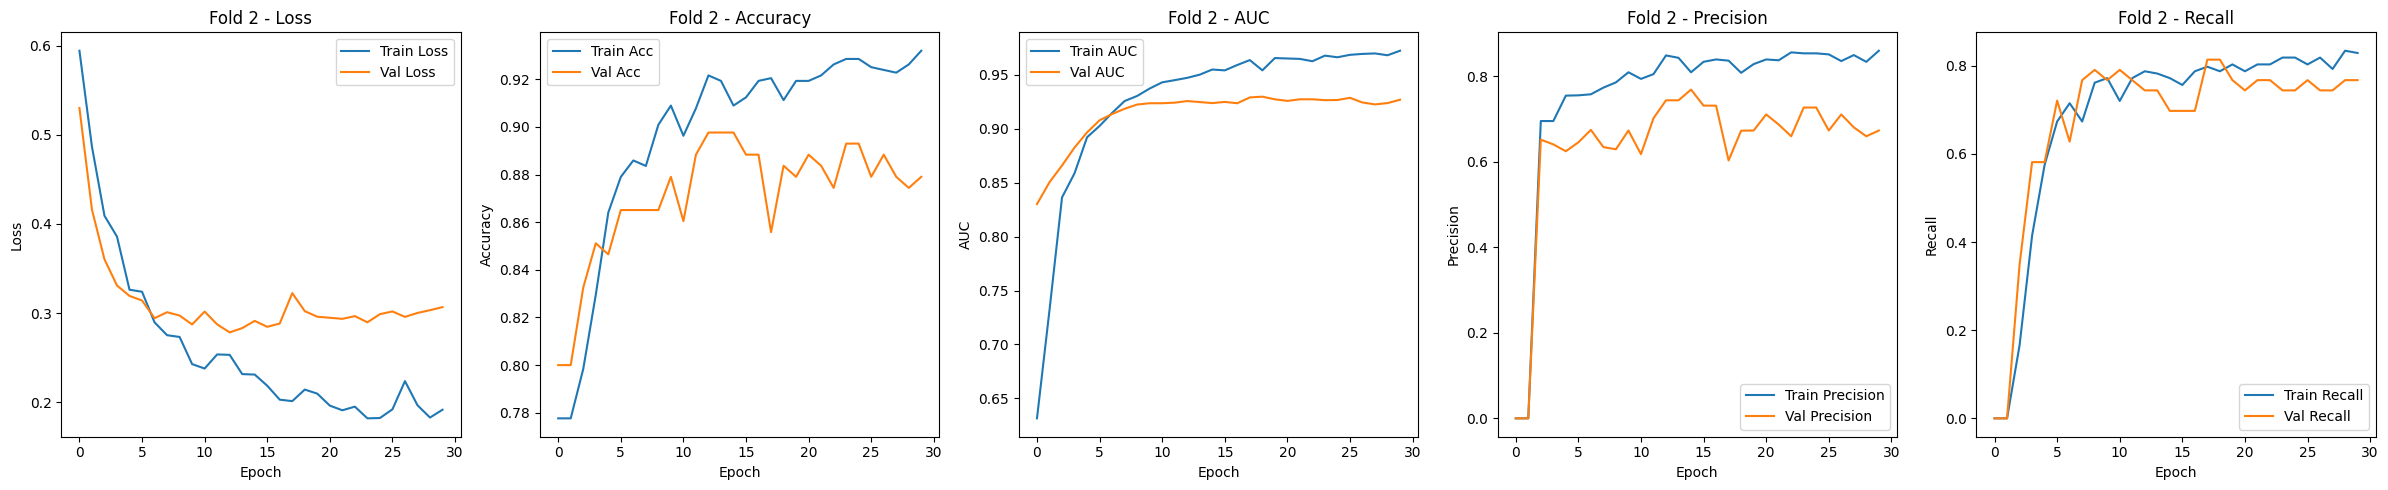

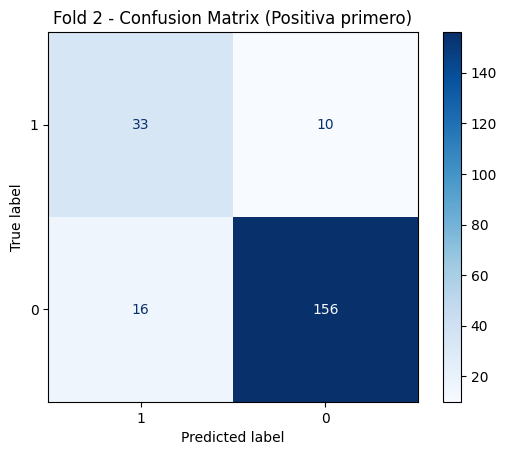


====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6555, Acc: 0.7593, AUC: 0.5523, Prec: 0.3269, Rec: 0.0899 | Val Loss: 0.5852, Acc: 0.7892, AUC: 0.8534, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.5081, Acc: 0.7802, AUC: 0.6498, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4561, Acc: 0.7892, AUC: 0.8679, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.4361, Acc: 0.7837, AUC: 0.8367, Prec: 0.8000, Rec: 0.0212 | Val Loss: 0.3870, Acc: 0.8072, AUC: 0.8771, Prec: 0.6667, Rec: 0.1702
Epoch 04: Train Loss: 0.3777, Acc: 0.8291, AUC: 0.8614, Prec: 0.7500, Rec: 0.3333 | Val Loss: 0.3365, Acc: 0.8700, AUC: 0.8832, Prec: 0.6875, Rec: 0.7021
Epoch 05: Train Loss: 0.3407, Acc: 0.8570, AUC: 0.8872, Prec: 0.7200, Rec: 0.5714 | Val Loss: 0.3131, Acc: 0.8789, AUC: 0.8876, Prec: 0.7273, Rec: 0.6809
Epoch 06: Train Loss: 0.3200, Acc: 0.8593, AUC: 0.8988, Prec: 0.7152, Rec: 0.5979 | Val Loss: 0.3041, Acc: 0.8789, AUC: 0.8952, Prec: 0.7000, Rec: 0.7447
Epoch 07: Train Loss: 0.3039, Acc: 0.8860, AUC: 0.9095, Prec: 0.7661, Rec: 0.6931 | Val Loss: 0.2952, Acc: 0.8834, AUC: 0.8988, Prec: 0.7692, Rec: 0.6383
Epoch 08: Train Loss: 0.2785, Acc: 0.8919, AUC: 0.9231, Prec: 0.7963, Rec: 0

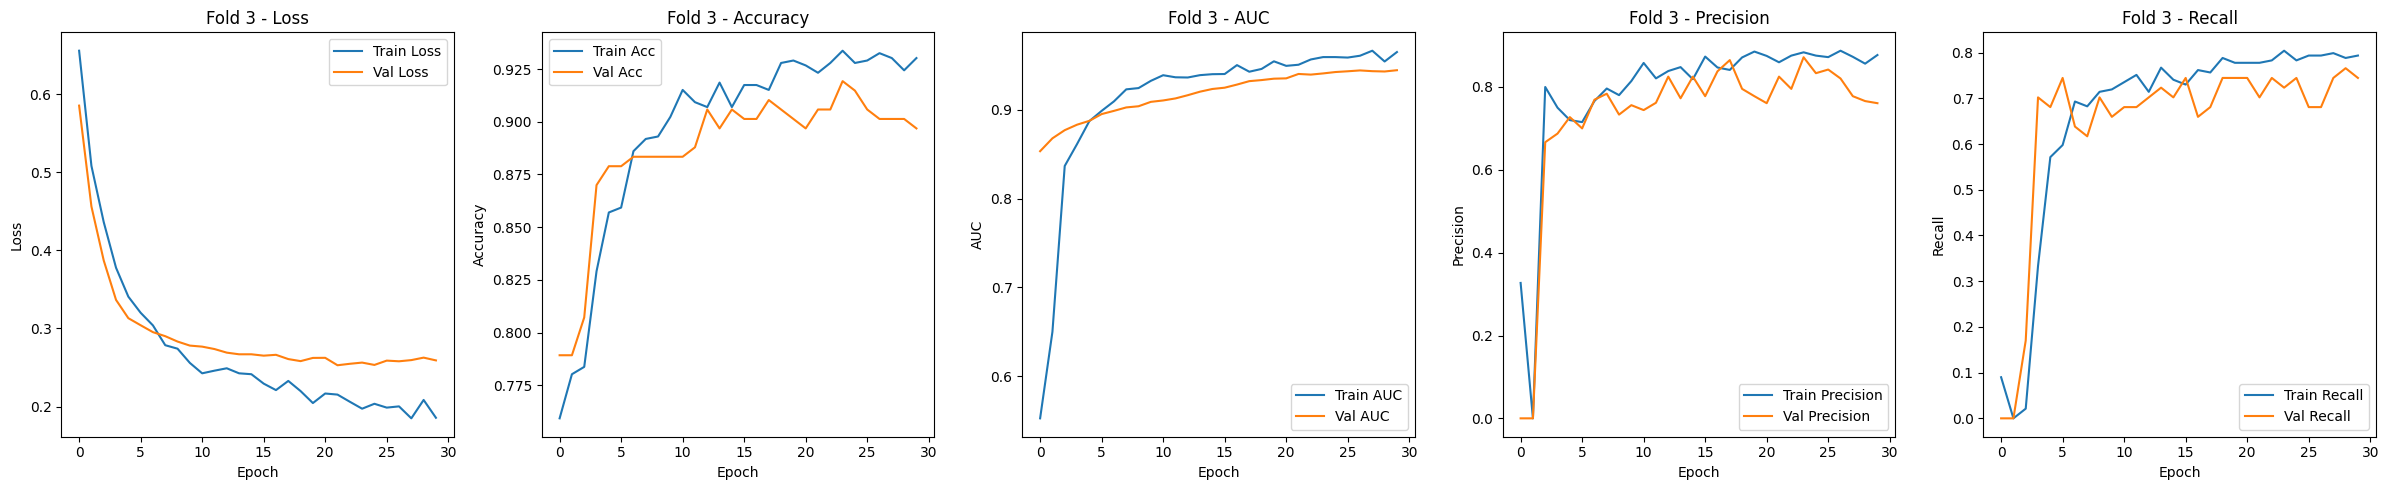

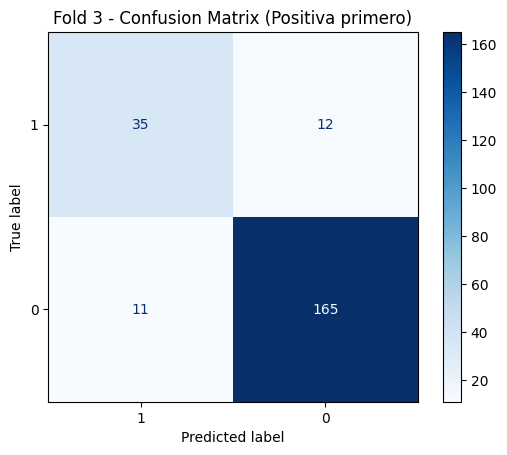


====== Fold 4 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6151, Acc: 0.7125, AUC: 0.4916, Prec: 0.0658, Rec: 0.0270 | Val Loss: 0.5311, Acc: 0.7571, AUC: 0.7859, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4650, Acc: 0.7881, AUC: 0.7602, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4777, Acc: 0.7571, AUC: 0.8108, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.3991, Acc: 0.7835, AUC: 0.8623, Prec: 0.1667, Rec: 0.0054 | Val Loss: 0.4556, Acc: 0.7762, AUC: 0.8290, Prec: 1.0000, Rec: 0.0784
Epoch 04: Train Loss: 0.3620, Acc: 0.8247, AUC: 0.8761, Prec: 0.6633, Rec: 0.3514 | Val Loss: 0.4536, Acc: 0.8190, AUC: 0.8556, Prec: 0.9333, Rec: 0.2745
Epoch 05: Train Loss: 0.3425, Acc: 0.8522, AUC: 0.8831, Prec: 0.7059, Rec: 0.5189 | Val Loss: 0.3982, Acc: 0.8429, AUC: 0.8780, Prec: 0.9091, Rec: 0.3922
Epoch 06: Train Loss: 0.3135, Acc: 0.8694, AUC: 0.8978, Prec: 0.7152, Rec: 0.6378 | Val Loss: 0.3737, Acc: 0.8571, AUC: 0.8928, Prec: 0.8621, Rec: 0.4902
Epoch 07: Train Loss: 0.3034, Acc: 0.8694, AUC: 0.9076, Prec: 0.6983, Rec: 0.6757 | Val Loss: 0.3249, Acc: 0.8905, AUC: 0.9063, Prec: 0.8889, Rec: 0.6275
Epoch 08: Train Loss: 0.2881, Acc: 0.8717, AUC: 0.9125, Prec: 0.7017, Rec: 0

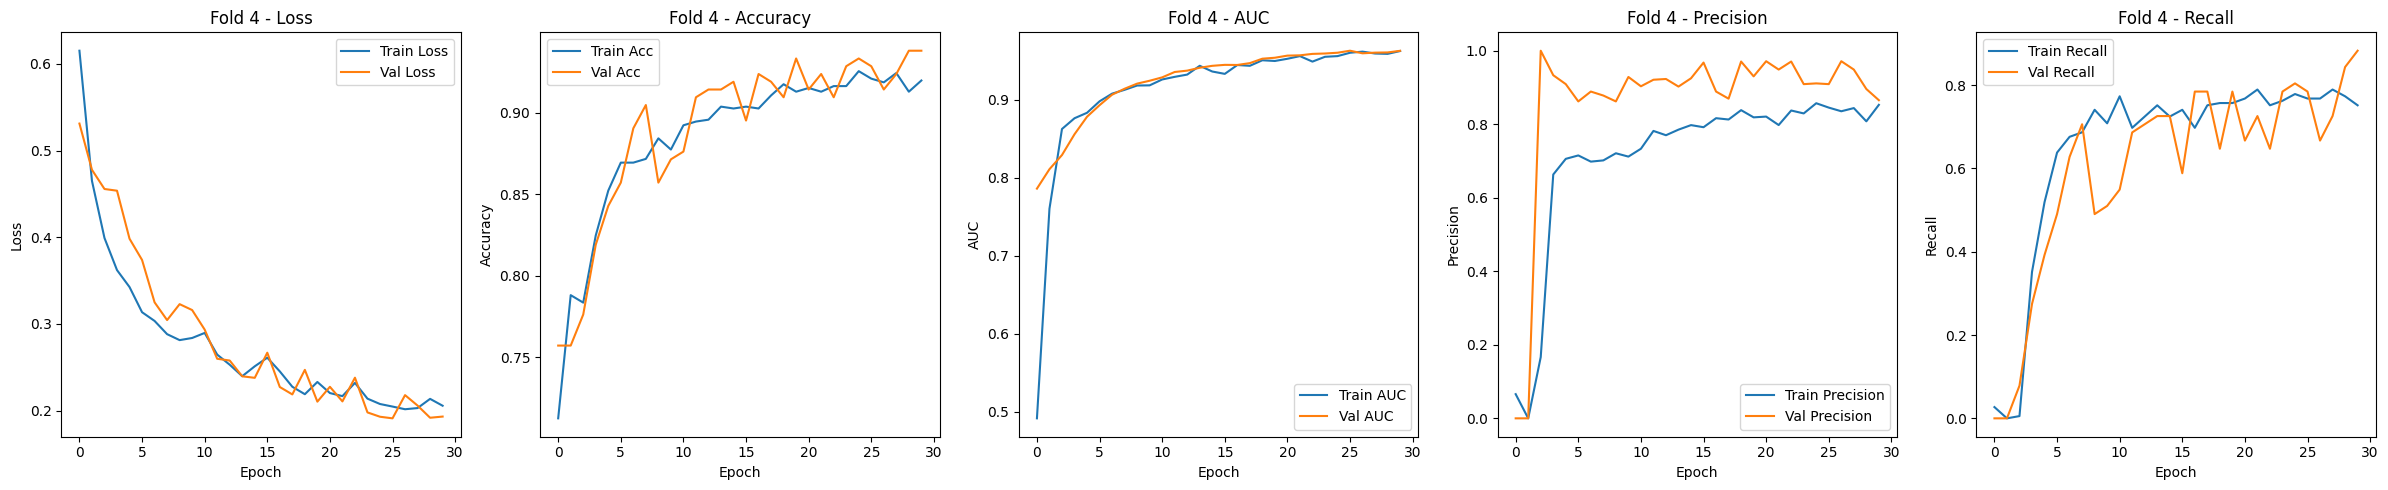

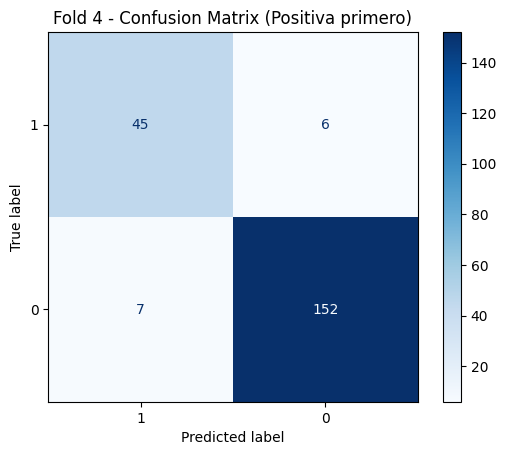


===== Resultados Finales por Fold =====
Fold 0 - Val Acc: 0.9238, AUC: 0.9426, Precision: 0.9024, Recall: 0.7551
Fold 1 - Val Acc: 0.8667, AUC: 0.9455, Precision: 0.6333, Recall: 0.8261
Fold 2 - Val Acc: 0.8791, AUC: 0.9270, Precision: 0.6735, Recall: 0.7674
Fold 3 - Val Acc: 0.8969, AUC: 0.9446, Precision: 0.7609, Recall: 0.7447
Fold 4 - Val Acc: 0.9381, AUC: 0.9625, Precision: 0.8654, Recall: 0.8824

===== Promedios Finales con Desviación Estándar =====
Val Accuracy: 0.9009 ± 0.0267
Val AUC: 0.9444 ± 0.0113
Val Precision: 0.7671 ± 0.1046
Val Recall: 0.7951 ± 0.0519


In [ ]:
for fold in range(5):
  print(f"\n====== Fold {fold} ======")

  # Preparar datos
  train_ids = kfold_data[f"train_fold_{fold}"]
  val_ids = kfold_data[f"val_fold_{fold}"]

  train_dataset = [id_to_data[i] for i in train_ids]
  val_dataset = [id_to_data[i] for i in val_ids]

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  # Inicializar modelo
  model = GCN(num_features, num_classes).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []
  train_aucs, val_aucs = [], []
  train_precisions, val_precisions = [], []
  train_recalls, val_recalls = [], []

  for epoch in range(1, num_epochs + 1):
    # ---- ENTRENAMIENTO ----
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    y_train_true = []
    y_train_prob = []
    y_train_pred = []

    for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      out = model(data.x, data.edge_index, data.batch)
      loss = criterion(out, data.y)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      pred = out.argmax(dim=1)
      correct += (pred == data.y).sum().item()
      total += data.y.size(0)

      y_train_true.append(data.y.cpu())
      y_train_prob.append(F.softmax(out, dim=1)[:, 1].detach().cpu())
      y_train_pred.append(pred.cpu())

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    y_train_true = torch.cat(y_train_true)
    y_train_prob = torch.cat(y_train_prob)
    y_train_pred = torch.cat(y_train_pred)
    train_auc = roc_auc_score(y_train_true, y_train_prob)
    train_precision = precision_score(y_train_true, y_train_pred)
    train_recall = recall_score(y_train_true, y_train_pred)

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    train_aucs.append(train_auc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)

    # ---- VALIDACIÓN ----
    model.eval()
    val_loss = 0
    correct = 0
    y_true = []
    y_prob = []
    y_pred = []

    with torch.no_grad():
      for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        val_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        y_true.append(data.y.cpu())
        y_prob.append(F.softmax(out, dim=1)[:, 1].cpu())
        y_pred.append(pred.cpu())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / len(val_loader.dataset)
    y_true = torch.cat(y_true)
    y_prob = torch.cat(y_prob)
    y_pred = torch.cat(y_pred)
    val_auc = roc_auc_score(y_true, y_prob)
    val_precision = precision_score(y_true, y_pred)
    val_recall = recall_score(y_true, y_pred)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    val_aucs.append(val_auc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, AUC: {train_auc:.4f}, "
          f"Prec: {train_precision:.4f}, Rec: {train_recall:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, AUC: {val_auc:.4f}, "
          f"Prec: {val_precision:.4f}, Rec: {val_recall:.4f}")

  # Guardar AUC y Accuracy final del fold
  all_val_accs.append(val_accuracies[-1])
  all_val_aucs.append(val_aucs[-1])
  all_val_precisions.append(val_precisions[-1])
  all_val_recalls.append(val_recalls[-1])

  # Graficar métricas por fold
  plt.figure(figsize=(24, 5))

  plt.subplot(1, 5, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.title(f'Fold {fold} - Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 5, 2)
  plt.plot(train_accuracies, label='Train Acc')
  plt.plot(val_accuracies, label='Val Acc')
  plt.title(f'Fold {fold} - Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 5, 3)
  plt.plot(train_aucs, label='Train AUC')
  plt.plot(val_aucs, label='Val AUC')
  plt.title(f'Fold {fold} - AUC')
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.legend()

  plt.subplot(1, 5, 4)
  plt.plot(train_precisions, label='Train Precision')
  plt.plot(val_precisions, label='Val Precision')
  plt.title(f'Fold {fold} - Precision')
  plt.xlabel('Epoch')
  plt.ylabel('Precision')
  plt.legend()

  plt.subplot(1, 5, 5)
  plt.plot(train_recalls, label='Train Recall')
  plt.plot(val_recalls, label='Val Recall')
  plt.title(f'Fold {fold} - Recall')
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Matriz de confusión
  cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
  disp.plot(cmap='Blues')
  plt.title(f'Fold {fold} - Confusion Matrix (Positiva primero)')
  plt.show()

# Resultados globales
print("\n===== Resultados Finales por Fold =====")
for i in range(len(all_val_accs)):
  print(f"Fold {i} - Val Acc: {all_val_accs[i]:.4f}, AUC: {all_val_aucs[i]:.4f}, "
        f"Precision: {all_val_precisions[i]:.4f}, Recall: {all_val_recalls[i]:.4f}")

# Promedios finales con desviación estándar
print("\n===== Promedios Finales con Desviación Estándar =====")
print(f"Val Accuracy: {np.mean(all_val_accs):.4f} ± {np.std(all_val_accs):.4f}")
print(f"Val AUC: {np.mean(all_val_aucs):.4f} ± {np.std(all_val_aucs):.4f}")
print(f"Val Precision: {np.mean(all_val_precisions):.4f} ± {np.std(all_val_precisions):.4f}")
print(f"Val Recall: {np.mean(all_val_recalls):.4f} ± {np.std(all_val_recalls):.4f}")

# **6. Exp3 (SAGEConv)**

In [ ]:
# Configuraciones
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30
num_classes = 2
num_features = dataset_grafos[0].x.shape[1]

# Resultados acumulados por fold
all_val_accs = []
all_val_aucs = []
all_val_precisions = []
all_val_recalls = []

In [ ]:
class GCN(nn.Module):
  def __init__(self, num_features, num_classes):
    super(GCN, self).__init__()
    self.conv1 = SAGEConv(num_features, 128)
    self.bn1 = nn.BatchNorm1d(128)
    self.conv2 = SAGEConv(128, 64)
    self.bn2 = nn.BatchNorm1d(64)
    self.lin = nn.Linear(64, num_classes)

  def forward(self, x, edge_index, batch):
    x = self.conv1(x, edge_index)
    x = self.bn1(x)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = self.bn2(x)
    x = F.relu(x)
    x = global_add_pool(x, batch)
    x = self.lin(x)
    return x


====== Fold 0 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.5395, Acc: 0.8202, AUC: 0.8397, Prec: 0.5743, Rec: 0.6203 | Val Loss: 1.8119, Acc: 0.7667, AUC: 0.8466, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.2999, Acc: 0.8969, AUC: 0.9288, Prec: 0.7709, Rec: 0.7380 | Val Loss: 1.5847, Acc: 0.7667, AUC: 0.8866, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.2208, Acc: 0.9072, AUC: 0.9522, Prec: 0.8118, Rec: 0.7380 | Val Loss: 0.3379, Acc: 0.8571, AUC: 0.9332, Prec: 0.8065, Rec: 0.5102
Epoch 04: Train Loss: 0.1584, Acc: 0.9381, AUC: 0.9757, Prec: 0.8800, Rec: 0.8235 | Val Loss: 0.3356, Acc: 0.8857, AUC: 0.9338, Prec: 0.7551, Rec: 0.7551
Epoch 05: Train Loss: 0.1267, Acc: 0.9507, AUC: 0.9842, Prec: 0.9045, Rec: 0.8610 | Val Loss: 0.2366, Acc: 0.8905, AUC: 0.9539, Prec: 0.7500, Rec: 0.7959
Epoch 06: Train Loss: 0.1310, Acc: 0.9496, AUC: 0.9836, Prec: 0.9040, Rec: 0.8556 | Val Loss: 0.2740, Acc: 0.9000, AUC: 0.9436, Prec: 0.8684, Rec: 0.6735
Epoch 07: Train Loss: 0.1213, Acc: 0.9588, AUC: 0.9853, Prec: 0.9218, Rec: 0.8824 | Val Loss: 0.3286, Acc: 0.9095, AUC: 0.9275, Prec: 0.8750, Rec: 0.7143
Epoch 08: Train Loss: 0.1234, Acc: 0.9519, AUC: 0.9879, Prec: 0.8877, Rec: 0

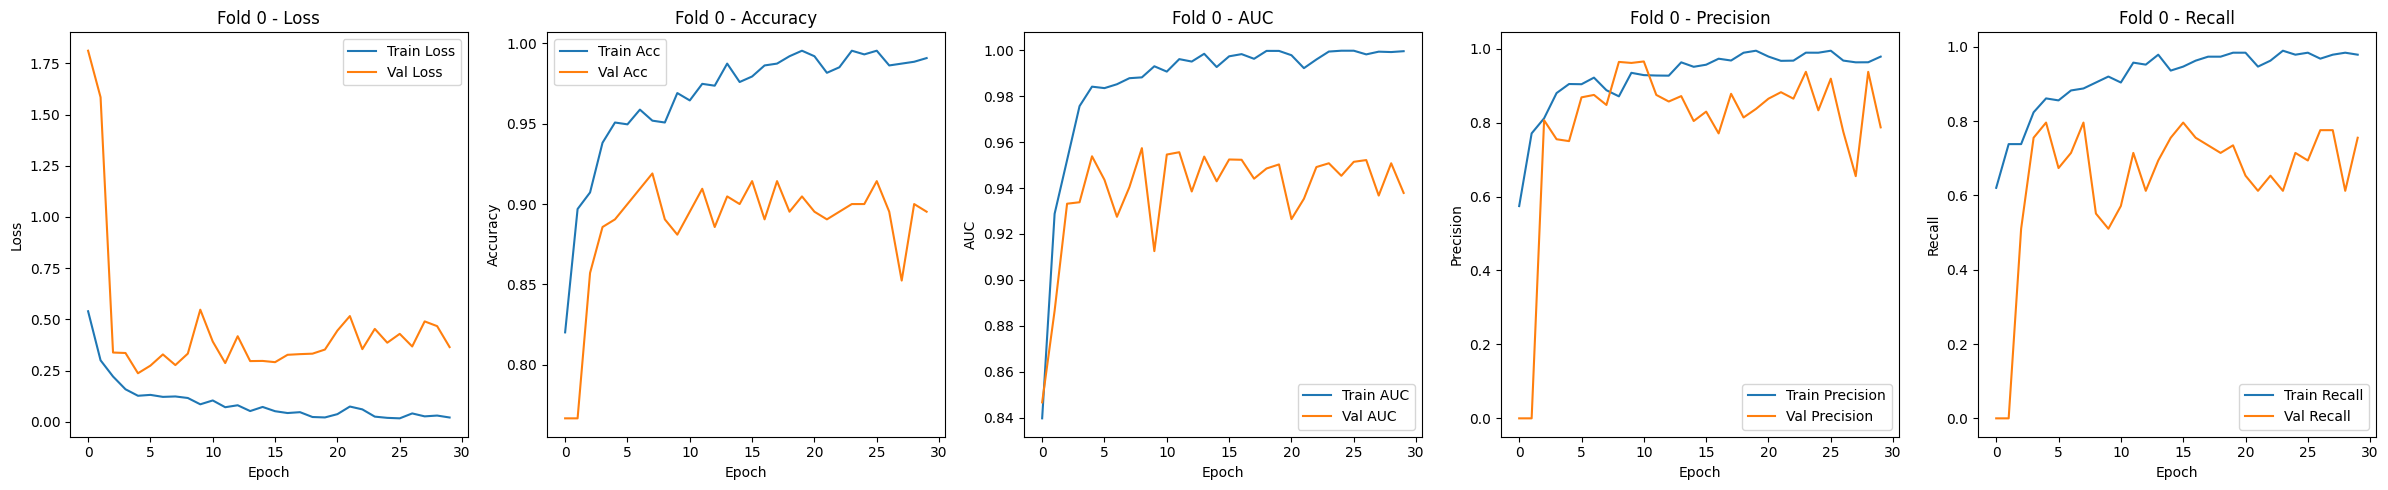

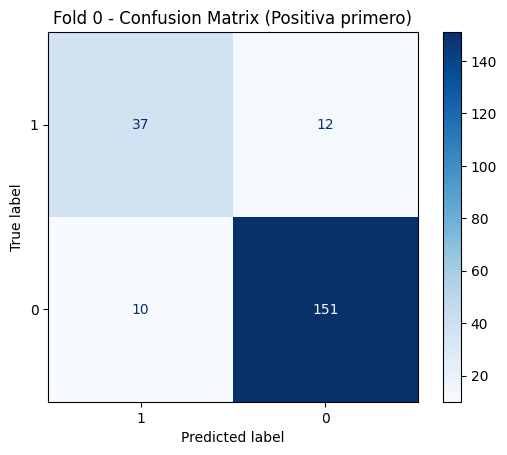


====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.5912, Acc: 0.8089, AUC: 0.8279, Prec: 0.5631, Rec: 0.6105 | Val Loss: 0.9162, Acc: 0.7956, AUC: 0.8477, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.2644, Acc: 0.8916, AUC: 0.9409, Prec: 0.7709, Rec: 0.7263 | Val Loss: 0.8929, Acc: 0.7956, AUC: 0.8776, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.2104, Acc: 0.9044, AUC: 0.9608, Prec: 0.7903, Rec: 0.7737 | Val Loss: 0.4105, Acc: 0.8222, AUC: 0.9299, Prec: 1.0000, Rec: 0.1304
Epoch 04: Train Loss: 0.1468, Acc: 0.9452, AUC: 0.9793, Prec: 0.8783, Rec: 0.8737 | Val Loss: 0.2052, Acc: 0.9067, AUC: 0.9513, Prec: 0.7660, Rec: 0.7826
Epoch 05: Train Loss: 0.1360, Acc: 0.9487, AUC: 0.9841, Prec: 0.9011, Rec: 0.8632 | Val Loss: 0.2919, Acc: 0.8889, AUC: 0.9350, Prec: 0.7442, Rec: 0.6957
Epoch 06: Train Loss: 0.1331, Acc: 0.9499, AUC: 0.9855, Prec: 0.8973, Rec: 0.8737 | Val Loss: 0.2105, Acc: 0.8889, AUC: 0.9642, Prec: 0.6780, Rec: 0.8696
Epoch 07: Train Loss: 0.0985, Acc: 0.9639, AUC: 0.9903, Prec: 0.9297, Rec: 0.9053 | Val Loss: 0.3043, Acc: 0.8889, AUC: 0.9435, Prec: 0.6981, Rec: 0.8043
Epoch 08: Train Loss: 0.0692, Acc: 0.9837, AUC: 0.9967, Prec: 0.9681, Rec: 0

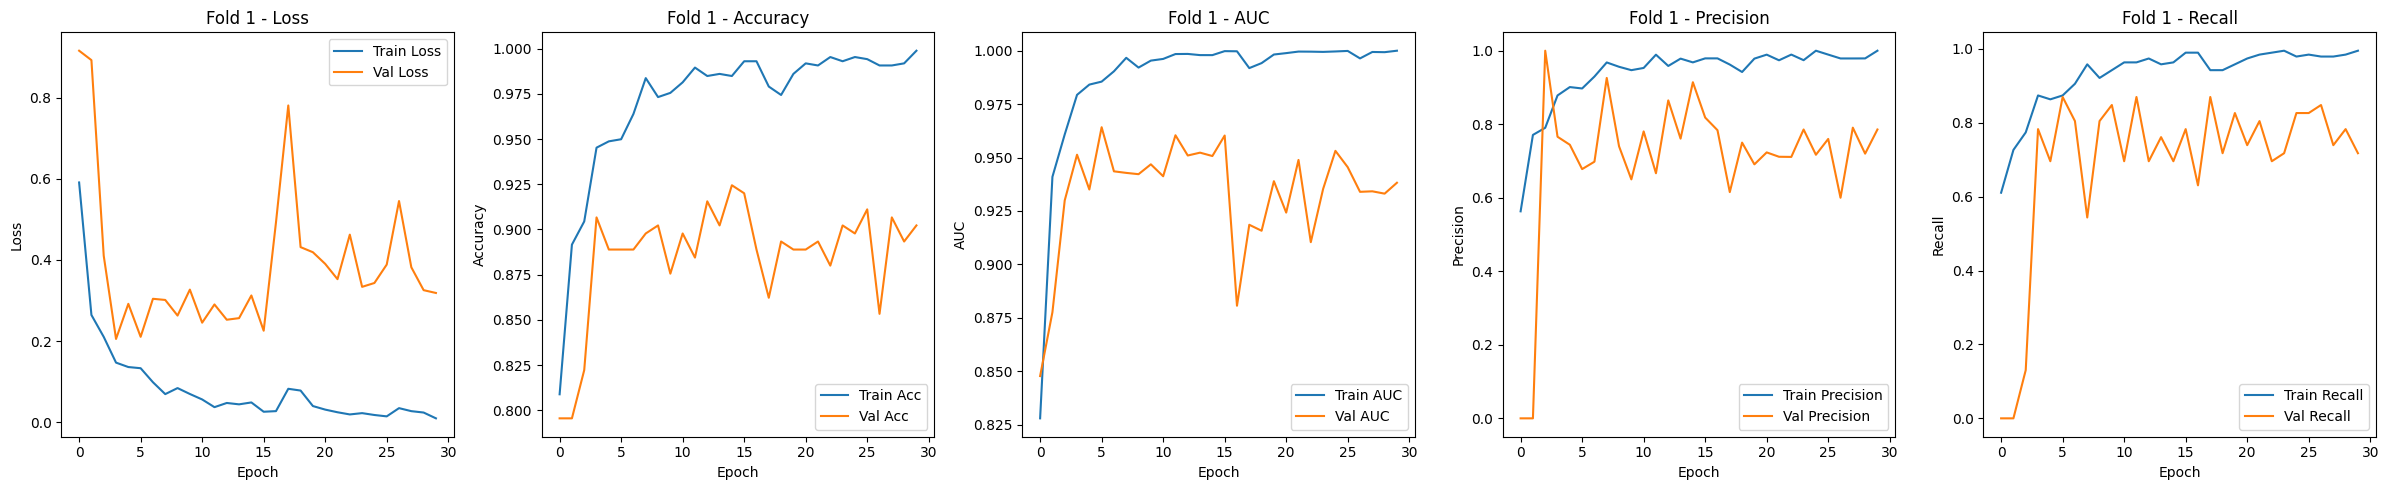

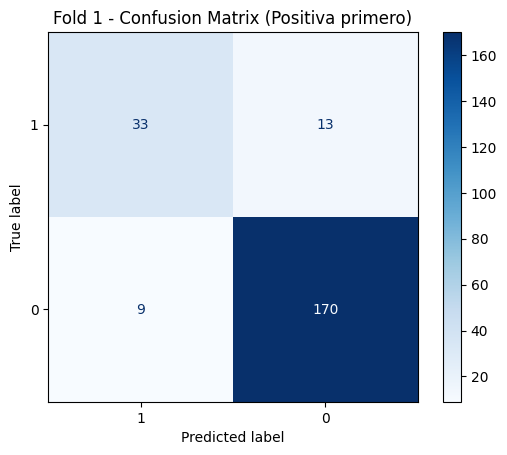


====== Fold 2 ======
Epoch 01: Train Loss: 0.6742, Acc: 0.7880, AUC: 0.8124, Prec: 0.5187, Rec: 0.6477 | Val Loss: 1.5982, Acc: 0.8000, AUC: 0.7642, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.3166, Acc: 0.8917, AUC: 0.9409, Prec: 0.7592, Rec: 0.7513 | Val Loss: 1.4493, Acc: 0.8000, AUC: 0.8242, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.1962, Acc: 0.9274, AUC: 0.9646, Prec: 0.8283, Rec: 0.8497 | Val Loss: 0.4477, Acc: 0.8465, AUC: 0.8806, Prec: 0.6786, Rec: 0.4419
Epoch 04: Train Loss: 0.2499, Acc: 0.9147, AUC: 0.9451, Prec: 0.8148, Rec: 0.7979 | Val Loss: 0.2790, Acc: 0.8791, AUC: 0.9438, Prec: 0.6545, Rec: 0.8372
Epoch 05: Train Loss: 0.1755, Acc: 0.9355, AUC: 0.9758, Prec: 0.8870, Rec: 0.8135 | Val Loss: 0.2557, Acc: 0.8651, AUC: 0.9497, Prec: 0.6207, Rec: 0.8372
Epoch 06: Train Loss: 0.1518, Acc: 0.9424, AUC: 0.9822, Prec: 0.8865, Rec: 0.8497 | Val Loss: 0.3376, Acc: 0.8744, AUC: 0.9547, Prec: 0.6290, Rec: 0.9070
Epoch 07: Train Loss: 0.1303, Acc: 0.9424, AUC: 0.9847, Prec: 0.8994, Rec: 0.8342 | Val Loss: 0.4345, Acc: 0.8279, AUC: 0.9501, Prec: 0.5417, Rec: 0.9070
Epoch 08: Train Loss: 0.1250, Acc: 0.9631, AUC: 0.9922, Prec: 0.9171, Rec: 0

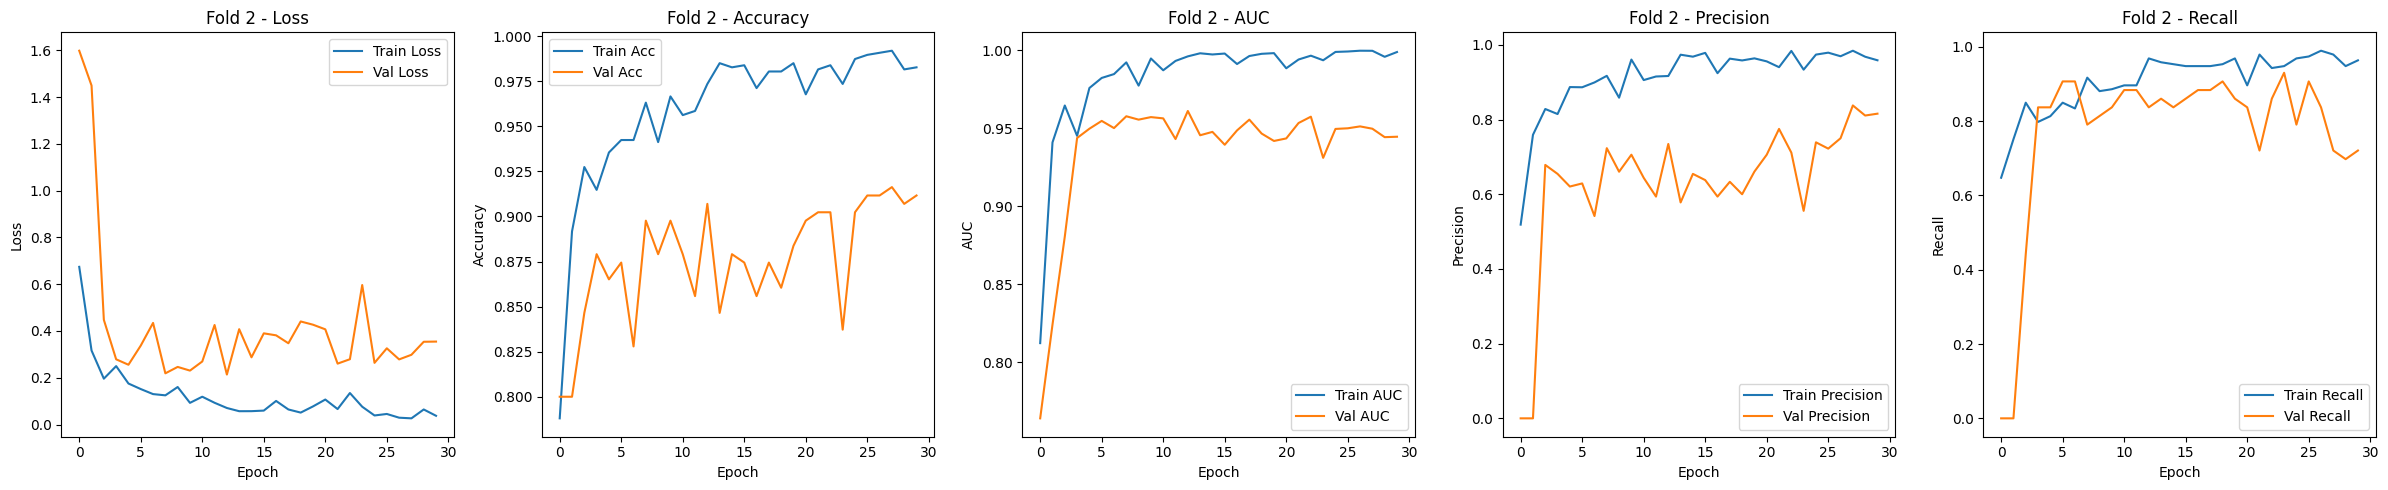

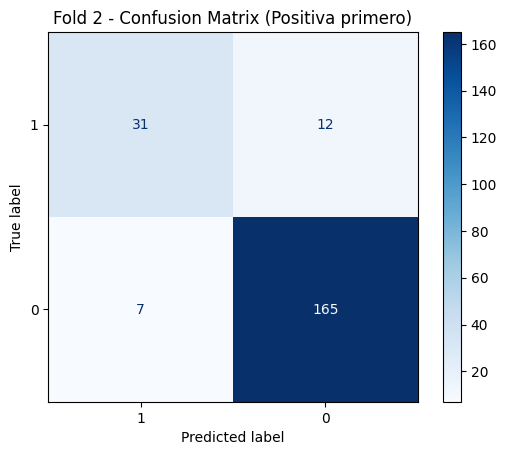


====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.5483, Acc: 0.8244, AUC: 0.8283, Prec: 0.6011, Rec: 0.5979 | Val Loss: 0.7495, Acc: 0.7892, AUC: 0.8824, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.2569, Acc: 0.9035, AUC: 0.9438, Prec: 0.8046, Rec: 0.7407 | Val Loss: 0.9199, Acc: 0.7892, AUC: 0.8952, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.2267, Acc: 0.9186, AUC: 0.9518, Prec: 0.8251, Rec: 0.7989 | Val Loss: 0.2872, Acc: 0.8700, AUC: 0.9277, Prec: 0.8000, Rec: 0.5106
Epoch 04: Train Loss: 0.1749, Acc: 0.9384, AUC: 0.9685, Prec: 0.8908, Rec: 0.8201 | Val Loss: 0.2647, Acc: 0.9058, AUC: 0.9364, Prec: 0.7708, Rec: 0.7872
Epoch 05: Train Loss: 0.2045, Acc: 0.9233, AUC: 0.9632, Prec: 0.8289, Rec: 0.8201 | Val Loss: 0.2965, Acc: 0.8969, AUC: 0.9341, Prec: 0.7857, Rec: 0.7021
Epoch 06: Train Loss: 0.1360, Acc: 0.9442, AUC: 0.9840, Prec: 0.8983, Rec: 0.8413 | Val Loss: 0.2656, Acc: 0.9058, AUC: 0.9347, Prec: 0.8250, Rec: 0.7021
Epoch 07: Train Loss: 0.1197, Acc: 0.9570, AUC: 0.9853, Prec: 0.9318, Rec: 0.8677 | Val Loss: 0.3220, Acc: 0.8879, AUC: 0.9463, Prec: 0.6897, Rec: 0.8511
Epoch 08: Train Loss: 0.1076, Acc: 0.9628, AUC: 0.9892, Prec: 0.9153, Rec: 0

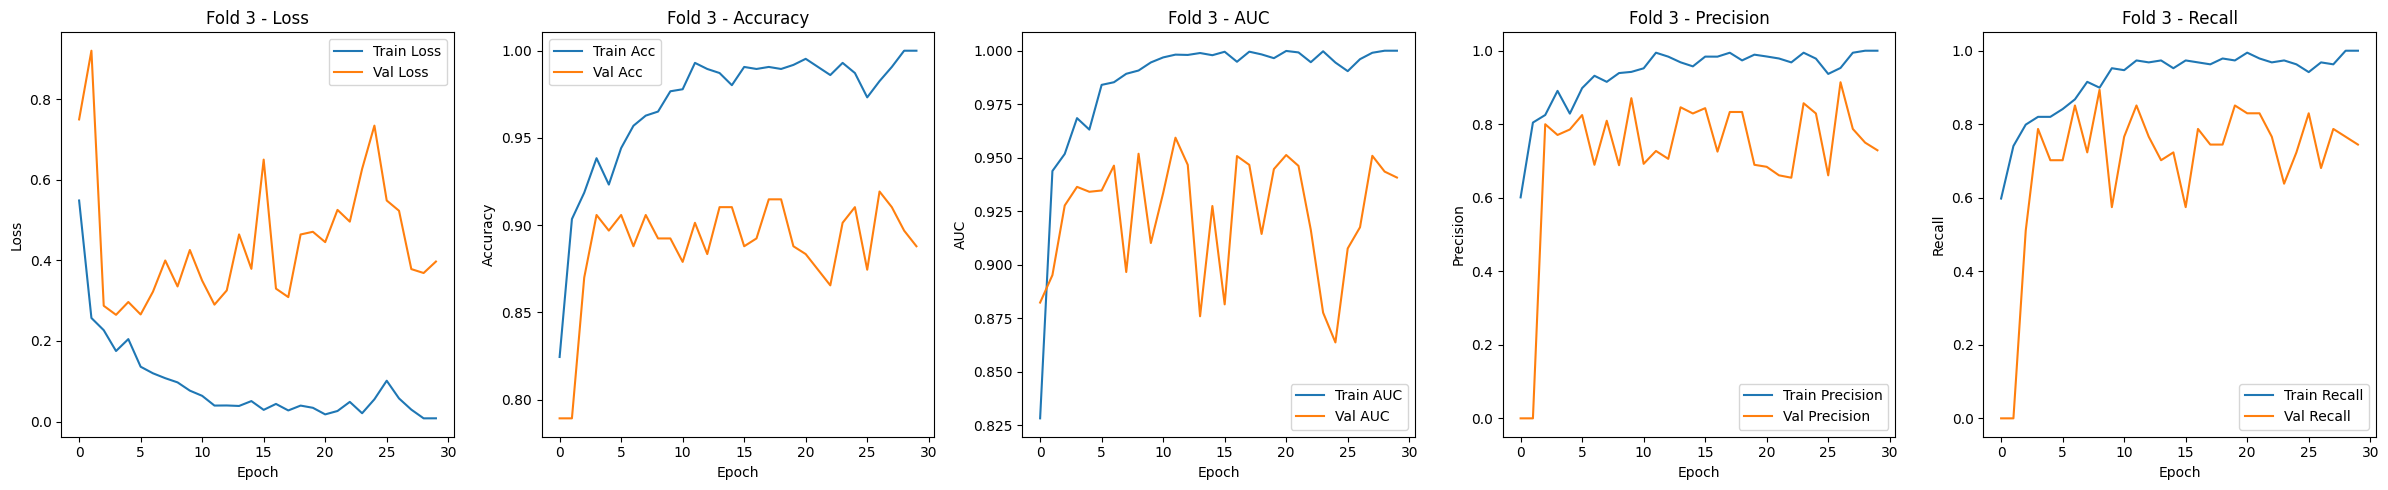

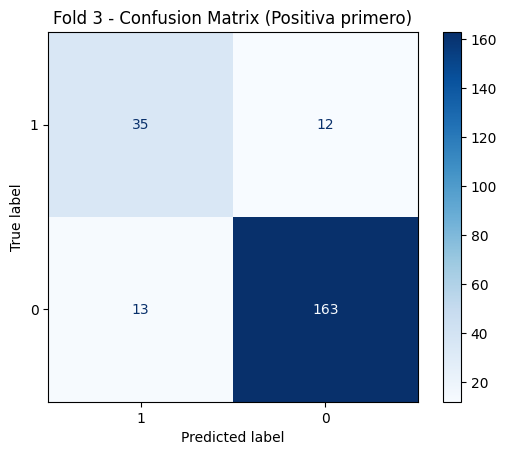


====== Fold 4 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.5243, Acc: 0.8328, AUC: 0.8363, Prec: 0.6127, Rec: 0.5730 | Val Loss: 0.9728, Acc: 0.7571, AUC: 0.8663, Prec: 0.0000, Rec: 0.0000
Epoch 02: Train Loss: 0.2917, Acc: 0.8797, AUC: 0.9316, Prec: 0.7198, Rec: 0.7081 | Val Loss: 1.0123, Acc: 0.7571, AUC: 0.8452, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.2235, Acc: 0.8981, AUC: 0.9548, Prec: 0.7609, Rec: 0.7568 | Val Loss: 0.3314, Acc: 0.8571, AUC: 0.9353, Prec: 0.9200, Rec: 0.4510
Epoch 04: Train Loss: 0.1813, Acc: 0.9221, AUC: 0.9691, Prec: 0.8343, Rec: 0.7892 | Val Loss: 0.2006, Acc: 0.9333, AUC: 0.9660, Prec: 0.9744, Rec: 0.7451
Epoch 05: Train Loss: 0.1388, Acc: 0.9427, AUC: 0.9838, Prec: 0.8729, Rec: 0.8541 | Val Loss: 0.1865, Acc: 0.9048, AUC: 0.9713, Prec: 0.7925, Rec: 0.8235
Epoch 06: Train Loss: 0.1522, Acc: 0.9427, AUC: 0.9787, Prec: 0.8571, Rec: 0.8757 | Val Loss: 0.2592, Acc: 0.8571, AUC: 0.9449, Prec: 0.7442, Rec: 0.6275
Epoch 07: Train Loss: 0.1346, Acc: 0.9530, AUC: 0.9833, Prec: 0.8956, Rec: 0

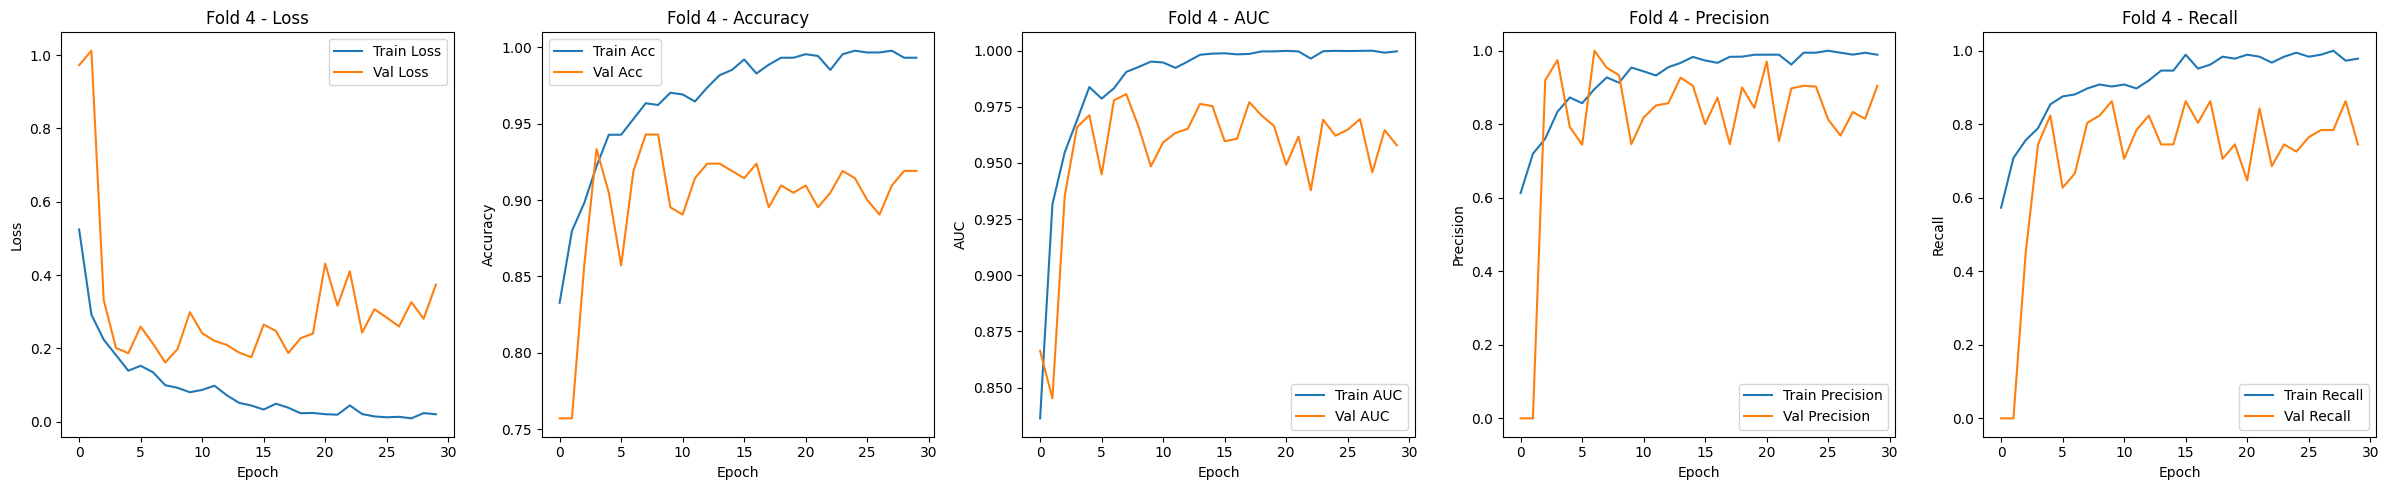

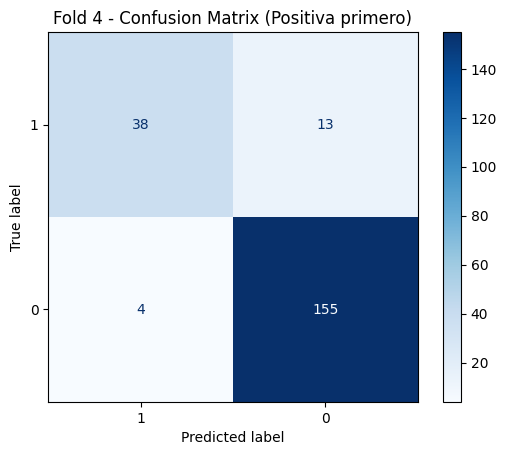


===== Resultados Finales por Fold =====
Fold 0 - Val Acc: 0.8952, AUC: 0.9379, Precision: 0.7872, Recall: 0.7551
Fold 1 - Val Acc: 0.9022, AUC: 0.9382, Precision: 0.7857, Recall: 0.7174
Fold 2 - Val Acc: 0.9116, AUC: 0.9446, Precision: 0.8158, Recall: 0.7209
Fold 3 - Val Acc: 0.8879, AUC: 0.9408, Precision: 0.7292, Recall: 0.7447
Fold 4 - Val Acc: 0.9190, AUC: 0.9578, Precision: 0.9048, Recall: 0.7451

===== Promedios Finales con Desviación Estándar =====
Val Accuracy: 0.9032 ± 0.0111
Val AUC: 0.9438 ± 0.0074
Val Precision: 0.8045 ± 0.0575
Val Recall: 0.7366 ± 0.0148


In [ ]:
for fold in range(5):
  print(f"\n====== Fold {fold} ======")

  # Preparar datos
  train_ids = kfold_data[f"train_fold_{fold}"]
  val_ids = kfold_data[f"val_fold_{fold}"]

  train_dataset = [id_to_data[i] for i in train_ids]
  val_dataset = [id_to_data[i] for i in val_ids]

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  # Inicializar modelo
  model = GCN(num_features, num_classes).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []
  train_aucs, val_aucs = [], []
  train_precisions, val_precisions = [], []
  train_recalls, val_recalls = [], []

  for epoch in range(1, num_epochs + 1):
    # ---- ENTRENAMIENTO ----
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    y_train_true = []
    y_train_prob = []
    y_train_pred = []

    for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      out = model(data.x, data.edge_index, data.batch)
      loss = criterion(out, data.y)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      pred = out.argmax(dim=1)
      correct += (pred == data.y).sum().item()
      total += data.y.size(0)

      y_train_true.append(data.y.cpu())
      y_train_prob.append(F.softmax(out, dim=1)[:, 1].detach().cpu())
      y_train_pred.append(pred.cpu())

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    y_train_true = torch.cat(y_train_true)
    y_train_prob = torch.cat(y_train_prob)
    y_train_pred = torch.cat(y_train_pred)
    train_auc = roc_auc_score(y_train_true, y_train_prob)
    train_precision = precision_score(y_train_true, y_train_pred)
    train_recall = recall_score(y_train_true, y_train_pred)

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    train_aucs.append(train_auc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)

    # ---- VALIDACIÓN ----
    model.eval()
    val_loss = 0
    correct = 0
    y_true = []
    y_prob = []
    y_pred = []

    with torch.no_grad():
      for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        val_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        y_true.append(data.y.cpu())
        y_prob.append(F.softmax(out, dim=1)[:, 1].cpu())
        y_pred.append(pred.cpu())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / len(val_loader.dataset)
    y_true = torch.cat(y_true)
    y_prob = torch.cat(y_prob)
    y_pred = torch.cat(y_pred)
    val_auc = roc_auc_score(y_true, y_prob)
    val_precision = precision_score(y_true, y_pred)
    val_recall = recall_score(y_true, y_pred)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    val_aucs.append(val_auc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, AUC: {train_auc:.4f}, "
          f"Prec: {train_precision:.4f}, Rec: {train_recall:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, AUC: {val_auc:.4f}, "
          f"Prec: {val_precision:.4f}, Rec: {val_recall:.4f}")

  # Guardar AUC y Accuracy final del fold
  all_val_accs.append(val_accuracies[-1])
  all_val_aucs.append(val_aucs[-1])
  all_val_precisions.append(val_precisions[-1])
  all_val_recalls.append(val_recalls[-1])

  # Graficar métricas por fold
  plt.figure(figsize=(24, 5))

  plt.subplot(1, 5, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.title(f'Fold {fold} - Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 5, 2)
  plt.plot(train_accuracies, label='Train Acc')
  plt.plot(val_accuracies, label='Val Acc')
  plt.title(f'Fold {fold} - Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 5, 3)
  plt.plot(train_aucs, label='Train AUC')
  plt.plot(val_aucs, label='Val AUC')
  plt.title(f'Fold {fold} - AUC')
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.legend()

  plt.subplot(1, 5, 4)
  plt.plot(train_precisions, label='Train Precision')
  plt.plot(val_precisions, label='Val Precision')
  plt.title(f'Fold {fold} - Precision')
  plt.xlabel('Epoch')
  plt.ylabel('Precision')
  plt.legend()

  plt.subplot(1, 5, 5)
  plt.plot(train_recalls, label='Train Recall')
  plt.plot(val_recalls, label='Val Recall')
  plt.title(f'Fold {fold} - Recall')
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Matriz de confusión
  cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
  disp.plot(cmap='Blues')
  plt.title(f'Fold {fold} - Confusion Matrix (Positiva primero)')
  plt.show()

# Resultados globales
print("\n===== Resultados Finales por Fold =====")
for i in range(len(all_val_accs)):
  print(f"Fold {i} - Val Acc: {all_val_accs[i]:.4f}, AUC: {all_val_aucs[i]:.4f}, "
        f"Precision: {all_val_precisions[i]:.4f}, Recall: {all_val_recalls[i]:.4f}")

# Promedios finales con desviación estándar
print("\n===== Promedios Finales con Desviación Estándar =====")
print(f"Val Accuracy: {np.mean(all_val_accs):.4f} ± {np.std(all_val_accs):.4f}")
print(f"Val AUC: {np.mean(all_val_aucs):.4f} ± {np.std(all_val_aucs):.4f}")
print(f"Val Precision: {np.mean(all_val_precisions):.4f} ± {np.std(all_val_precisions):.4f}")
print(f"Val Recall: {np.mean(all_val_recalls):.4f} ± {np.std(all_val_recalls):.4f}")

# **7. Exp4 (GATConv - 2 capas)**

In [ ]:
# Configuraciones
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30
num_classes = 2
num_features = dataset_grafos[0].x.shape[1]

# Resultados acumulados por fold
all_val_accs = []
all_val_aucs = []
all_val_precisions = []
all_val_recalls = []

In [ ]:
class GAT(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_features, 128, heads=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = GATConv(128, 64, heads=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(p=0.5)
        self.lin = nn.Linear(64, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = global_max_pool(x, batch)
        x = self.lin(x)
        return x


====== Fold 0 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6219, Acc: 0.6770, AUC: 0.6823, Prec: 0.3411, Rec: 0.5455 | Val Loss: 0.5983, Acc: 0.7667, AUC: 0.8568, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.3915, Acc: 0.8305, AUC: 0.8390, Prec: 0.6423, Rec: 0.4706 | Val Loss: 0.5219, Acc: 0.7667, AUC: 0.8604, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.3383, Acc: 0.8534, AUC: 0.8788, Prec: 0.7153, Rec: 0.5241 | Val Loss: 0.4457, Acc: 0.8476, AUC: 0.9056, Prec: 0.8696, Rec: 0.4082
Epoch 04: Train Loss: 0.3192, Acc: 0.8694, AUC: 0.8890, Prec: 0.7626, Rec: 0.5668 | Val Loss: 0.3777, Acc: 0.8667, AUC: 0.9182, Prec: 0.7333, Rec: 0.6735
Epoch 05: Train Loss: 0.3134, Acc: 0.8614, AUC: 0.8985, Prec: 0.6897, Rec: 0.6417 | Val Loss: 0.3522, Acc: 0.8857, AUC: 0.9224, Prec: 0.7907, Rec: 0.6939
Epoch 06: Train Loss: 0.2923, Acc: 0.8717, AUC: 0.9135, Prec: 0.7301, Rec: 0.6364 | Val Loss: 0.3720, Acc: 0.9095, AUC: 0.9223, Prec: 0.8750, Rec: 0.7143
Epoch 07: Train Loss: 0.2739, Acc: 0.8797, AUC: 0.9255, Prec: 0.7562, Rec: 0.6471 | Val Loss: 0.3507, Acc: 0.9095, AUC: 0.9253, Prec: 0.8571, Rec: 0.7347
Epoch 08: Train Loss: 0.2576, Acc: 0.8958, AUC: 0.9338, Prec: 0.7857, Rec: 0

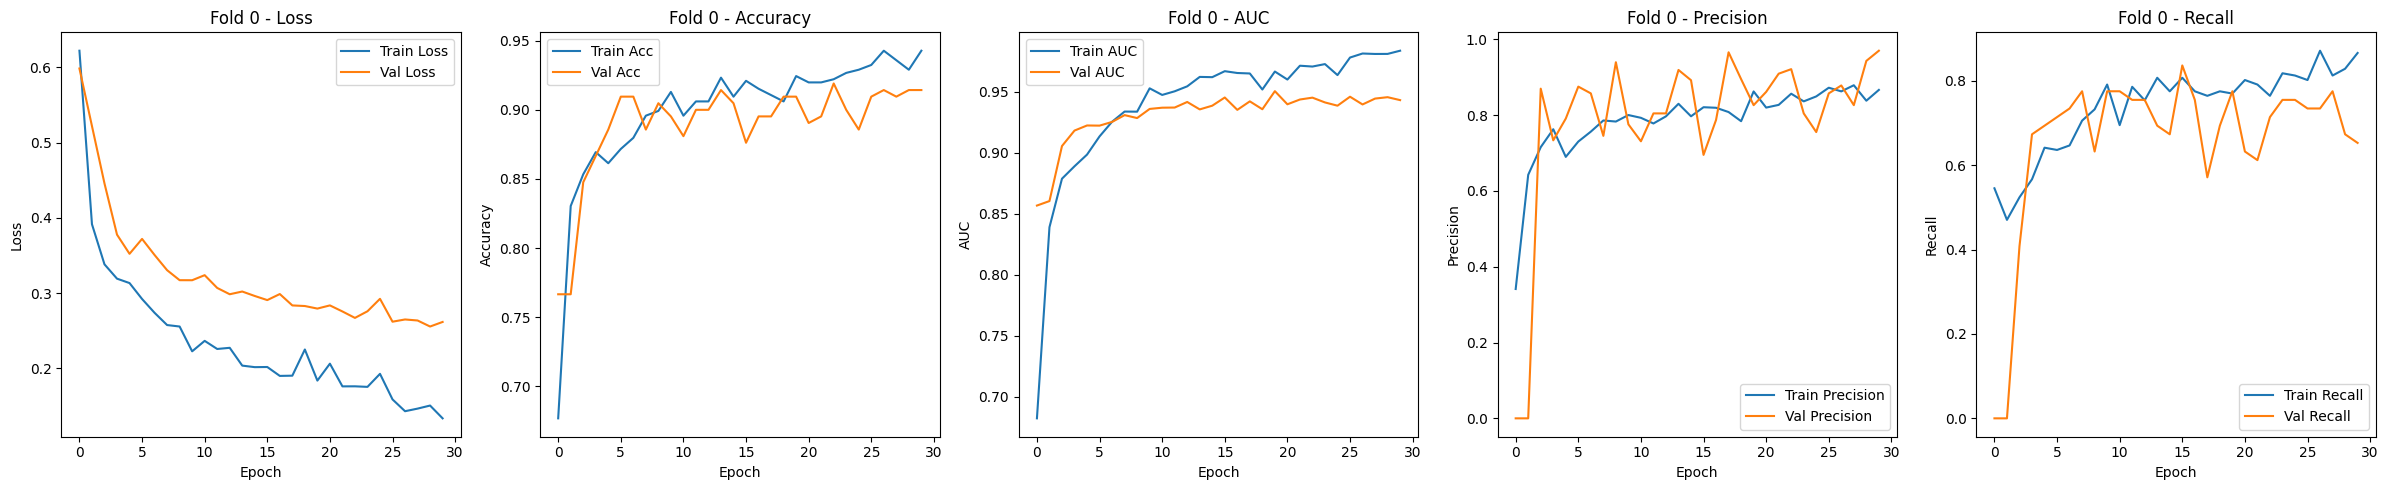

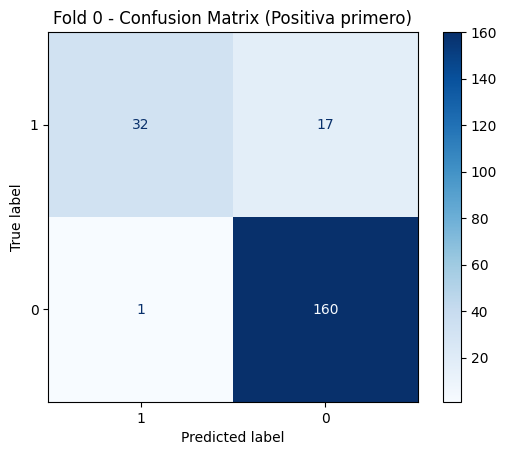


====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.5254, Acc: 0.7809, AUC: 0.7301, Prec: 0.5056, Rec: 0.4789 | Val Loss: 0.4966, Acc: 0.7956, AUC: 0.8863, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.3850, Acc: 0.8555, AUC: 0.8470, Prec: 0.7463, Rec: 0.5263 | Val Loss: 0.4323, Acc: 0.7956, AUC: 0.8794, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.3642, Acc: 0.8415, AUC: 0.8706, Prec: 0.6709, Rec: 0.5579 | Val Loss: 0.4063, Acc: 0.8489, AUC: 0.9100, Prec: 0.8333, Rec: 0.3261
Epoch 04: Train Loss: 0.3160, Acc: 0.8613, AUC: 0.9005, Prec: 0.7483, Rec: 0.5632 | Val Loss: 0.3913, Acc: 0.8711, AUC: 0.9314, Prec: 0.6977, Rec: 0.6522
Epoch 05: Train Loss: 0.3071, Acc: 0.8625, AUC: 0.9076, Prec: 0.7222, Rec: 0.6158 | Val Loss: 0.3654, Acc: 0.8933, AUC: 0.9211, Prec: 0.7750, Rec: 0.6739
Epoch 06: Train Loss: 0.2828, Acc: 0.8893, AUC: 0.9239, Prec: 0.7654, Rec: 0.7211 | Val Loss: 0.3894, Acc: 0.8533, AUC: 0.9331, Prec: 0.6102, Rec: 0.7826
Epoch 07: Train Loss: 0.2614, Acc: 0.8904, AUC: 0.9383, Prec: 0.7963, Rec: 0.6789 | Val Loss: 0.3609, Acc: 0.8844, AUC: 0.9438, Prec: 0.7083, Rec: 0.7391
Epoch 08: Train Loss: 0.2576, Acc: 0.8963, AUC: 0.9362, Prec: 0.8098, Rec: 0

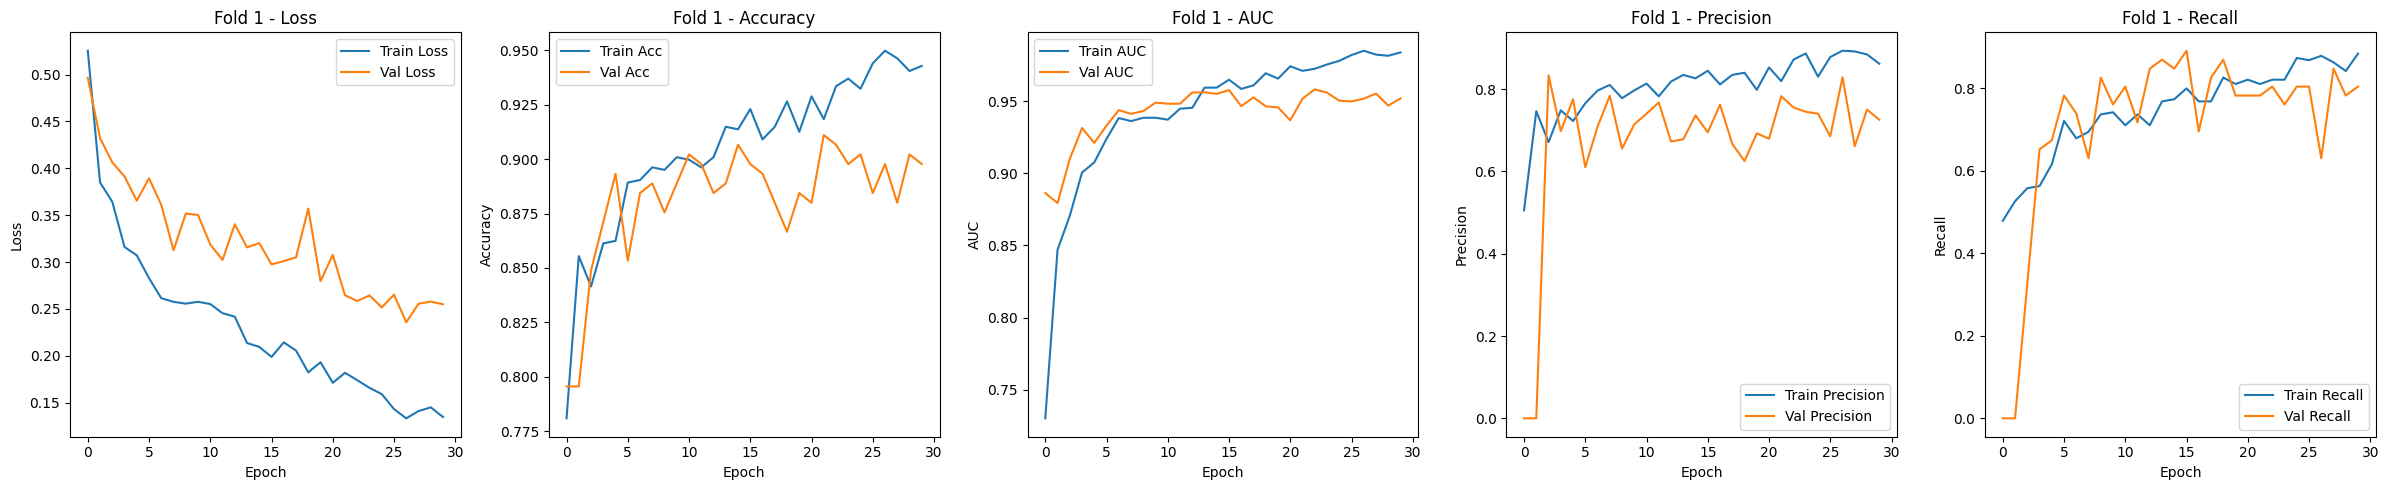

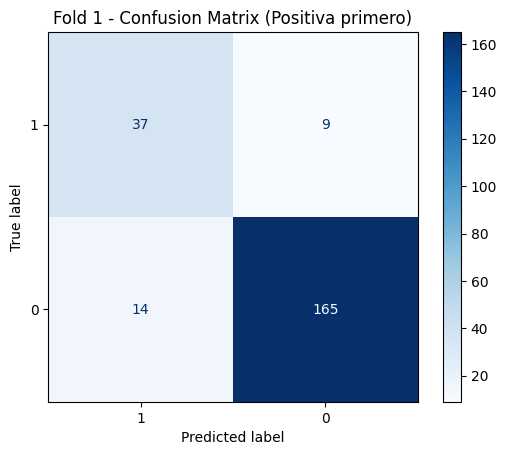


====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.5636, Acc: 0.7339, AUC: 0.7269, Prec: 0.4240, Rec: 0.5492 | Val Loss: 0.5009, Acc: 0.8000, AUC: 0.8491, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.3575, Acc: 0.8629, AUC: 0.8783, Prec: 0.7606, Rec: 0.5596 | Val Loss: 0.4590, Acc: 0.8000, AUC: 0.8376, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.3466, Acc: 0.8583, AUC: 0.8752, Prec: 0.7431, Rec: 0.5544 | Val Loss: 0.4102, Acc: 0.8419, AUC: 0.8798, Prec: 0.6286, Rec: 0.5116
Epoch 04: Train Loss: 0.3089, Acc: 0.8733, AUC: 0.8956, Prec: 0.7546, Rec: 0.6373 | Val Loss: 0.4172, Acc: 0.8419, AUC: 0.9083, Prec: 0.5818, Rec: 0.7442
Epoch 05: Train Loss: 0.2784, Acc: 0.8813, AUC: 0.9246, Prec: 0.7500, Rec: 0.6995 | Val Loss: 0.4036, Acc: 0.8558, AUC: 0.9136, Prec: 0.6154, Rec: 0.7442
Epoch 06: Train Loss: 0.3325, Acc: 0.8906, AUC: 0.9262, Prec: 0.7917, Rec: 0.6891 | Val Loss: 0.3722, Acc: 0.8512, AUC: 0.9110, Prec: 0.6078, Rec: 0.7209
Epoch 07: Train Loss: 0.3112, Acc: 0.8779, AUC: 0.9226, Prec: 0.7351, Rec: 0.7047 | Val Loss: 0.4049, Acc: 0.8512, AUC: 0.9114, Prec: 0.6038, Rec: 0.7442
Epoch 08: Train Loss: 0.2765, Acc: 0.8963, AUC: 0.9425, Prec: 0.7588, Rec: 0

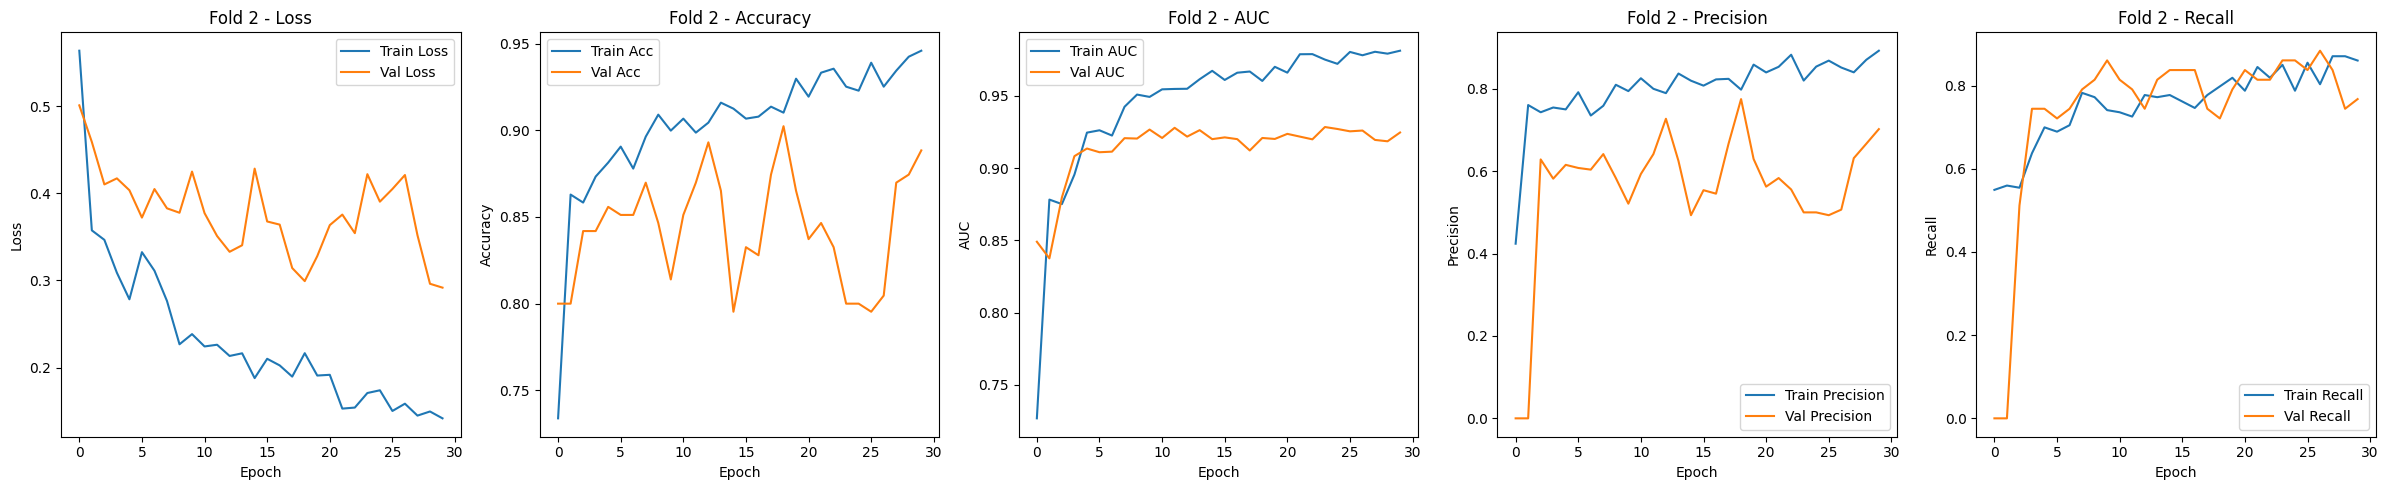

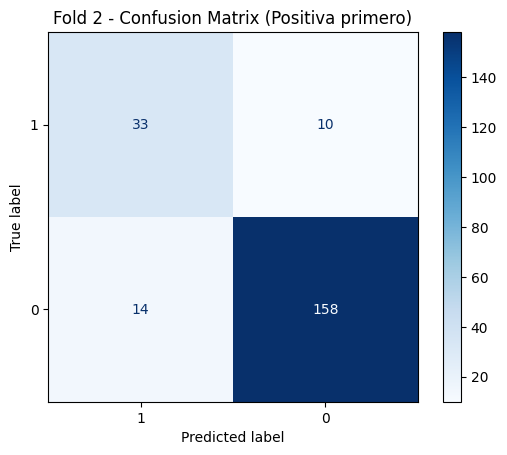


====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.5150, Acc: 0.7779, AUC: 0.7417, Prec: 0.4943, Rec: 0.4603 | Val Loss: 0.5713, Acc: 0.7892, AUC: 0.8732, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.3624, Acc: 0.8442, AUC: 0.8671, Prec: 0.7037, Rec: 0.5026 | Val Loss: 0.4776, Acc: 0.7892, AUC: 0.8937, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.3264, Acc: 0.8581, AUC: 0.9010, Prec: 0.6914, Rec: 0.6402 | Val Loss: 0.4041, Acc: 0.8430, AUC: 0.9319, Prec: 0.7308, Rec: 0.4043
Epoch 04: Train Loss: 0.3058, Acc: 0.8651, AUC: 0.9083, Prec: 0.7355, Rec: 0.6032 | Val Loss: 0.3801, Acc: 0.8655, AUC: 0.9373, Prec: 0.6349, Rec: 0.8511
Epoch 05: Train Loss: 0.2763, Acc: 0.8837, AUC: 0.9282, Prec: 0.7764, Rec: 0.6614 | Val Loss: 0.3289, Acc: 0.8834, AUC: 0.9376, Prec: 0.7333, Rec: 0.7021
Epoch 06: Train Loss: 0.2555, Acc: 0.8965, AUC: 0.9356, Prec: 0.7976, Rec: 0.7090 | Val Loss: 0.3531, Acc: 0.8700, AUC: 0.9451, Prec: 0.6667, Rec: 0.7660
Epoch 07: Train Loss: 0.2491, Acc: 0.8965, AUC: 0.9404, Prec: 0.7841, Rec: 0.7302 | Val Loss: 0.3432, Acc: 0.8744, AUC: 0.9481, Prec: 0.6557, Rec: 0.8511
Epoch 08: Train Loss: 0.2522, Acc: 0.8988, AUC: 0.9410, Prec: 0.7931, Rec: 0

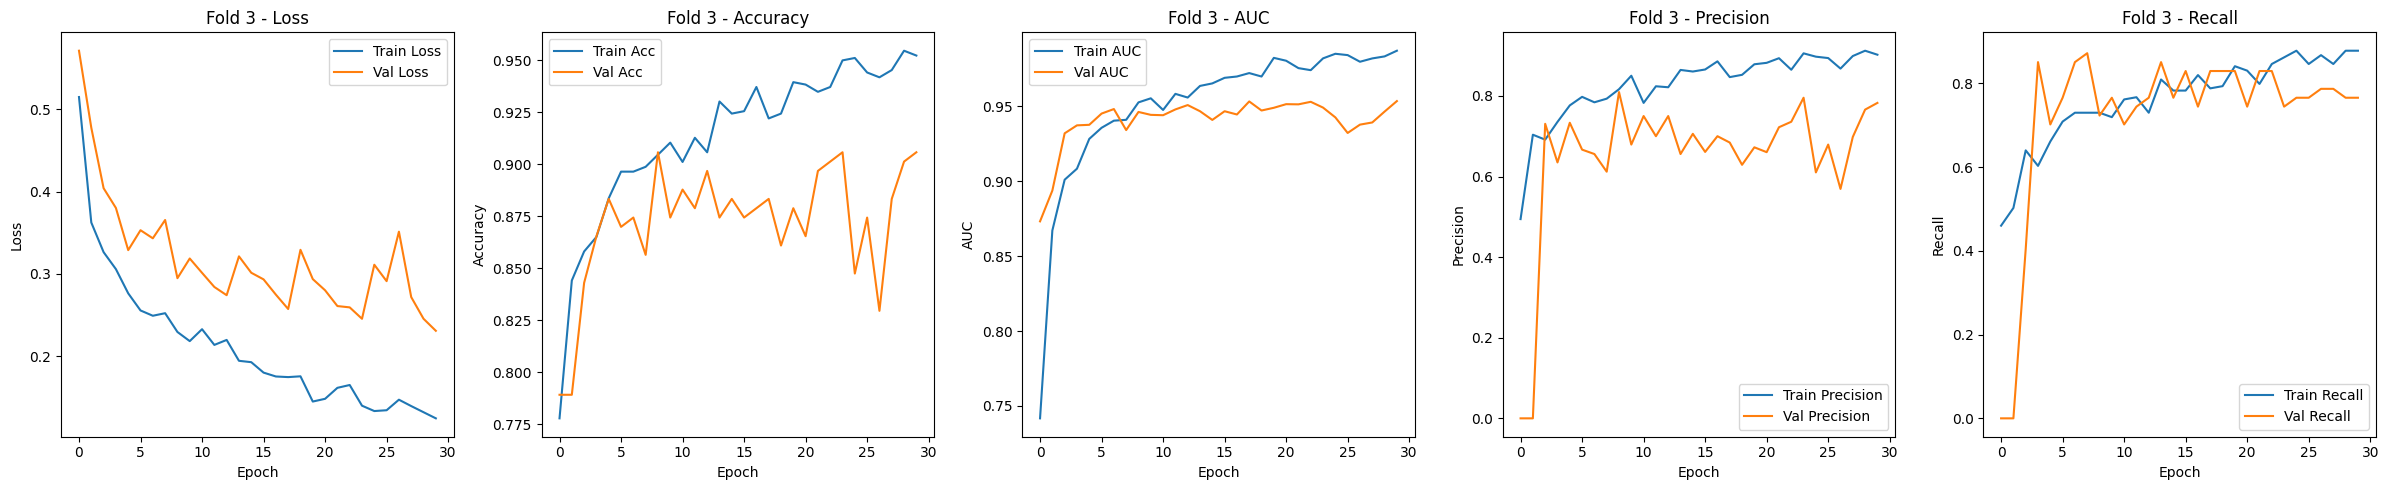

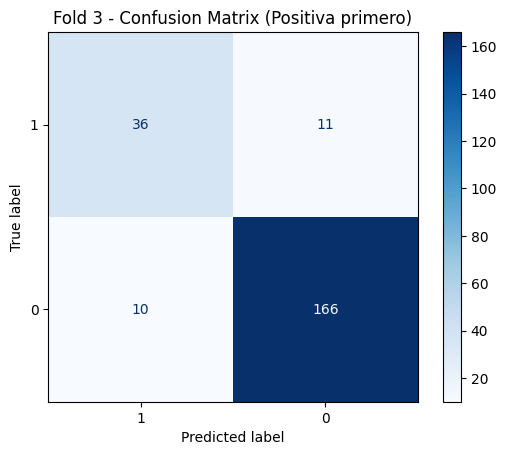


====== Fold 4 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.4899, Acc: 0.7927, AUC: 0.7729, Prec: 0.5118, Rec: 0.4703 | Val Loss: 0.5867, Acc: 0.7571, AUC: 0.8398, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.3648, Acc: 0.8339, AUC: 0.8711, Prec: 0.6136, Rec: 0.5838 | Val Loss: 0.5157, Acc: 0.7571, AUC: 0.8853, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.3201, Acc: 0.8385, AUC: 0.8898, Prec: 0.6692, Rec: 0.4703 | Val Loss: 0.4119, Acc: 0.8381, AUC: 0.9001, Prec: 0.9048, Rec: 0.3725
Epoch 04: Train Loss: 0.3129, Acc: 0.8740, AUC: 0.9043, Prec: 0.7483, Rec: 0.6108 | Val Loss: 0.3772, Acc: 0.9000, AUC: 0.9228, Prec: 0.8261, Rec: 0.7451
Epoch 05: Train Loss: 0.2780, Acc: 0.8843, AUC: 0.9221, Prec: 0.7658, Rec: 0.6541 | Val Loss: 0.3783, Acc: 0.8810, AUC: 0.9261, Prec: 0.7407, Rec: 0.7843
Epoch 06: Train Loss: 0.2735, Acc: 0.8797, AUC: 0.9239, Prec: 0.7564, Rec: 0.6378 | Val Loss: 0.3733, Acc: 0.8905, AUC: 0.9380, Prec: 0.7800, Rec: 0.7647
Epoch 07: Train Loss: 0.2730, Acc: 0.8912, AUC: 0.9302, Prec: 0.7922, Rec: 0.6595 | Val Loss: 0.3359, Acc: 0.9143, AUC: 0.9505, Prec: 0.8667, Rec: 0.7647
Epoch 08: Train Loss: 0.2567, Acc: 0.8958, AUC: 0.9354, Prec: 0.7611, Rec: 0

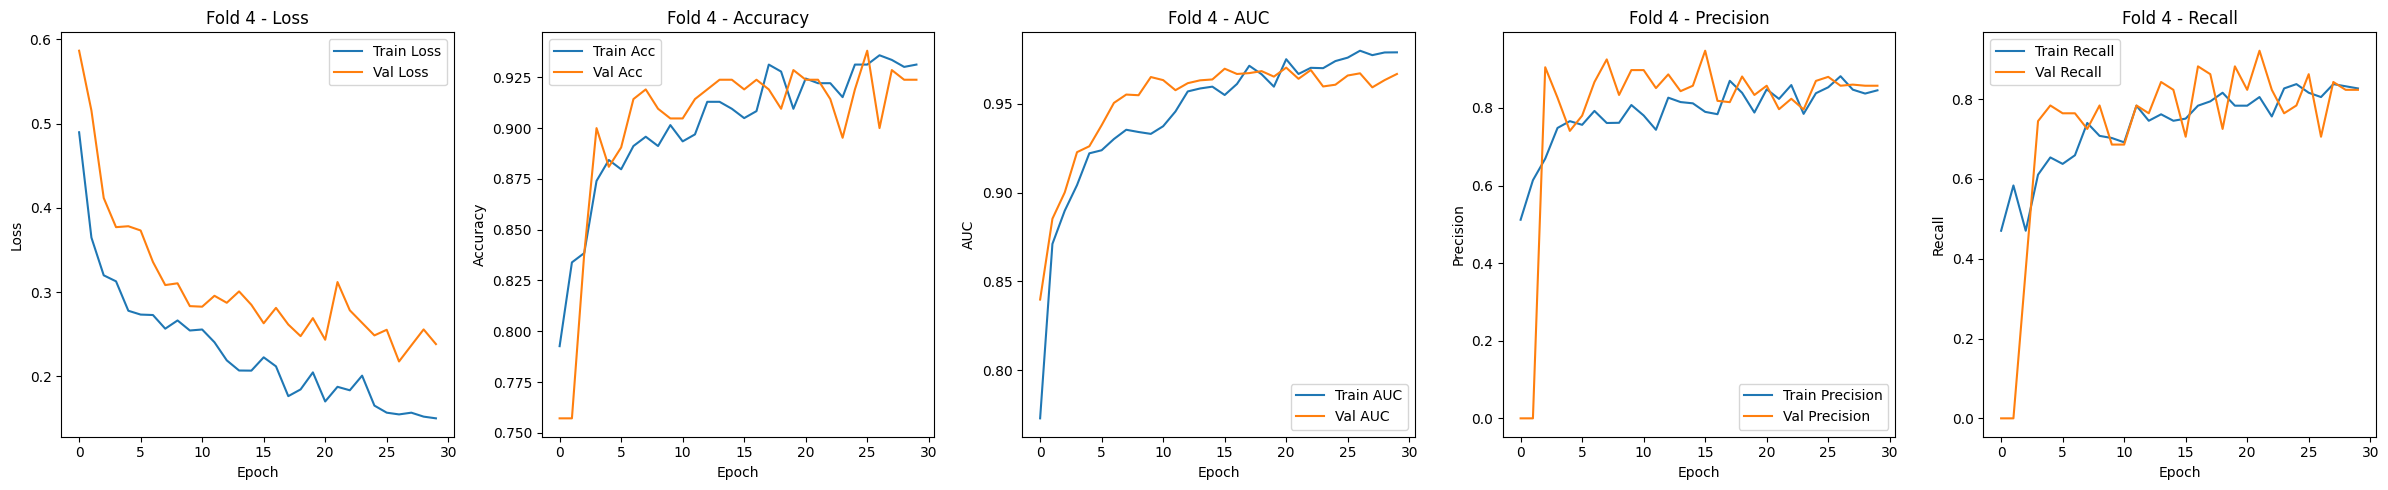

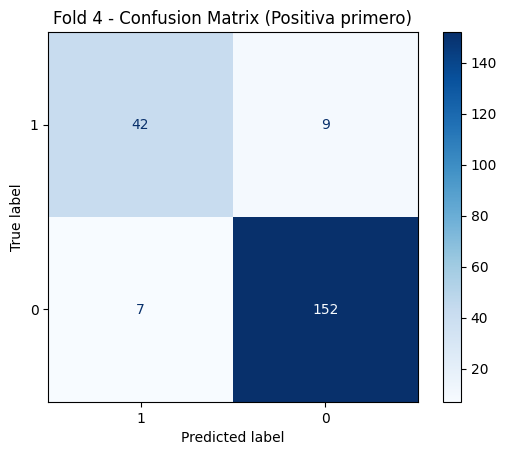


===== Resultados Finales por Fold =====
Fold 0 - Val Acc: 0.9143, AUC: 0.9432, Precision: 0.9697, Recall: 0.6531
Fold 1 - Val Acc: 0.8978, AUC: 0.9519, Precision: 0.7255, Recall: 0.8043
Fold 2 - Val Acc: 0.8884, AUC: 0.9247, Precision: 0.7021, Recall: 0.7674
Fold 3 - Val Acc: 0.9058, AUC: 0.9535, Precision: 0.7826, Recall: 0.7660
Fold 4 - Val Acc: 0.9238, AUC: 0.9668, Precision: 0.8571, Recall: 0.8235

===== Promedios Finales con Desviación Estándar =====
Val Accuracy: 0.9060 ± 0.0124
Val AUC: 0.9480 ± 0.0139
Val Precision: 0.8074 ± 0.0972
Val Recall: 0.7629 ± 0.0591


In [ ]:
for fold in range(5):
  print(f"\n====== Fold {fold} ======")

  # Preparar datos
  train_ids = kfold_data[f"train_fold_{fold}"]
  val_ids = kfold_data[f"val_fold_{fold}"]

  train_dataset = [id_to_data[i] for i in train_ids]
  val_dataset = [id_to_data[i] for i in val_ids]

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  # Inicializar modelo
  model = GAT(num_features, num_classes).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []
  train_aucs, val_aucs = [], []
  train_precisions, val_precisions = [], []
  train_recalls, val_recalls = [], []

  for epoch in range(1, num_epochs + 1):
    # ---- ENTRENAMIENTO ----
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    y_train_true = []
    y_train_prob = []
    y_train_pred = []

    for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      out = model(data.x, data.edge_index, data.batch)
      loss = criterion(out, data.y)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      pred = out.argmax(dim=1)
      correct += (pred == data.y).sum().item()
      total += data.y.size(0)

      y_train_true.append(data.y.cpu())
      y_train_prob.append(F.softmax(out, dim=1)[:, 1].detach().cpu())
      y_train_pred.append(pred.cpu())

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    y_train_true = torch.cat(y_train_true)
    y_train_prob = torch.cat(y_train_prob)
    y_train_pred = torch.cat(y_train_pred)
    train_auc = roc_auc_score(y_train_true, y_train_prob)
    train_precision = precision_score(y_train_true, y_train_pred)
    train_recall = recall_score(y_train_true, y_train_pred)

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    train_aucs.append(train_auc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)

    # ---- VALIDACIÓN ----
    model.eval()
    val_loss = 0
    correct = 0
    y_true = []
    y_prob = []
    y_pred = []

    with torch.no_grad():
      for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        val_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        y_true.append(data.y.cpu())
        y_prob.append(F.softmax(out, dim=1)[:, 1].cpu())
        y_pred.append(pred.cpu())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / len(val_loader.dataset)
    y_true = torch.cat(y_true)
    y_prob = torch.cat(y_prob)
    y_pred = torch.cat(y_pred)
    val_auc = roc_auc_score(y_true, y_prob)
    val_precision = precision_score(y_true, y_pred)
    val_recall = recall_score(y_true, y_pred)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    val_aucs.append(val_auc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, AUC: {train_auc:.4f}, "
          f"Prec: {train_precision:.4f}, Rec: {train_recall:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, AUC: {val_auc:.4f}, "
          f"Prec: {val_precision:.4f}, Rec: {val_recall:.4f}")

  # Guardar AUC y Accuracy final del fold
  all_val_accs.append(val_accuracies[-1])
  all_val_aucs.append(val_aucs[-1])
  all_val_precisions.append(val_precisions[-1])
  all_val_recalls.append(val_recalls[-1])

  # Graficar métricas por fold
  plt.figure(figsize=(24, 5))

  plt.subplot(1, 5, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.title(f'Fold {fold} - Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 5, 2)
  plt.plot(train_accuracies, label='Train Acc')
  plt.plot(val_accuracies, label='Val Acc')
  plt.title(f'Fold {fold} - Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 5, 3)
  plt.plot(train_aucs, label='Train AUC')
  plt.plot(val_aucs, label='Val AUC')
  plt.title(f'Fold {fold} - AUC')
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.legend()

  plt.subplot(1, 5, 4)
  plt.plot(train_precisions, label='Train Precision')
  plt.plot(val_precisions, label='Val Precision')
  plt.title(f'Fold {fold} - Precision')
  plt.xlabel('Epoch')
  plt.ylabel('Precision')
  plt.legend()

  plt.subplot(1, 5, 5)
  plt.plot(train_recalls, label='Train Recall')
  plt.plot(val_recalls, label='Val Recall')
  plt.title(f'Fold {fold} - Recall')
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Matriz de confusión
  cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
  disp.plot(cmap='Blues')
  plt.title(f'Fold {fold} - Confusion Matrix (Positiva primero)')
  plt.show()

# Resultados globales
print("\n===== Resultados Finales por Fold =====")
for i in range(len(all_val_accs)):
  print(f"Fold {i} - Val Acc: {all_val_accs[i]:.4f}, AUC: {all_val_aucs[i]:.4f}, "
        f"Precision: {all_val_precisions[i]:.4f}, Recall: {all_val_recalls[i]:.4f}")

# Promedios finales con desviación estándar
print("\n===== Promedios Finales con Desviación Estándar =====")
print(f"Val Accuracy: {np.mean(all_val_accs):.4f} ± {np.std(all_val_accs):.4f}")
print(f"Val AUC: {np.mean(all_val_aucs):.4f} ± {np.std(all_val_aucs):.4f}")
print(f"Val Precision: {np.mean(all_val_precisions):.4f} ± {np.std(all_val_precisions):.4f}")
print(f"Val Recall: {np.mean(all_val_recalls):.4f} ± {np.std(all_val_recalls):.4f}")

# **8. Exp5 (GCN - Set2Set)**

In [ ]:
# Configuraciones
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30
num_classes = 2
num_features = dataset_grafos[0].x.shape[1]

# Resultados acumulados por fold
all_val_accs = []
all_val_aucs = []
all_val_precisions = []
all_val_recalls = []

In [ ]:
class GCN(nn.Module):
  def __init__(self, num_features, num_classes):
    super(GCN, self).__init__()
    self.conv1 = GCNConv(num_features, 128)
    self.conv2 = GCNConv(128, 64)
    self.set2set = Set2Set(64, processing_steps=3)
    self.lin = nn.Linear(64 * 2, num_classes)

  def forward(self, x, edge_index, batch):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = self.set2set(x, batch)  # Set2Set expects (x, batch)
    x = self.lin(x)
    return x


====== Fold 0 ======


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.5797, Acc: 0.7858, AUC: 0.5513, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.5126, Acc: 0.7667, AUC: 0.8374, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4620, Acc: 0.7858, AUC: 0.8091, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4285, Acc: 0.7667, AUC: 0.8536, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.3742, Acc: 0.8133, AUC: 0.8606, Prec: 0.6818, Rec: 0.2406 | Val Loss: 0.3673, Acc: 0.8333, AUC: 0.8727, Prec: 0.7500, Rec: 0.4286
Epoch 04: Train Loss: 0.3524, Acc: 0.8557, AUC: 0.8742, Prec: 0.7047, Rec: 0.5615 | Val Loss: 0.3362, Acc: 0.8714, AUC: 0.8925, Prec: 0.7895, Rec: 0.6122
Epoch 05: Train Loss: 0.3164, Acc: 0.8694, AUC: 0.9026, Prec: 0.7239, Rec: 0.6310 | Val Loss: 0.3569, Acc: 0.8429, AUC: 0.9025, Prec: 0.8077, Rec: 0.4286
Epoch 06: Train Loss: 0.2937, Acc: 0.8774, AUC: 0.9123, Prec: 0.7353, Rec: 0.6684 | Val Loss: 0.3049, Acc: 0.8762, AUC: 0.9125, Prec: 0.7674, Rec: 0.6735
Epoch 07: Train Loss: 0.2699, Acc: 0.8866, AUC: 0.9278, Prec: 0.7472, Rec: 0.7112 | Val Loss: 0.3149, Acc: 0.8714, AUC: 0.9205, Prec: 0.8235, Rec: 0.5714
Epoch 08: Train Loss: 0.2569, Acc: 0.8923, AUC: 0.9354, Prec: 0.7688, Rec: 0

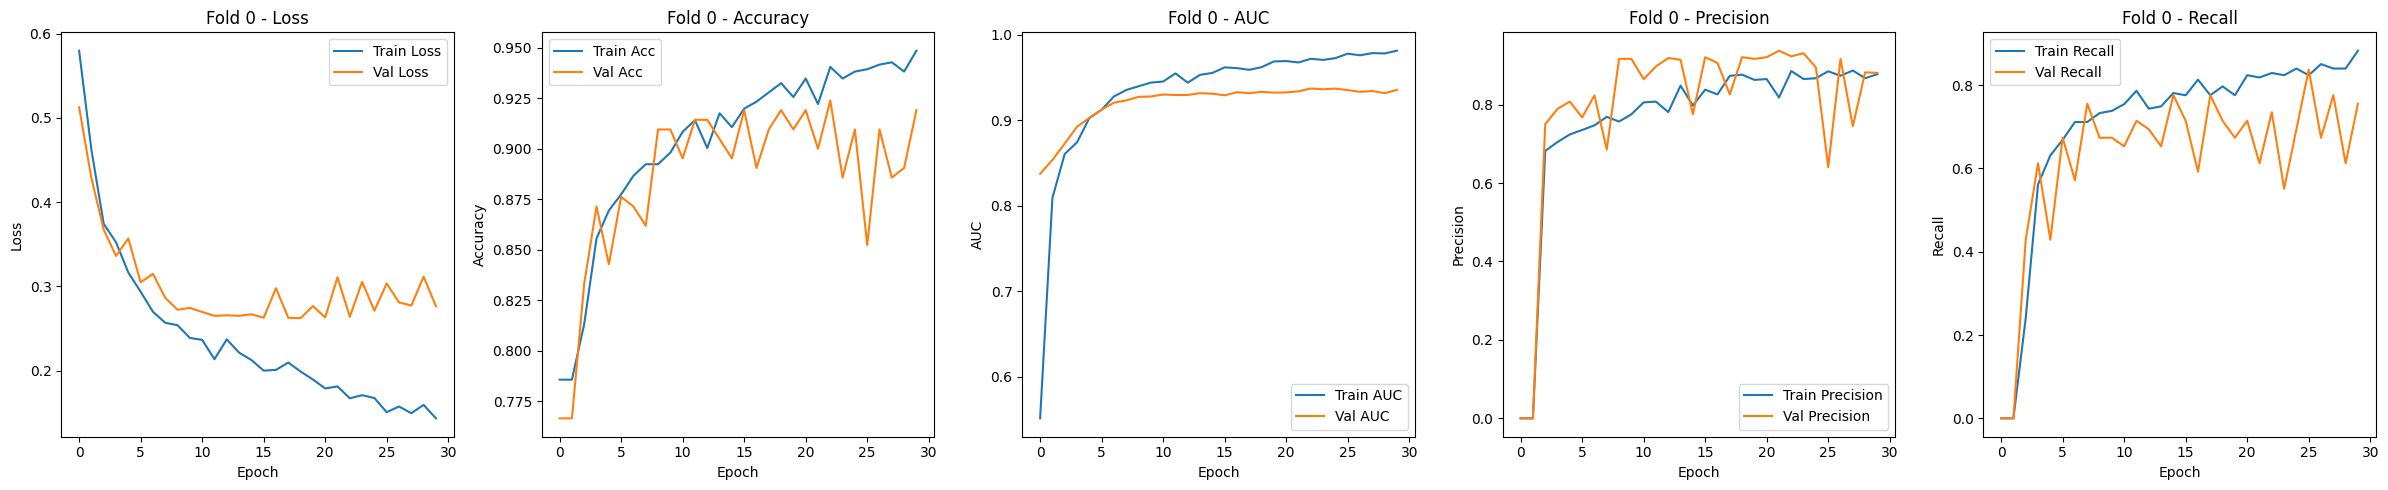

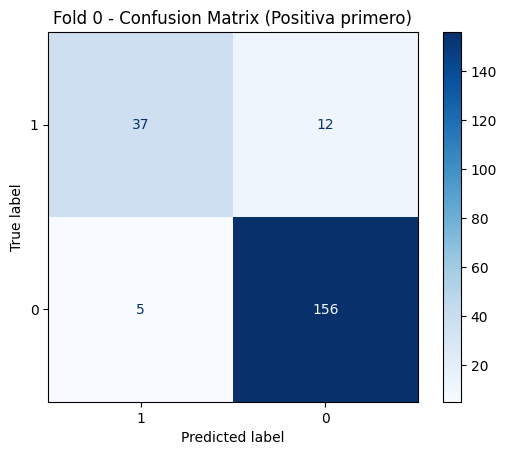


====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6261, Acc: 0.6923, AUC: 0.4952, Prec: 0.2597, Rec: 0.2105 | Val Loss: 0.4536, Acc: 0.7956, AUC: 0.8782, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4727, Acc: 0.7786, AUC: 0.8052, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.3569, Acc: 0.7956, AUC: 0.8880, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.4028, Acc: 0.7972, AUC: 0.8449, Prec: 0.6667, Rec: 0.1684 | Val Loss: 0.3112, Acc: 0.8667, AUC: 0.8975, Prec: 0.6739, Rec: 0.6739
Epoch 04: Train Loss: 0.3574, Acc: 0.8473, AUC: 0.8751, Prec: 0.7185, Rec: 0.5105 | Val Loss: 0.2646, Acc: 0.8756, AUC: 0.9134, Prec: 0.7143, Rec: 0.6522
Epoch 05: Train Loss: 0.3374, Acc: 0.8590, AUC: 0.8849, Prec: 0.7170, Rec: 0.6000 | Val Loss: 0.2577, Acc: 0.8800, AUC: 0.9310, Prec: 0.6863, Rec: 0.7609
Epoch 06: Train Loss: 0.3048, Acc: 0.8776, AUC: 0.9073, Prec: 0.7515, Rec: 0.6684 | Val Loss: 0.2323, Acc: 0.8844, AUC: 0.9378, Prec: 0.7381, Rec: 0.6739
Epoch 07: Train Loss: 0.2863, Acc: 0.8834, AUC: 0.9189, Prec: 0.7528, Rec: 0.7053 | Val Loss: 0.2280, Acc: 0.8800, AUC: 0.9443, Prec: 0.7568, Rec: 0.6087
Epoch 08: Train Loss: 0.2698, Acc: 0.8881, AUC: 0.9309, Prec: 0.7527, Rec: 0

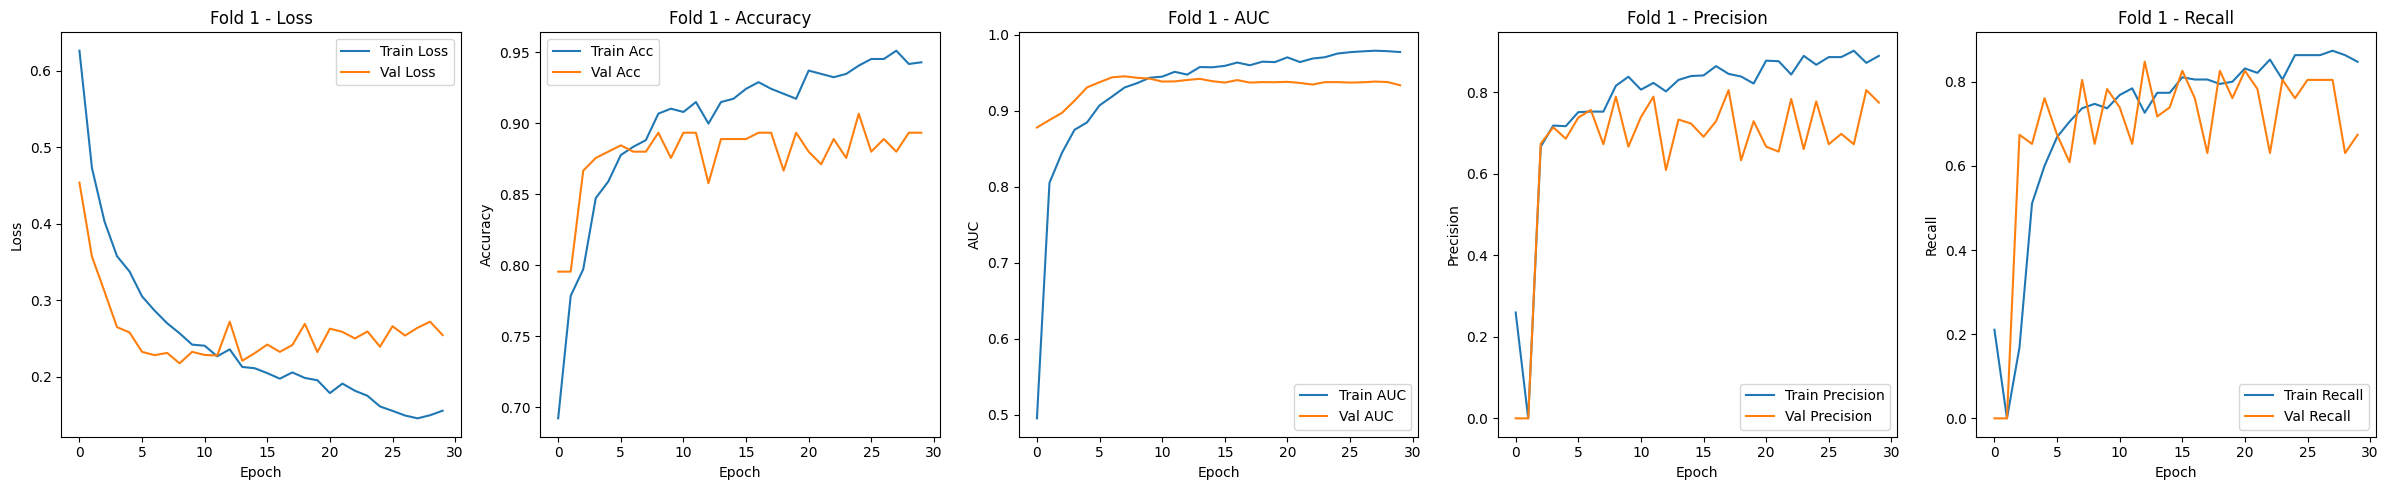

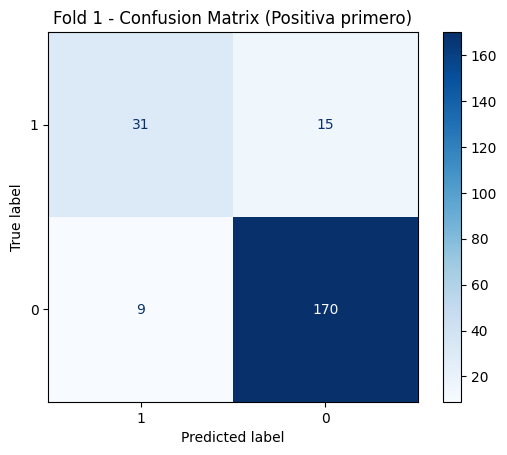


====== Fold 2 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.5970, Acc: 0.7776, AUC: 0.5128, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4702, Acc: 0.8000, AUC: 0.8327, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4692, Acc: 0.7776, AUC: 0.8421, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4130, Acc: 0.8000, AUC: 0.8567, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.3937, Acc: 0.7903, AUC: 0.8448, Prec: 0.6486, Rec: 0.1244 | Val Loss: 0.3557, Acc: 0.8465, AUC: 0.8670, Prec: 0.6389, Rec: 0.5349
Epoch 04: Train Loss: 0.3605, Acc: 0.8445, AUC: 0.8677, Prec: 0.7071, Rec: 0.5130 | Val Loss: 0.3275, Acc: 0.8465, AUC: 0.8870, Prec: 0.6471, Rec: 0.5116
Epoch 05: Train Loss: 0.3173, Acc: 0.8698, AUC: 0.8969, Prec: 0.7500, Rec: 0.6218 | Val Loss: 0.3245, Acc: 0.8558, AUC: 0.8972, Prec: 0.6250, Rec: 0.6977
Epoch 06: Train Loss: 0.3341, Acc: 0.8698, AUC: 0.9085, Prec: 0.7128, Rec: 0.6943 | Val Loss: 0.3472, Acc: 0.8419, AUC: 0.9029, Prec: 0.5714, Rec: 0.8372
Epoch 07: Train Loss: 0.2846, Acc: 0.8802, AUC: 0.9211, Prec: 0.7405, Rec: 0.7098 | Val Loss: 0.3031, Acc: 0.8558, AUC: 0.9074, Prec: 0.6364, Rec: 0.6512
Epoch 08: Train Loss: 0.2699, Acc: 0.8929, AUC: 0.9320, Prec: 0.7660, Rec: 0

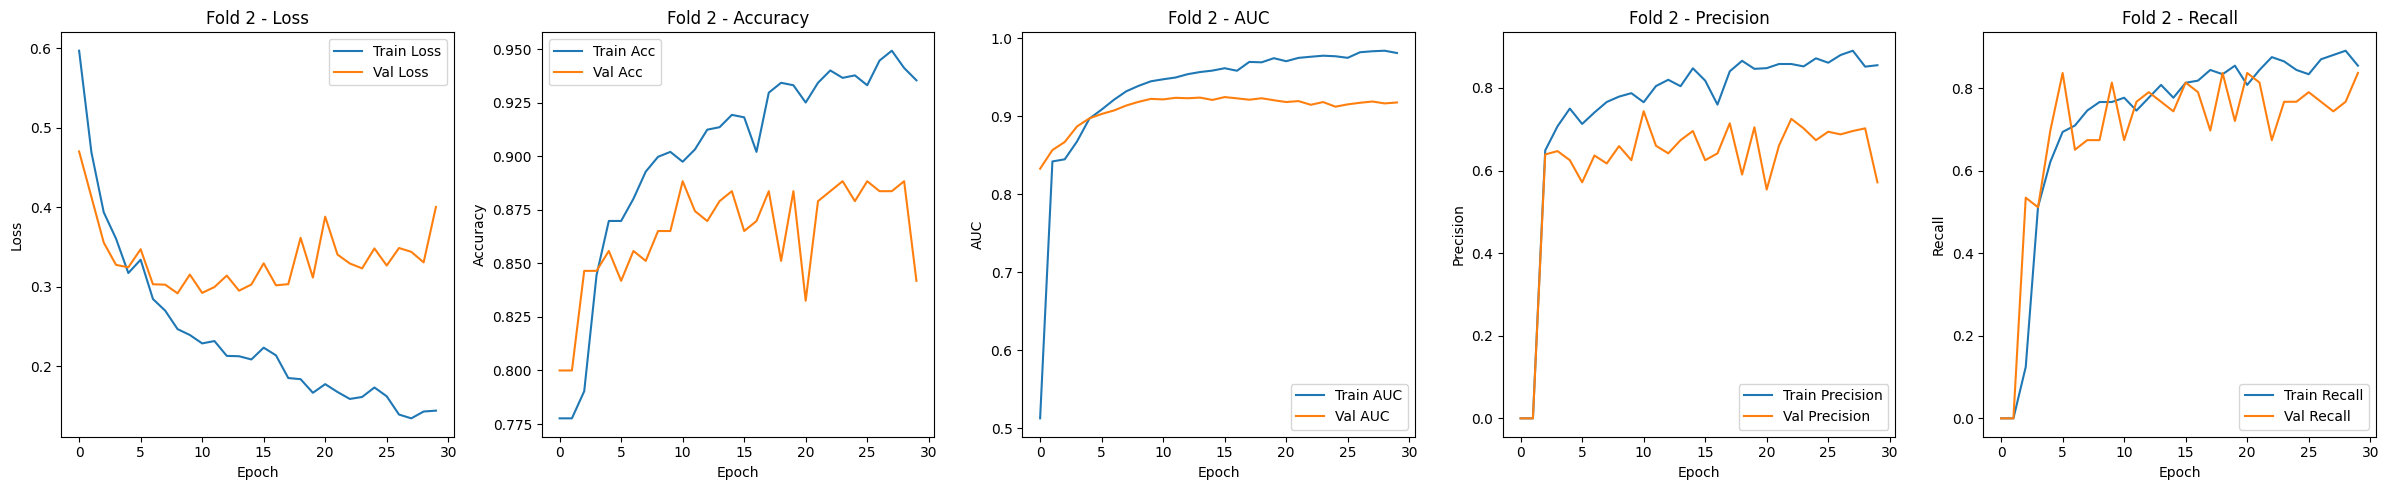

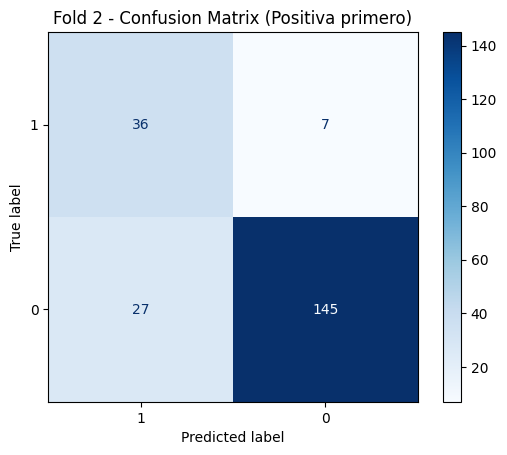


====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6269, Acc: 0.7012, AUC: 0.4994, Prec: 0.2258, Rec: 0.1481 | Val Loss: 0.5026, Acc: 0.7892, AUC: 0.8654, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4770, Acc: 0.7802, AUC: 0.7927, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4200, Acc: 0.7892, AUC: 0.8698, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.3948, Acc: 0.8070, AUC: 0.8598, Prec: 0.7674, Rec: 0.1746 | Val Loss: 0.3545, Acc: 0.8610, AUC: 0.8756, Prec: 0.7222, Rec: 0.5532
Epoch 04: Train Loss: 0.3446, Acc: 0.8581, AUC: 0.8824, Prec: 0.7410, Rec: 0.5450 | Val Loss: 0.3599, Acc: 0.8700, AUC: 0.8798, Prec: 0.6552, Rec: 0.8085
Epoch 05: Train Loss: 0.3236, Acc: 0.8698, AUC: 0.8975, Prec: 0.7151, Rec: 0.6772 | Val Loss: 0.3395, Acc: 0.8655, AUC: 0.8814, Prec: 0.7576, Rec: 0.5319
Epoch 06: Train Loss: 0.2930, Acc: 0.8814, AUC: 0.9179, Prec: 0.7669, Rec: 0.6614 | Val Loss: 0.3100, Acc: 0.8789, AUC: 0.8883, Prec: 0.7273, Rec: 0.6809
Epoch 07: Train Loss: 0.2753, Acc: 0.8884, AUC: 0.9270, Prec: 0.7853, Rec: 0.6772 | Val Loss: 0.3049, Acc: 0.8789, AUC: 0.8920, Prec: 0.7174, Rec: 0.7021
Epoch 08: Train Loss: 0.2649, Acc: 0.8953, AUC: 0.9304, Prec: 0.7895, Rec: 0

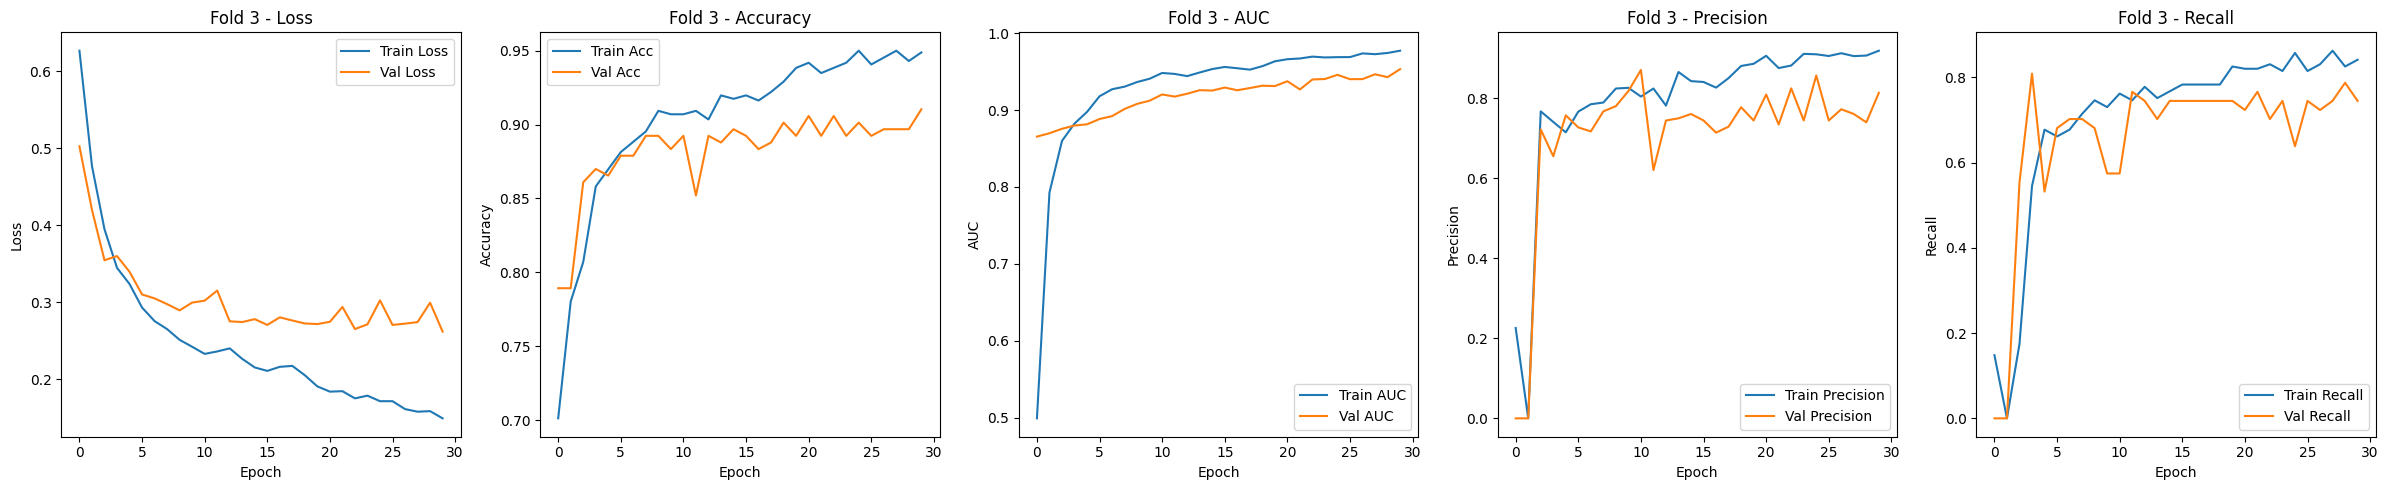

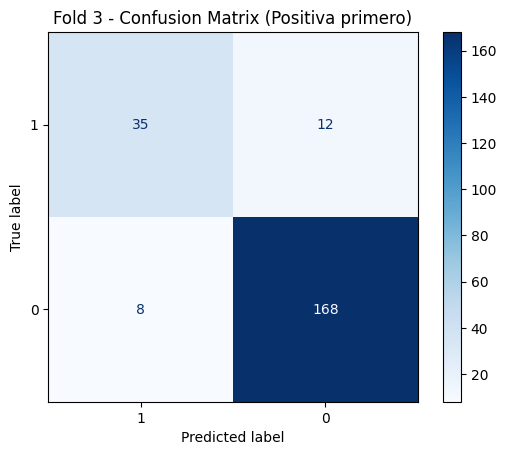


====== Fold 4 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6076, Acc: 0.6987, AUC: 0.5346, Prec: 0.2532, Rec: 0.2162 | Val Loss: 0.5315, Acc: 0.7571, AUC: 0.8018, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4461, Acc: 0.7847, AUC: 0.7996, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4824, Acc: 0.7571, AUC: 0.8170, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.3809, Acc: 0.8121, AUC: 0.8543, Prec: 0.6909, Rec: 0.2054 | Val Loss: 0.4370, Acc: 0.8143, AUC: 0.8367, Prec: 0.8750, Rec: 0.2745
Epoch 04: Train Loss: 0.3412, Acc: 0.8580, AUC: 0.8847, Prec: 0.6993, Rec: 0.5784 | Val Loss: 0.4615, Acc: 0.8238, AUC: 0.8631, Prec: 0.8889, Rec: 0.3137
Epoch 05: Train Loss: 0.3194, Acc: 0.8568, AUC: 0.8902, Prec: 0.6807, Rec: 0.6108 | Val Loss: 0.3826, Acc: 0.8381, AUC: 0.8861, Prec: 0.8696, Rec: 0.3922
Epoch 06: Train Loss: 0.3043, Acc: 0.8740, AUC: 0.9060, Prec: 0.7301, Rec: 0.6432 | Val Loss: 0.3300, Acc: 0.8714, AUC: 0.8996, Prec: 0.8529, Rec: 0.5686
Epoch 07: Train Loss: 0.2921, Acc: 0.8706, AUC: 0.9142, Prec: 0.7169, Rec: 0.6432 | Val Loss: 0.3048, Acc: 0.8952, AUC: 0.9068, Prec: 0.8372, Rec: 0.7059
Epoch 08: Train Loss: 0.2819, Acc: 0.8729, AUC: 0.9160, Prec: 0.7011, Rec: 0

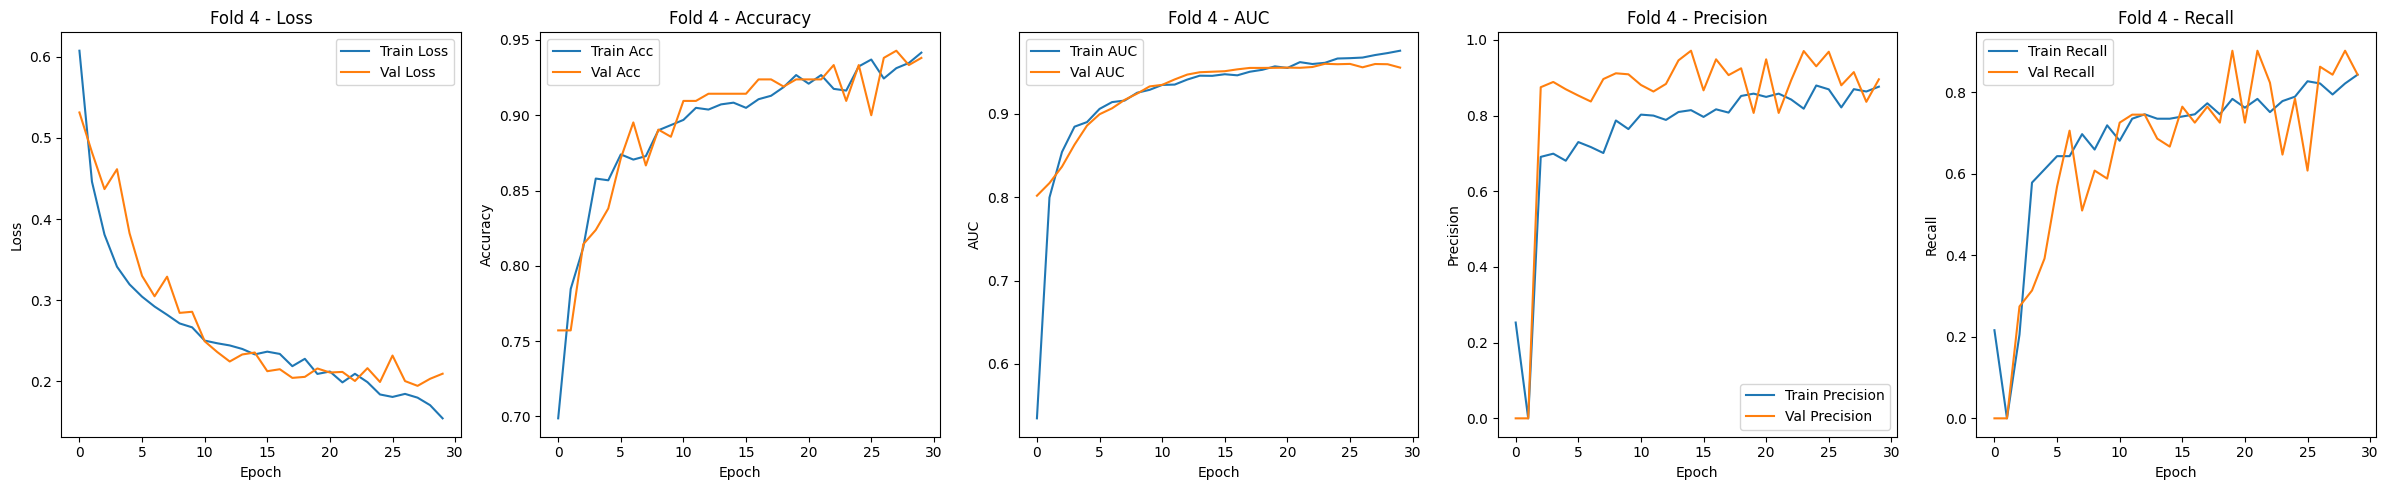

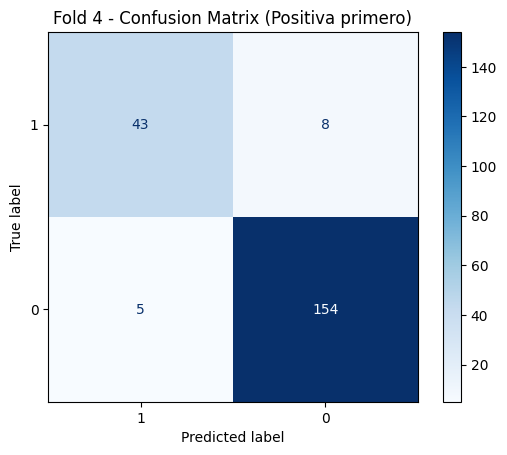


===== Resultados Finales por Fold =====
Fold 0 - Val Acc: 0.9190, AUC: 0.9355, Precision: 0.8810, Recall: 0.7551
Fold 1 - Val Acc: 0.8933, AUC: 0.9338, Precision: 0.7750, Recall: 0.6739
Fold 2 - Val Acc: 0.8419, AUC: 0.9177, Precision: 0.5714, Recall: 0.8372
Fold 3 - Val Acc: 0.9103, AUC: 0.9531, Precision: 0.8140, Recall: 0.7447
Fold 4 - Val Acc: 0.9381, AUC: 0.9556, Precision: 0.8958, Recall: 0.8431

===== Promedios Finales con Desviación Estándar =====
Val Accuracy: 0.9005 ± 0.0327
Val AUC: 0.9391 ± 0.0139
Val Precision: 0.7874 ± 0.1166
Val Recall: 0.7708 ± 0.0632


In [ ]:
for fold in range(5):
  print(f"\n====== Fold {fold} ======")

  # Preparar datos
  train_ids = kfold_data[f"train_fold_{fold}"]
  val_ids = kfold_data[f"val_fold_{fold}"]

  train_dataset = [id_to_data[i] for i in train_ids]
  val_dataset = [id_to_data[i] for i in val_ids]

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  # Inicializar modelo
  model = GCN(num_features, num_classes).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []
  train_aucs, val_aucs = [], []
  train_precisions, val_precisions = [], []
  train_recalls, val_recalls = [], []

  for epoch in range(1, num_epochs + 1):
    # ---- ENTRENAMIENTO ----
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    y_train_true = []
    y_train_prob = []
    y_train_pred = []

    for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      out = model(data.x, data.edge_index, data.batch)
      loss = criterion(out, data.y)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      pred = out.argmax(dim=1)
      correct += (pred == data.y).sum().item()
      total += data.y.size(0)

      y_train_true.append(data.y.cpu())
      y_train_prob.append(F.softmax(out, dim=1)[:, 1].detach().cpu())
      y_train_pred.append(pred.cpu())

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    y_train_true = torch.cat(y_train_true)
    y_train_prob = torch.cat(y_train_prob)
    y_train_pred = torch.cat(y_train_pred)
    train_auc = roc_auc_score(y_train_true, y_train_prob)
    train_precision = precision_score(y_train_true, y_train_pred)
    train_recall = recall_score(y_train_true, y_train_pred)

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    train_aucs.append(train_auc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)

    # ---- VALIDACIÓN ----
    model.eval()
    val_loss = 0
    correct = 0
    y_true = []
    y_prob = []
    y_pred = []

    with torch.no_grad():
      for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        val_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        y_true.append(data.y.cpu())
        y_prob.append(F.softmax(out, dim=1)[:, 1].cpu())
        y_pred.append(pred.cpu())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / len(val_loader.dataset)
    y_true = torch.cat(y_true)
    y_prob = torch.cat(y_prob)
    y_pred = torch.cat(y_pred)
    val_auc = roc_auc_score(y_true, y_prob)
    val_precision = precision_score(y_true, y_pred)
    val_recall = recall_score(y_true, y_pred)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    val_aucs.append(val_auc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, AUC: {train_auc:.4f}, "
          f"Prec: {train_precision:.4f}, Rec: {train_recall:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, AUC: {val_auc:.4f}, "
          f"Prec: {val_precision:.4f}, Rec: {val_recall:.4f}")

  # Guardar AUC y Accuracy final del fold
  all_val_accs.append(val_accuracies[-1])
  all_val_aucs.append(val_aucs[-1])
  all_val_precisions.append(val_precisions[-1])
  all_val_recalls.append(val_recalls[-1])

  # Graficar métricas por fold
  plt.figure(figsize=(24, 5))

  plt.subplot(1, 5, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.title(f'Fold {fold} - Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 5, 2)
  plt.plot(train_accuracies, label='Train Acc')
  plt.plot(val_accuracies, label='Val Acc')
  plt.title(f'Fold {fold} - Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 5, 3)
  plt.plot(train_aucs, label='Train AUC')
  plt.plot(val_aucs, label='Val AUC')
  plt.title(f'Fold {fold} - AUC')
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.legend()

  plt.subplot(1, 5, 4)
  plt.plot(train_precisions, label='Train Precision')
  plt.plot(val_precisions, label='Val Precision')
  plt.title(f'Fold {fold} - Precision')
  plt.xlabel('Epoch')
  plt.ylabel('Precision')
  plt.legend()

  plt.subplot(1, 5, 5)
  plt.plot(train_recalls, label='Train Recall')
  plt.plot(val_recalls, label='Val Recall')
  plt.title(f'Fold {fold} - Recall')
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Matriz de confusión
  cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
  disp.plot(cmap='Blues')
  plt.title(f'Fold {fold} - Confusion Matrix (Positiva primero)')
  plt.show()

# Resultados globales
print("\n===== Resultados Finales por Fold =====")
for i in range(len(all_val_accs)):
  print(f"Fold {i} - Val Acc: {all_val_accs[i]:.4f}, AUC: {all_val_aucs[i]:.4f}, "
        f"Precision: {all_val_precisions[i]:.4f}, Recall: {all_val_recalls[i]:.4f}")

# Promedios finales con desviación estándar
print("\n===== Promedios Finales con Desviación Estándar =====")
print(f"Val Accuracy: {np.mean(all_val_accs):.4f} ± {np.std(all_val_accs):.4f}")
print(f"Val AUC: {np.mean(all_val_aucs):.4f} ± {np.std(all_val_aucs):.4f}")
print(f"Val Precision: {np.mean(all_val_precisions):.4f} ± {np.std(all_val_precisions):.4f}")
print(f"Val Recall: {np.mean(all_val_recalls):.4f} ± {np.std(all_val_recalls):.4f}")

# **9. Exp6 (GINConv)**

In [ ]:
# Configuraciones
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30
num_classes = 2
num_features = dataset_grafos[0].x.shape[1]

# Resultados acumulados por fold
all_val_accs = []
all_val_aucs = []
all_val_precisions = []
all_val_recalls = []

In [ ]:
class GIN(nn.Module):
  def __init__(self, num_features, num_classes):
    super(GIN, self).__init__()

    nn1 = nn.Sequential(nn.Linear(num_features, 128), nn.ReLU(), nn.Linear(128, 128))
    nn2 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 64))

    self.conv1 = GINConv(nn1)
    self.conv2 = GINConv(nn2)

    self.lin = nn.Linear(64, num_classes)

  def forward(self, x, edge_index, batch):
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    x = F.relu(x)
    x = global_mean_pool(x, batch)  # mean pooling
    x = self.lin(x)
    return x


====== Fold 0 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.6245, Acc: 0.6094, AUC: 0.5183, Prec: 0.2326, Rec: 0.3583 | Val Loss: 0.5554, Acc: 0.7667, AUC: 0.8309, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4884, Acc: 0.7858, AUC: 0.6935, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4852, Acc: 0.7667, AUC: 0.8350, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 03: Train Loss: 0.4362, Acc: 0.7858, AUC: 0.8182, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4234, Acc: 0.7667, AUC: 0.8432, Prec: 0.0000, Rec: 0.0000
Epoch 04: Train Loss: 0.3842, Acc: 0.7973, AUC: 0.8510, Prec: 0.6786, Rec: 0.1016 | Val Loss: 0.3919, Acc: 0.8333, AUC: 0.8532, Prec: 0.7500, Rec: 0.4286
Epoch 05: Train Loss: 0.3582, Acc: 0.8431, AUC: 0.8678, Prec: 0.6984, Rec: 0.4706 | Val Loss: 0.3743, Acc: 0.8429, AUC: 0.8702, Prec: 0.7000, Rec: 0.5714
Epoch 06: Train Loss: 0.3371, Acc: 0.8591, AUC: 0.8846, Prec: 0.7162, Rec: 0.5668 | Val Loss: 0.3595, Acc: 0.8429, AUC: 0.8821, Prec: 0.6600, Rec: 0.6735
Epoch 07: Train Loss: 0.3245, Acc: 0.8614, AUC: 0.8978, Prec: 0.6793, Rec: 0.6684 | Val Loss: 0.3553, Acc: 0.8524, AUC: 0.8925, Prec: 0.7500, Rec: 0.5510
Epoch 08: Train Loss: 0.3075, Acc: 0.8625, AUC: 0.9031, Prec: 0.7107, Rec: 0.6043 | Val Loss: 0.3327, Acc: 0.8429, AUC: 0.9001, Prec: 0.6739, Rec: 0.6327
Epoch 09: Train Loss: 0.2927, Acc: 0.8763, AUC: 0.9185, Prec: 0.7394, Rec: 0

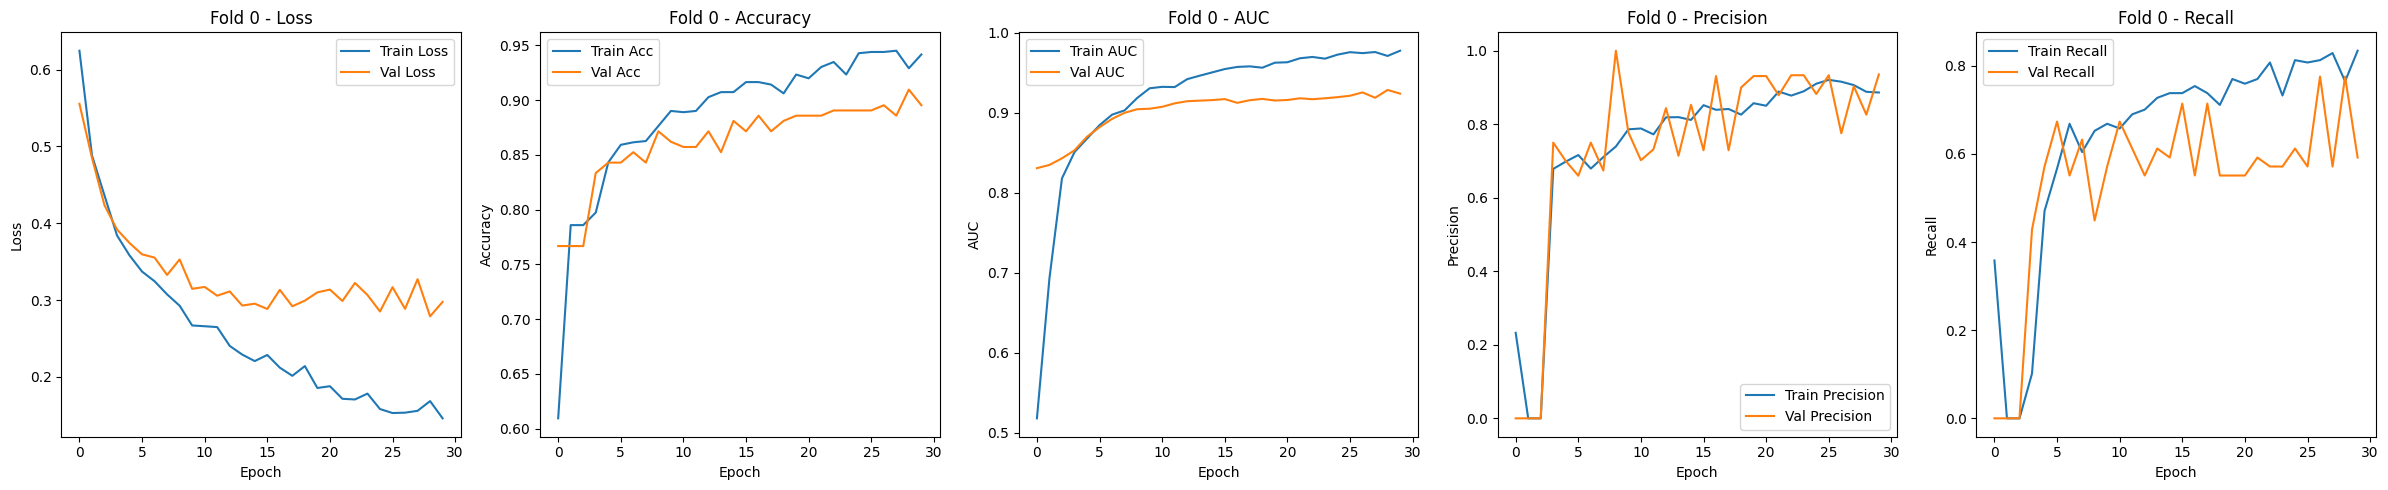

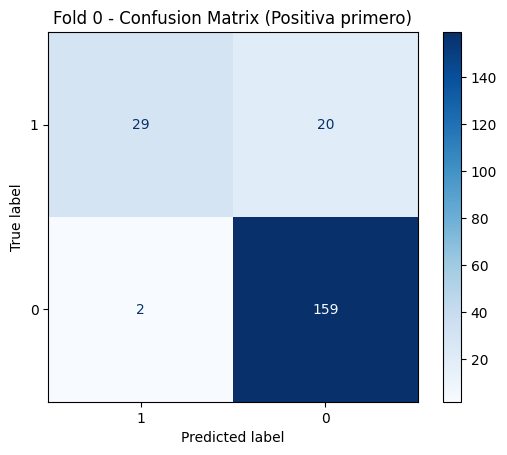


====== Fold 1 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` paramete

Epoch 01: Train Loss: 0.5829, Acc: 0.7786, AUC: 0.5101, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4547, Acc: 0.7956, AUC: 0.8693, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.5018, Acc: 0.7786, AUC: 0.7480, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4149, Acc: 0.7956, AUC: 0.8759, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.4510, Acc: 0.7786, AUC: 0.8114, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.3535, Acc: 0.7956, AUC: 0.8826, Prec: 0.0000, Rec: 0.0000
Epoch 04: Train Loss: 0.4031, Acc: 0.7855, AUC: 0.8390, Prec: 0.8000, Rec: 0.0421 | Val Loss: 0.2977, Acc: 0.8311, AUC: 0.8915, Prec: 0.6429, Rec: 0.3913
Epoch 05: Train Loss: 0.3672, Acc: 0.8485, AUC: 0.8611, Prec: 0.7113, Rec: 0.5316 | Val Loss: 0.3126, Acc: 0.8489, AUC: 0.9017, Prec: 0.5968, Rec: 0.8043
Epoch 06: Train Loss: 0.3698, Acc: 0.8345, AUC: 0.8561, Prec: 0.6277, Rec: 0.6211 | Val Loss: 0.2792, Acc: 0.8578, AUC: 0.9117, Prec: 0.6296, Rec: 0.7391
Epoch 07: Train Loss: 0.3343, Acc: 0.8578, AUC: 0.8877, Prec: 0.7048, Rec: 0.6158 | Val Loss: 0.2629, Acc: 0.8667, AUC: 0.9259, Prec: 0.6667, Rec: 0.6957
Epoch 08: Train Loss: 0.3168, Acc: 0.8695, AUC: 0.9014, Prec: 0.7321, Rec: 0

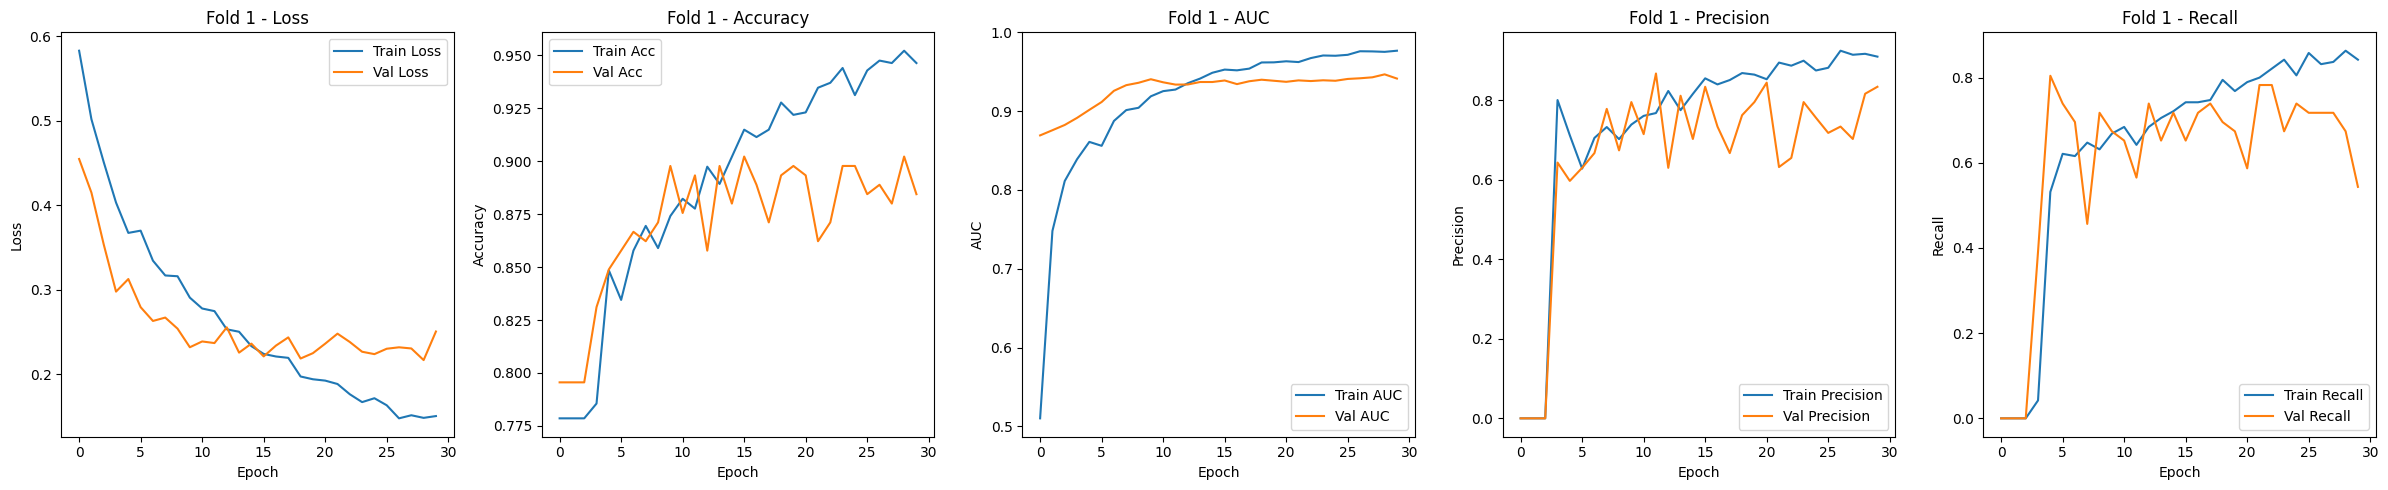

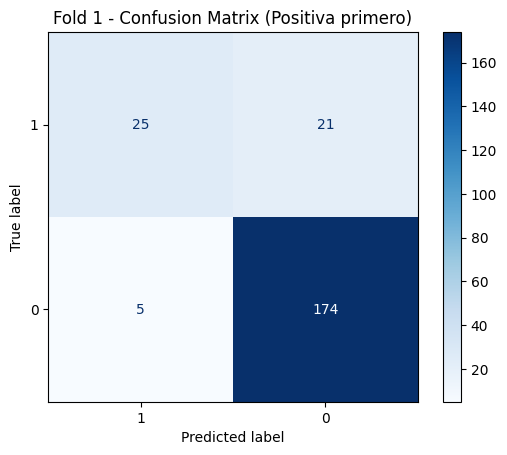


====== Fold 2 ======
Epoch 01: Train Loss: 0.5769, Acc: 0.7776, AUC: 0.5014, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4881, Acc: 0.8000, AUC: 0.8265, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` paramete

Epoch 02: Train Loss: 0.4991, Acc: 0.7776, AUC: 0.6856, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4535, Acc: 0.8000, AUC: 0.8444, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 03: Train Loss: 0.4514, Acc: 0.7776, AUC: 0.8223, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.3912, Acc: 0.8000, AUC: 0.8544, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 04: Train Loss: 0.4103, Acc: 0.7776, AUC: 0.8382, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.3615, Acc: 0.8000, AUC: 0.8651, Prec: 0.0000, Rec: 0.0000
Epoch 05: Train Loss: 0.3767, Acc: 0.8168, AUC: 0.8600, Prec: 0.6667, Rec: 0.3523 | Val Loss: 0.3437, Acc: 0.8419, AUC: 0.8774, Prec: 0.6154, Rec: 0.5581
Epoch 06: Train Loss: 0.3394, Acc: 0.8583, AUC: 0.8855, Prec: 0.7059, Rec: 0.6218 | Val Loss: 0.3384, Acc: 0.8512, AUC: 0.8879, Prec: 0.6078, Rec: 0.7209
Epoch 07: Train Loss: 0.3182, Acc: 0.8594, AUC: 0.8922, Prec: 0.6766, Rec: 0.7047 | Val Loss: 0.3276, Acc: 0.8512, AUC: 0.8958, Prec: 0.6078, Rec: 0.7209
Epoch 08: Train Loss: 0.2973, Acc: 0.8664, AUC: 0.9176, Prec: 0.7016, Rec: 0.6943 | Val Loss: 0.3206, Acc: 0.8605, AUC: 0.9049, Prec: 0.6327, Rec: 0.7209
Epoch 09: Train Loss: 0.2853, Acc: 0.8687, AUC: 0.9164, Prec: 0.7068, Rec: 0.6995 | Val Loss: 0.3261, Acc: 0.8465, AUC: 0.9074, Prec: 0.5893, Rec: 0.7674
Epoch 10: Train Loss: 0.2693, Acc: 0.8871, AUC: 0.9304, Prec: 0.7624, Rec: 0

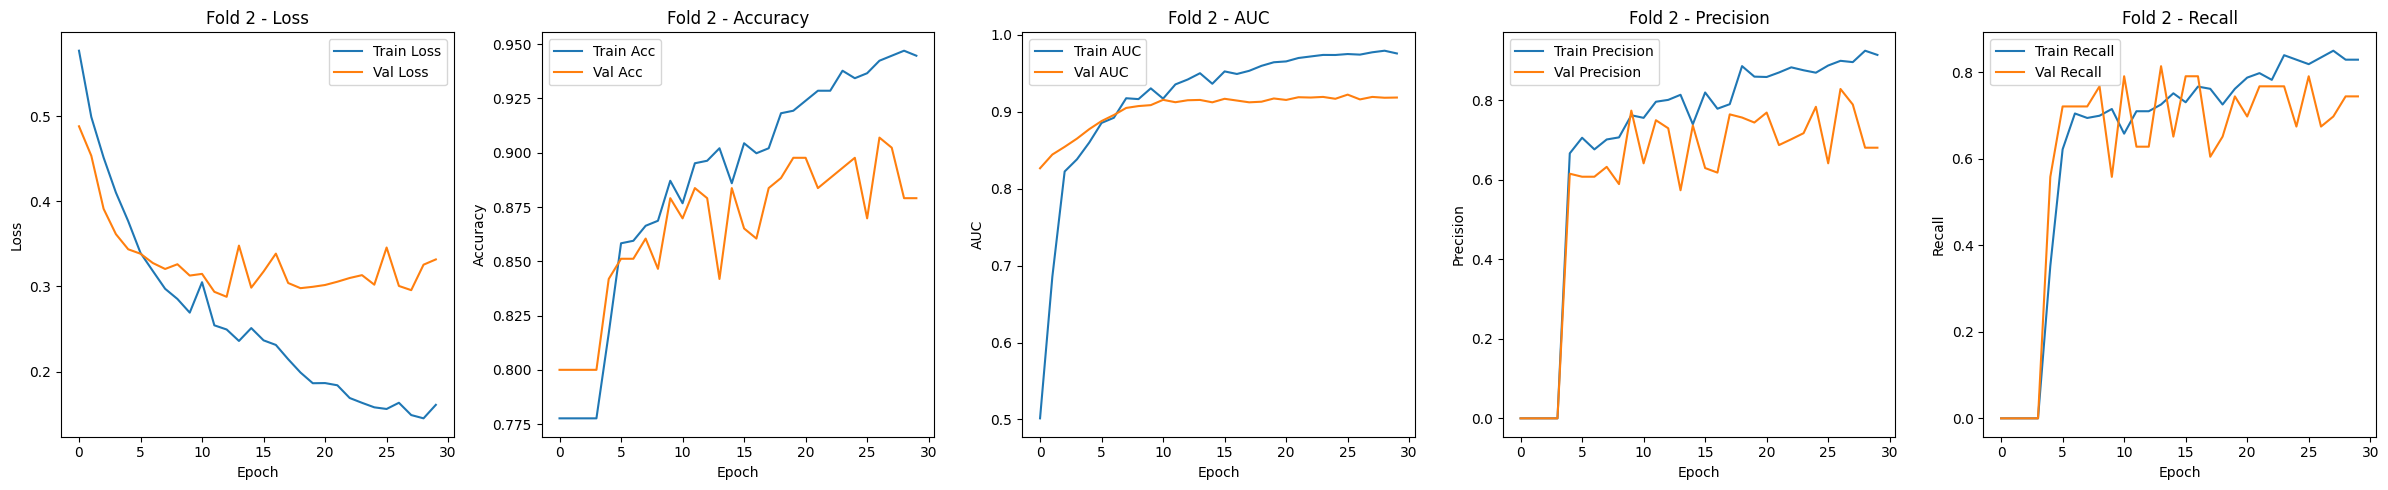

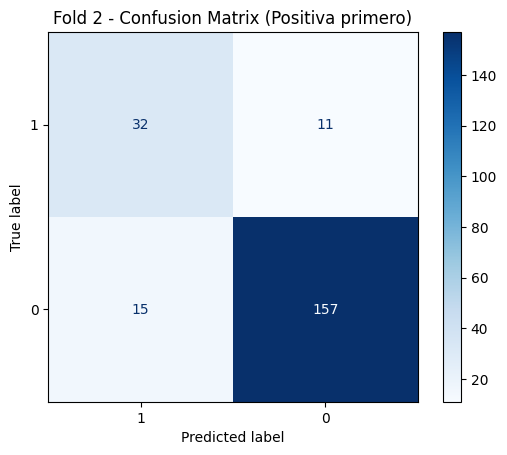


====== Fold 3 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.5898, Acc: 0.7384, AUC: 0.5374, Prec: 0.2955, Rec: 0.1376 | Val Loss: 0.5202, Acc: 0.7892, AUC: 0.8594, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.5029, Acc: 0.7802, AUC: 0.6781, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4671, Acc: 0.7892, AUC: 0.8609, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 03: Train Loss: 0.4468, Acc: 0.7802, AUC: 0.8321, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.3900, Acc: 0.7892, AUC: 0.8630, Prec: 0.0000, Rec: 0.0000
Epoch 04: Train Loss: 0.3919, Acc: 0.7895, AUC: 0.8481, Prec: 0.6250, Rec: 0.1058 | Val Loss: 0.3597, Acc: 0.8520, AUC: 0.8675, Prec: 0.7188, Rec: 0.4894
Epoch 05: Train Loss: 0.3724, Acc: 0.8488, AUC: 0.8593, Prec: 0.7153, Rec: 0.5185 | Val Loss: 0.3498, Acc: 0.8610, AUC: 0.8679, Prec: 0.6818, Rec: 0.6383
Epoch 06: Train Loss: 0.3597, Acc: 0.8430, AUC: 0.8726, Prec: 0.6957, Rec: 0.5079 | Val Loss: 0.3327, Acc: 0.8655, AUC: 0.8760, Prec: 0.6977, Rec: 0.6383
Epoch 07: Train Loss: 0.3252, Acc: 0.8593, AUC: 0.8956, Prec: 0.6889, Rec: 0.6561 | Val Loss: 0.3428, Acc: 0.8565, AUC: 0.8856, Prec: 0.6271, Rec: 0.7872
Epoch 08: Train Loss: 0.3171, Acc: 0.8616, AUC: 0.9041, Prec: 0.6902, Rec: 0.6720 | Val Loss: 0.3135, Acc: 0.8610, AUC: 0.8919, Prec: 0.6818, Rec: 0.6383
Epoch 09: Train Loss: 0.3045, Acc: 0.8616, AUC: 0.9099, Prec: 0.7273, Rec: 0

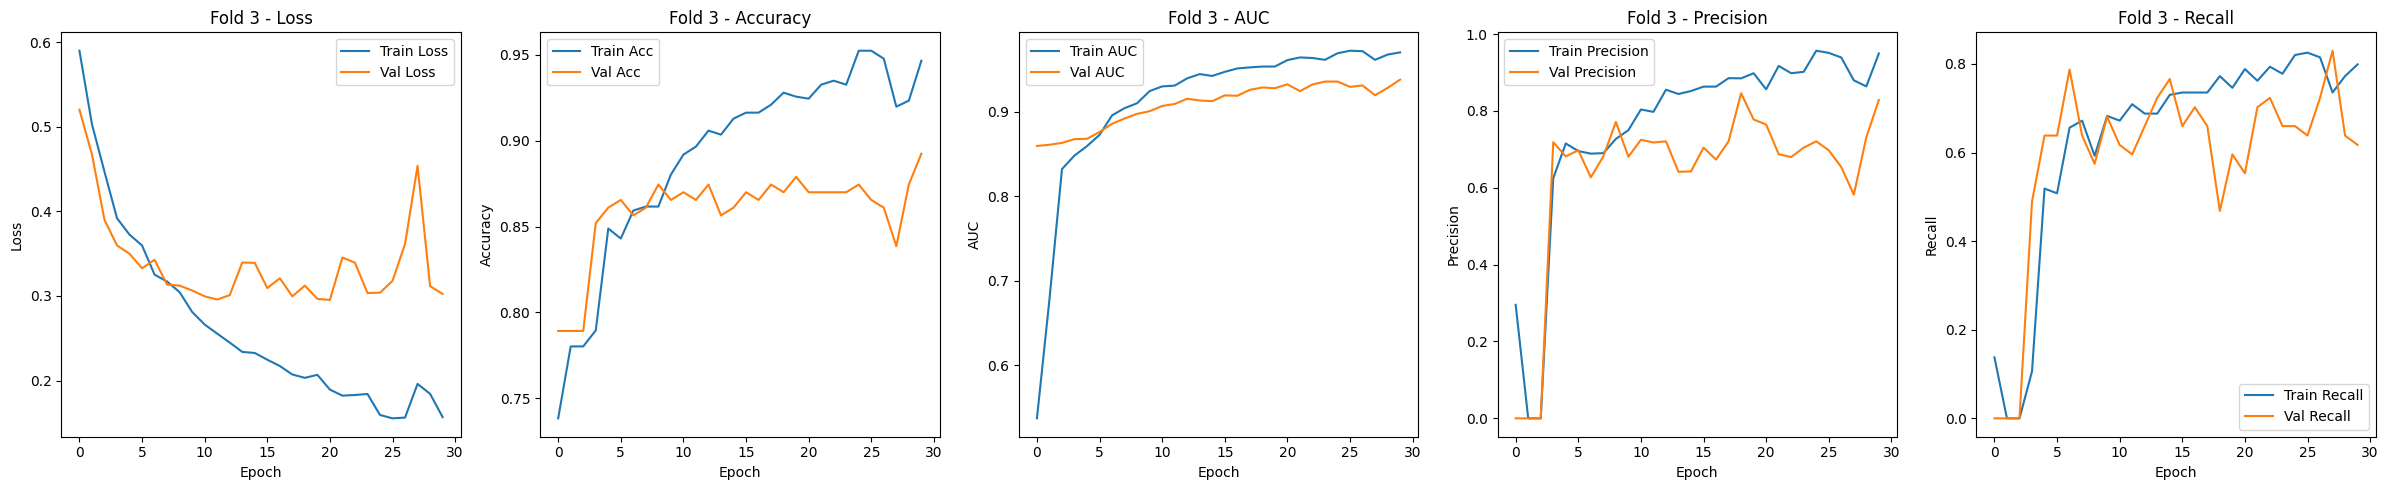

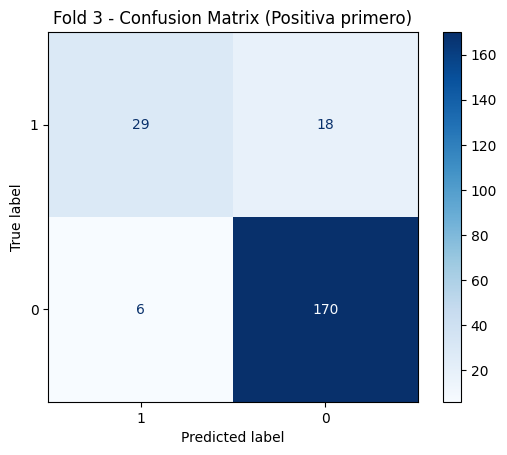


====== Fold 4 ======


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 01: Train Loss: 0.5715, Acc: 0.7881, AUC: 0.5258, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.5800, Acc: 0.7571, AUC: 0.7847, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 02: Train Loss: 0.4817, Acc: 0.7881, AUC: 0.7237, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.5304, Acc: 0.7571, AUC: 0.7868, Prec: 0.0000, Rec: 0.0000
Epoch 03: Train Loss: 0.4379, Acc: 0.7881, AUC: 0.8300, Prec: 0.0000, Rec: 0.0000 | Val Loss: 0.4751, Acc: 0.7571, AUC: 0.7991, Prec: 0.0000, Rec: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 04: Train Loss: 0.3793, Acc: 0.7892, AUC: 0.8575, Prec: 0.6000, Rec: 0.0162 | Val Loss: 0.4457, Acc: 0.8095, AUC: 0.8218, Prec: 0.9231, Rec: 0.2353
Epoch 05: Train Loss: 0.3572, Acc: 0.8431, AUC: 0.8689, Prec: 0.6690, Rec: 0.5135 | Val Loss: 0.4255, Acc: 0.8381, AUC: 0.8410, Prec: 0.8400, Rec: 0.4118
Epoch 06: Train Loss: 0.3424, Acc: 0.8499, AUC: 0.8807, Prec: 0.6627, Rec: 0.5946 | Val Loss: 0.4091, Acc: 0.8476, AUC: 0.8571, Prec: 0.8519, Rec: 0.4510
Epoch 07: Train Loss: 0.3251, Acc: 0.8568, AUC: 0.8949, Prec: 0.6724, Rec: 0.6324 | Val Loss: 0.3896, Acc: 0.8571, AUC: 0.8724, Prec: 0.8621, Rec: 0.4902
Epoch 08: Train Loss: 0.3222, Acc: 0.8580, AUC: 0.8950, Prec: 0.6805, Rec: 0.6216 | Val Loss: 0.3846, Acc: 0.8524, AUC: 0.8851, Prec: 0.9167, Rec: 0.4314
Epoch 09: Train Loss: 0.3072, Acc: 0.8637, AUC: 0.9031, Prec: 0.6964, Rec: 0.6324 | Val Loss: 0.3284, Acc: 0.8857, AUC: 0.8915, Prec: 0.8649, Rec: 0.6275
Epoch 10: Train Loss: 0.2911, Acc: 0.8740, AUC: 0.9162, Prec: 0.7219, Rec: 0

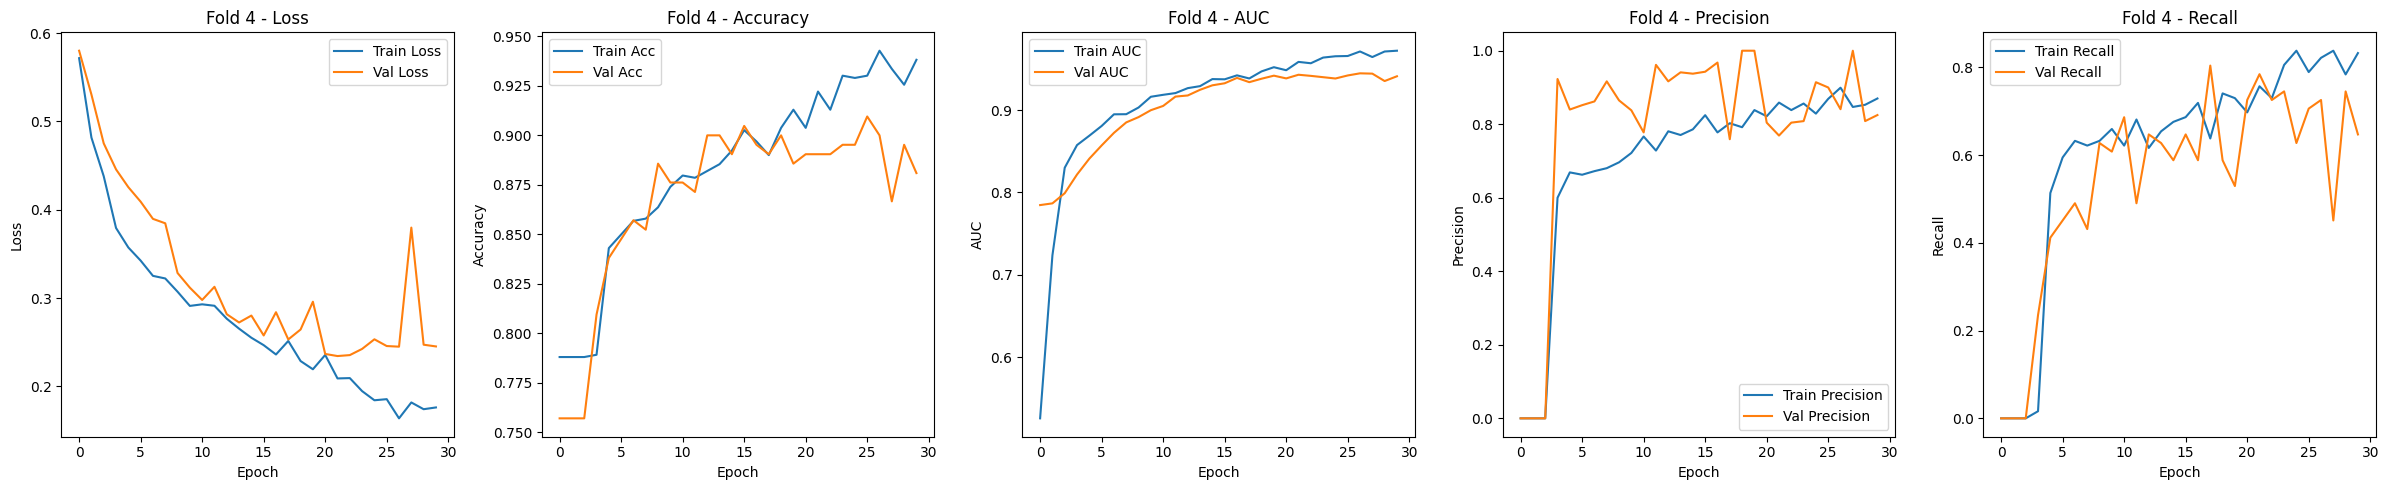

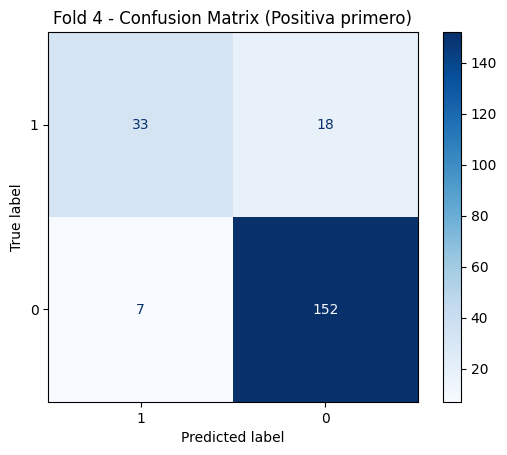


===== Resultados Finales por Fold =====
Fold 0 - Val Acc: 0.8952, AUC: 0.9241, Precision: 0.9355, Recall: 0.5918
Fold 1 - Val Acc: 0.8844, AUC: 0.9415, Precision: 0.8333, Recall: 0.5435
Fold 2 - Val Acc: 0.8791, AUC: 0.9185, Precision: 0.6809, Recall: 0.7442
Fold 3 - Val Acc: 0.8924, AUC: 0.9379, Precision: 0.8286, Recall: 0.6170
Fold 4 - Val Acc: 0.8810, AUC: 0.9411, Precision: 0.8250, Recall: 0.6471

===== Promedios Finales con Desviación Estándar =====
Val Accuracy: 0.8864 ± 0.0063
Val AUC: 0.9326 ± 0.0095
Val Precision: 0.8206 ± 0.0812
Val Recall: 0.6287 ± 0.0670


In [ ]:
for fold in range(5):
  print(f"\n====== Fold {fold} ======")

  # Preparar datos
  train_ids = kfold_data[f"train_fold_{fold}"]
  val_ids = kfold_data[f"val_fold_{fold}"]

  train_dataset = [id_to_data[i] for i in train_ids]
  val_dataset = [id_to_data[i] for i in val_ids]

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  # Inicializar modelo
  model = GIN(num_features, num_classes).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  train_losses, val_losses = [], []
  train_accuracies, val_accuracies = [], []
  train_aucs, val_aucs = [], []
  train_precisions, val_precisions = [], []
  train_recalls, val_recalls = [], []

  for epoch in range(1, num_epochs + 1):
    # ---- ENTRENAMIENTO ----
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    y_train_true = []
    y_train_prob = []
    y_train_pred = []

    for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      out = model(data.x, data.edge_index, data.batch)
      loss = criterion(out, data.y)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
      pred = out.argmax(dim=1)
      correct += (pred == data.y).sum().item()
      total += data.y.size(0)

      y_train_true.append(data.y.cpu())
      y_train_prob.append(F.softmax(out, dim=1)[:, 1].detach().cpu())
      y_train_pred.append(pred.cpu())

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    y_train_true = torch.cat(y_train_true)
    y_train_prob = torch.cat(y_train_prob)
    y_train_pred = torch.cat(y_train_pred)
    train_auc = roc_auc_score(y_train_true, y_train_prob)
    train_precision = precision_score(y_train_true, y_train_pred)
    train_recall = recall_score(y_train_true, y_train_pred)

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    train_aucs.append(train_auc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)

    # ---- VALIDACIÓN ----
    model.eval()
    val_loss = 0
    correct = 0
    y_true = []
    y_prob = []
    y_pred = []

    with torch.no_grad():
      for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        val_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        y_true.append(data.y.cpu())
        y_prob.append(F.softmax(out, dim=1)[:, 1].cpu())
        y_pred.append(pred.cpu())

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / len(val_loader.dataset)
    y_true = torch.cat(y_true)
    y_prob = torch.cat(y_prob)
    y_pred = torch.cat(y_pred)
    val_auc = roc_auc_score(y_true, y_prob)
    val_precision = precision_score(y_true, y_pred)
    val_recall = recall_score(y_true, y_pred)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    val_aucs.append(val_auc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_accuracy:.4f}, AUC: {train_auc:.4f}, "
          f"Prec: {train_precision:.4f}, Rec: {train_recall:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, AUC: {val_auc:.4f}, "
          f"Prec: {val_precision:.4f}, Rec: {val_recall:.4f}")

  # Guardar AUC y Accuracy final del fold
  all_val_accs.append(val_accuracies[-1])
  all_val_aucs.append(val_aucs[-1])
  all_val_precisions.append(val_precisions[-1])
  all_val_recalls.append(val_recalls[-1])

  # Graficar métricas por fold
  plt.figure(figsize=(24, 5))

  plt.subplot(1, 5, 1)
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.title(f'Fold {fold} - Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 5, 2)
  plt.plot(train_accuracies, label='Train Acc')
  plt.plot(val_accuracies, label='Val Acc')
  plt.title(f'Fold {fold} - Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 5, 3)
  plt.plot(train_aucs, label='Train AUC')
  plt.plot(val_aucs, label='Val AUC')
  plt.title(f'Fold {fold} - AUC')
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.legend()

  plt.subplot(1, 5, 4)
  plt.plot(train_precisions, label='Train Precision')
  plt.plot(val_precisions, label='Val Precision')
  plt.title(f'Fold {fold} - Precision')
  plt.xlabel('Epoch')
  plt.ylabel('Precision')
  plt.legend()

  plt.subplot(1, 5, 5)
  plt.plot(train_recalls, label='Train Recall')
  plt.plot(val_recalls, label='Val Recall')
  plt.title(f'Fold {fold} - Recall')
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.legend()

  plt.tight_layout()
  plt.show()

  # Matriz de confusión
  cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 0])
  disp.plot(cmap='Blues')
  plt.title(f'Fold {fold} - Confusion Matrix (Positiva primero)')
  plt.show()

# Resultados globales
print("\n===== Resultados Finales por Fold =====")
for i in range(len(all_val_accs)):
  print(f"Fold {i} - Val Acc: {all_val_accs[i]:.4f}, AUC: {all_val_aucs[i]:.4f}, "
        f"Precision: {all_val_precisions[i]:.4f}, Recall: {all_val_recalls[i]:.4f}")

# Promedios finales con desviación estándar
print("\n===== Promedios Finales con Desviación Estándar =====")
print(f"Val Accuracy: {np.mean(all_val_accs):.4f} ± {np.std(all_val_accs):.4f}")
print(f"Val AUC: {np.mean(all_val_aucs):.4f} ± {np.std(all_val_aucs):.4f}")
print(f"Val Precision: {np.mean(all_val_precisions):.4f} ± {np.std(all_val_precisions):.4f}")
print(f"Val Recall: {np.mean(all_val_recalls):.4f} ± {np.std(all_val_recalls):.4f}")